In this notebook, we show some supporting functions for reading, visualizing the training and testing data. And, we give a demo on how to use the provided supporting functions to predict the labels for each motor and produce outputs in the required format for the data challenge submission. Finally, we show a demo on how to prepare the submission file based on the provided csv template.

## Reading the data.

As we shown in WP_1, we can use the `read_all_tst_data_from_path` function to read and visualize data. Please note you have the option to define the preprocessing you would like to do on the original data. For this, you just need to define your preprocessing function and pass its function handle to the `read_all_tst_data_from_path` function.

Below is a sample code that reads and visualize all the training dataset, where we apply a simple outlier removal based on validity range as pre-processing. We also remove sequence-to-sequence variablity in the pre-processing. Please note that you need to download the datasets `training_data.zip` and `testing_data.zip` from [kaggle](https://www.kaggle.com/competitions/robot-predictive-maintenance/data) and unzip them. You need to change the path in the sample code below to the path of your datasets.

### Training data.

In [20]:
utility_path = '../'
import sys
sys.path.insert(1, utility_path)

from utility import read_all_test_data_from_path
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
%matplotlib inline

# Subfunction for data preprocessing.
def pre_processing(df: pd.DataFrame):
    ''' ### Description
    Preprocess the data:
    - remove outliers
    - add new features about the difference between the current and previous n data point.
    '''
    
    def remove_outliers(df: pd.DataFrame):
        ''' # Description
        Remove outliers from the dataframe based on defined valid ranges. 
        Define a valid range of temperature and voltage. 
        Use ffil function to replace the invalid measurement with the previous value.
        '''
        df['temperature'] = df['temperature'].where(df['temperature'] <= 100, np.nan)
        df['temperature'] = df['temperature'].where(df['temperature'] >= 0, np.nan)
        df['temperature'] = df['temperature'].ffill()        

        df['voltage'] = df['voltage'].where(df['voltage'] >= 6000, np.nan)
        df['voltage'] = df['voltage'].where(df['voltage'] <= 9000, np.nan)
        df['voltage'] = df['voltage'].ffill()        

        df['position'] = df['position'].where(df['position'] >= 0, np.nan)
        df['position'] = df['position'].where(df['position'] <= 1000, np.nan)
        df['position'] = df['position'].ffill()


    def remove_seq_variability(df: pd.DataFrame):
        ''' # Description
        Remove the sequence-to-sequence variability.
        '''
        # Tranform the features relative to the first data point.
        df['temperature'] = df['temperature'] - df['temperature'].iloc[0]
        df['voltage'] = df['voltage'] - df['voltage'].iloc[0]
        df['position'] = df['position'] - df['position'].iloc[0]
        
    # Start processing.
    remove_outliers(df)
    remove_seq_variability(df)

20240105_164214: 0    Not moving
Name: Description, dtype: object



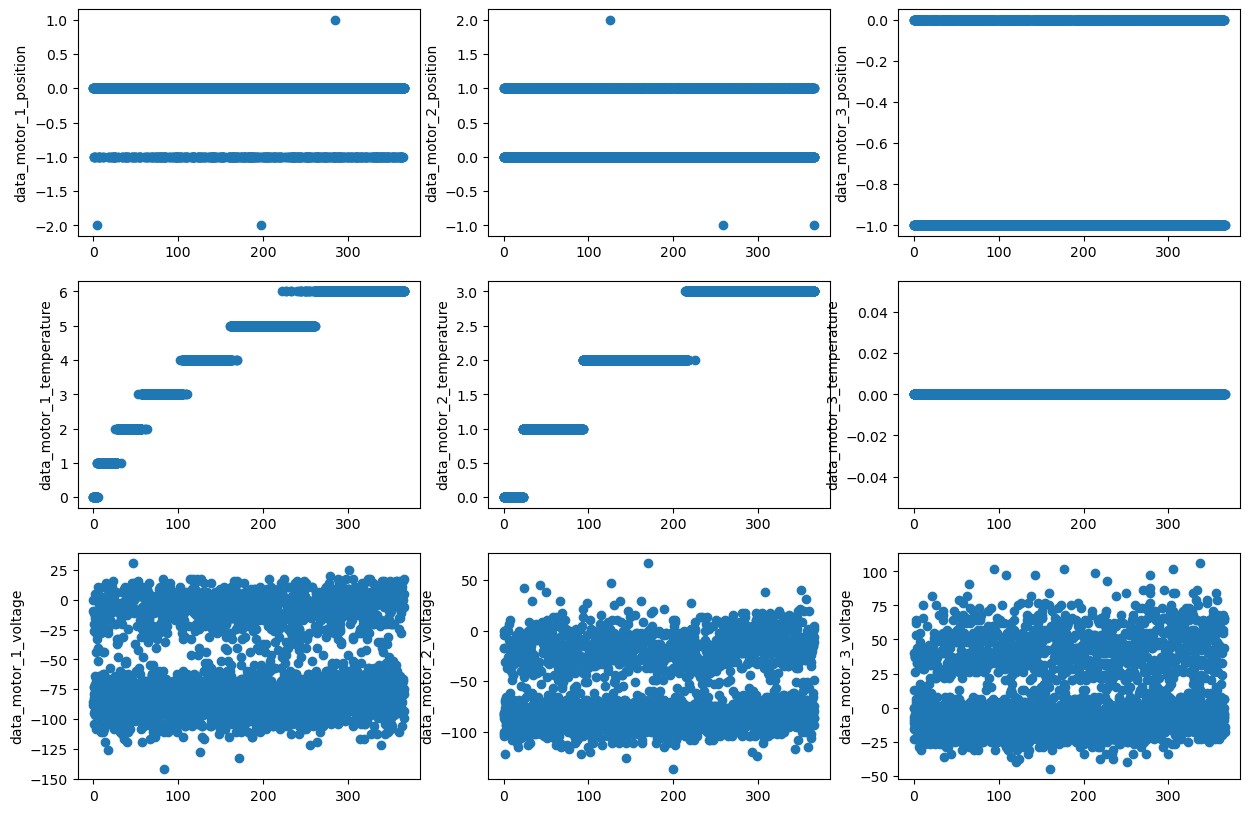

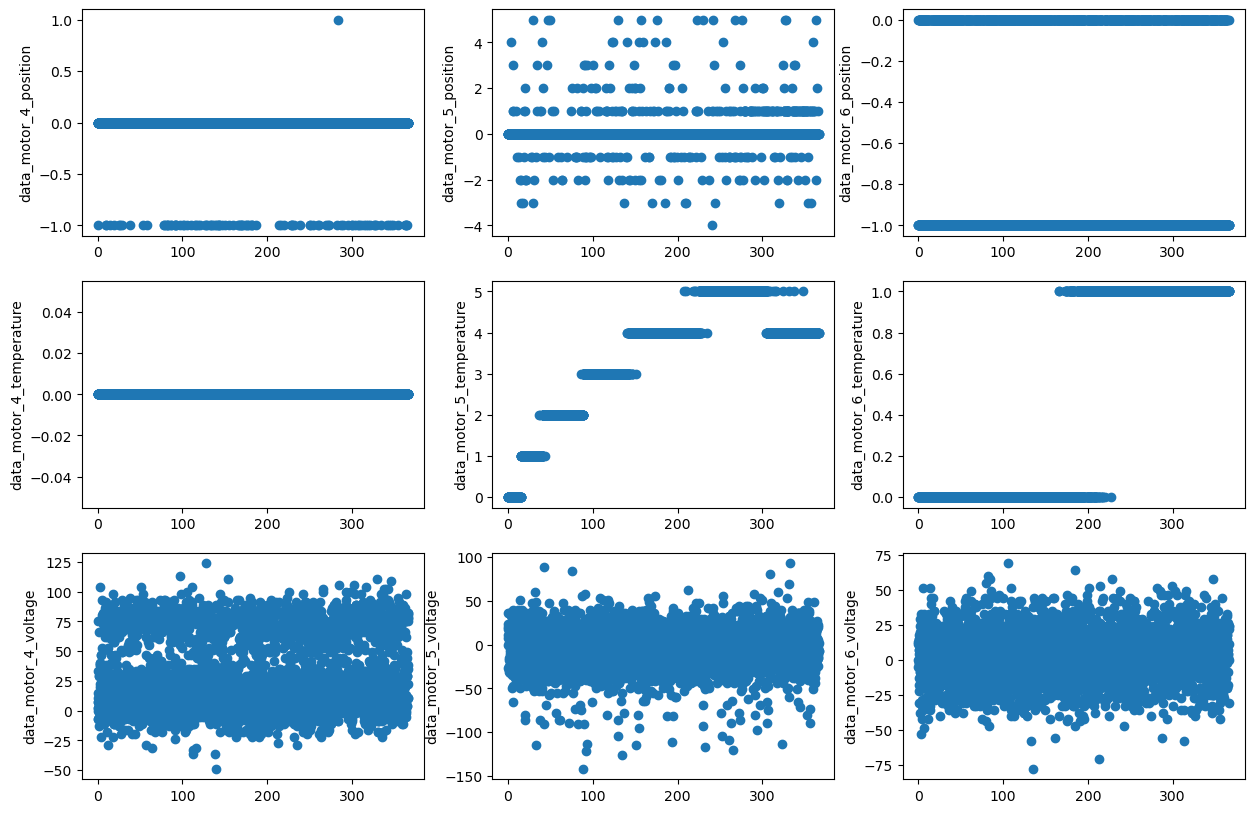

20240105_165300: 1    Pick up and place
Name: Description, dtype: object



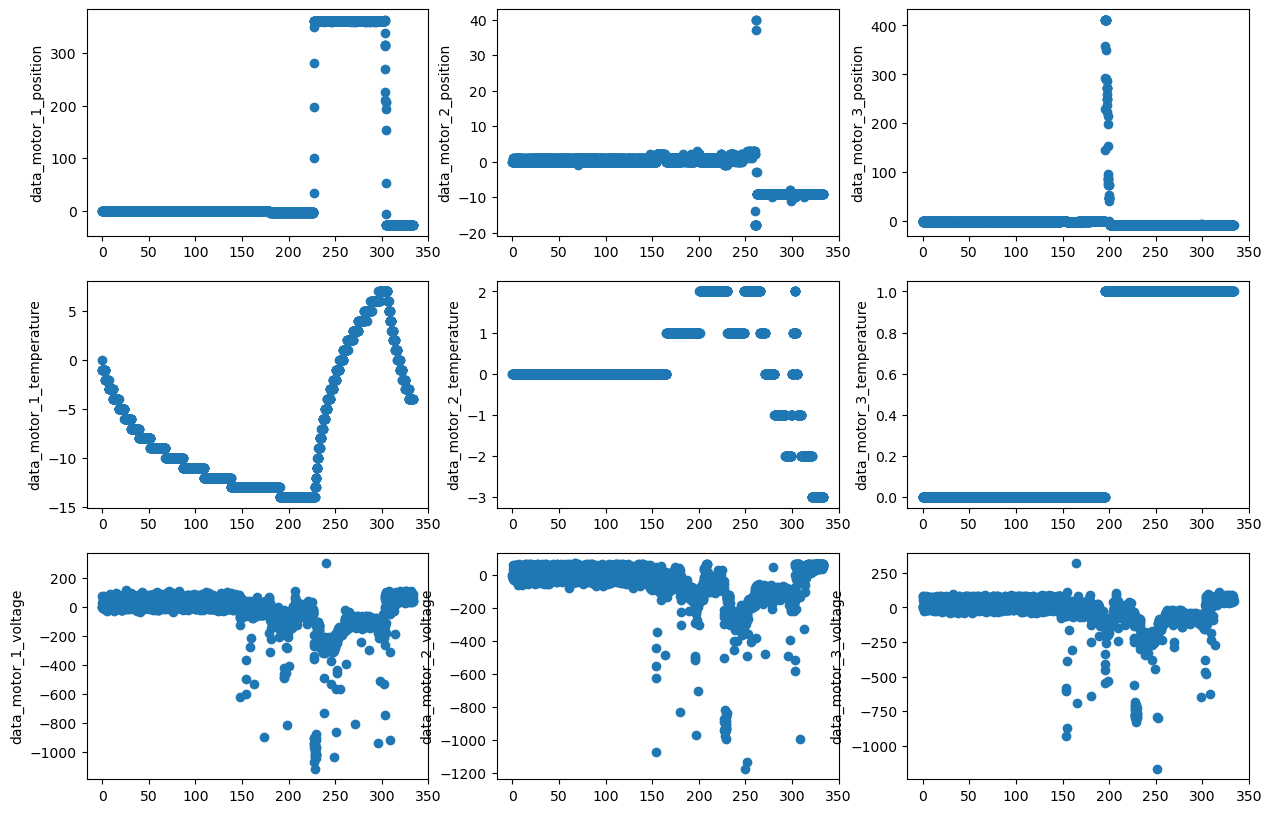

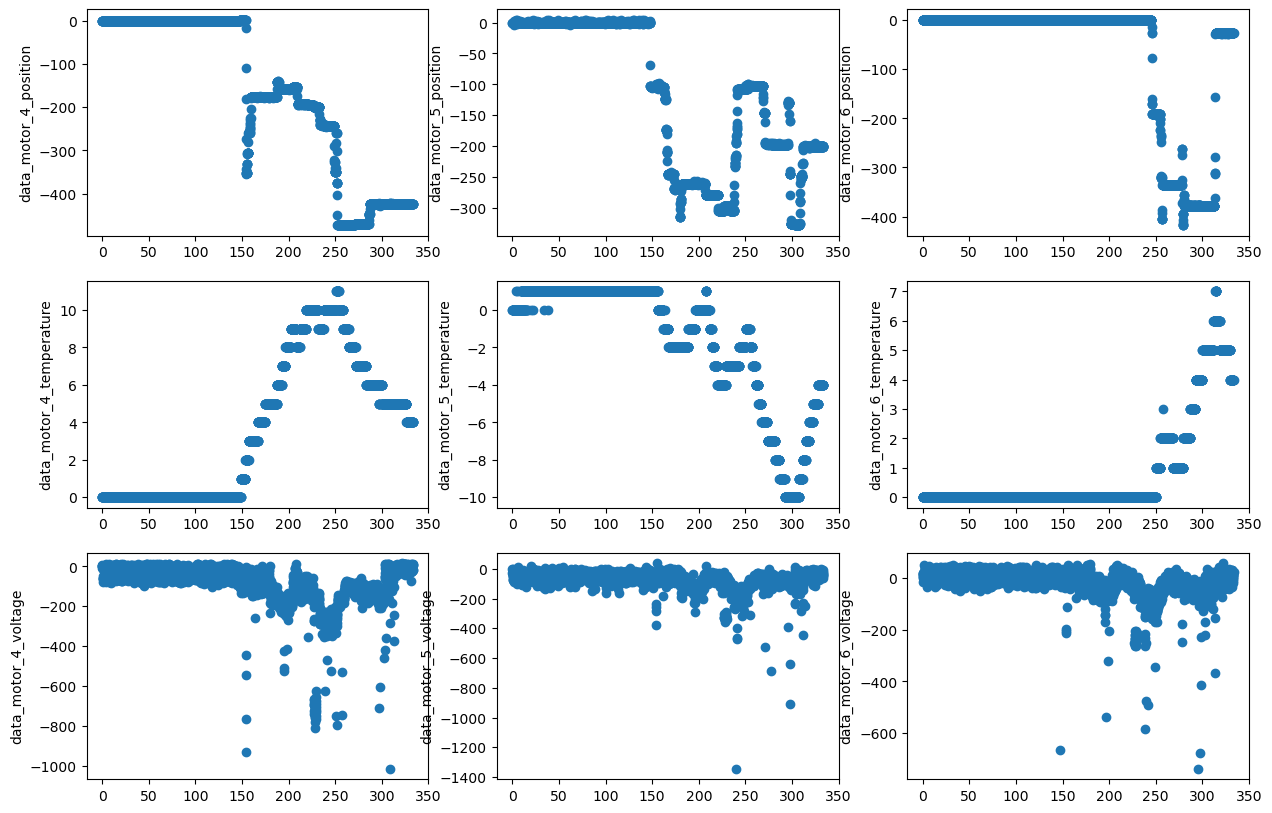

20240105_165972: 2    Not moving
Name: Description, dtype: object



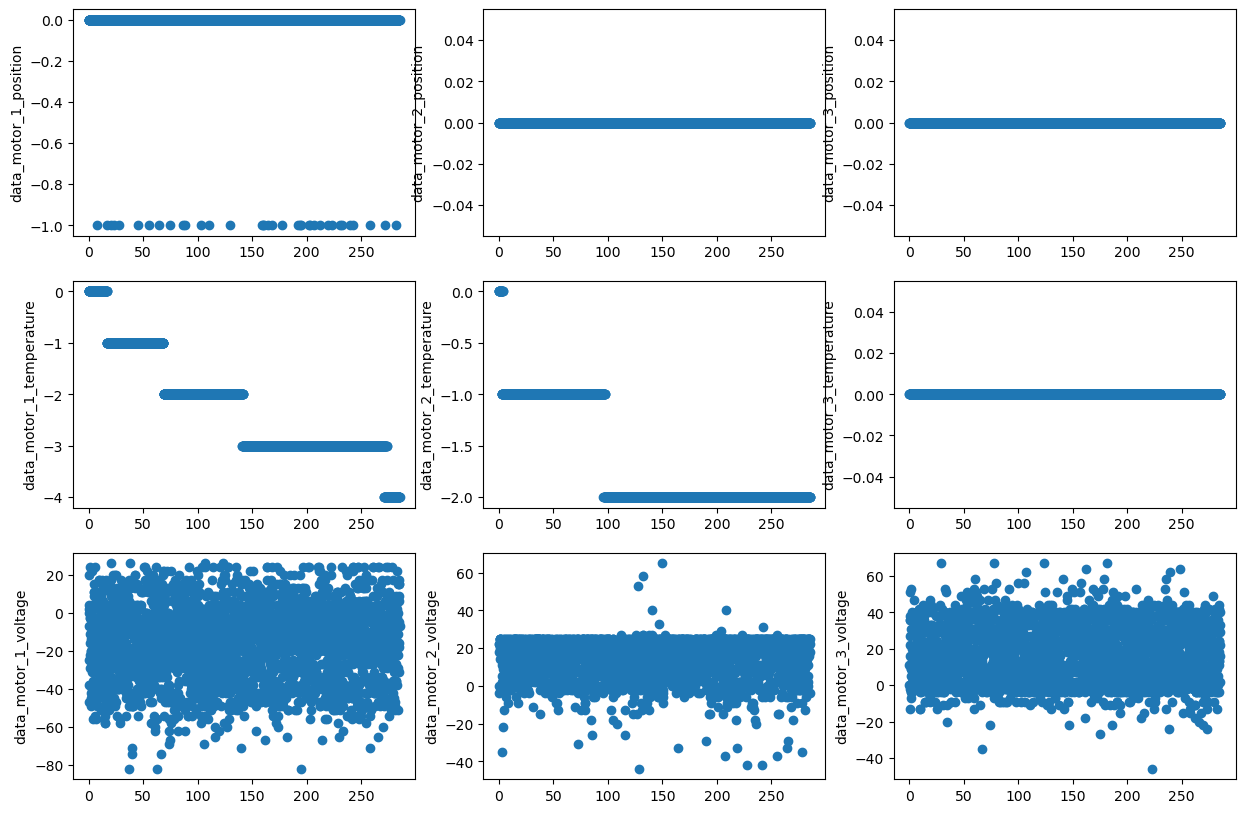

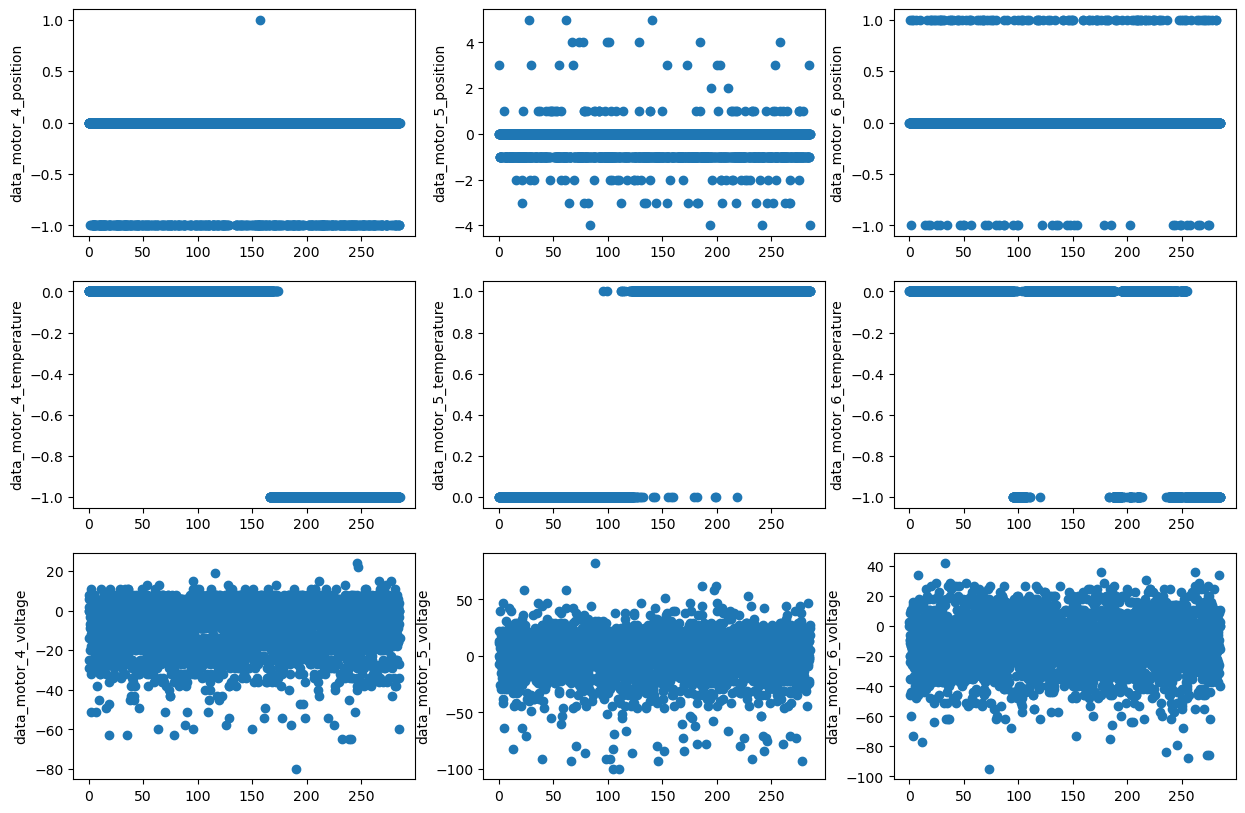

20240320_152031: 3    Not moving
Name: Description, dtype: object



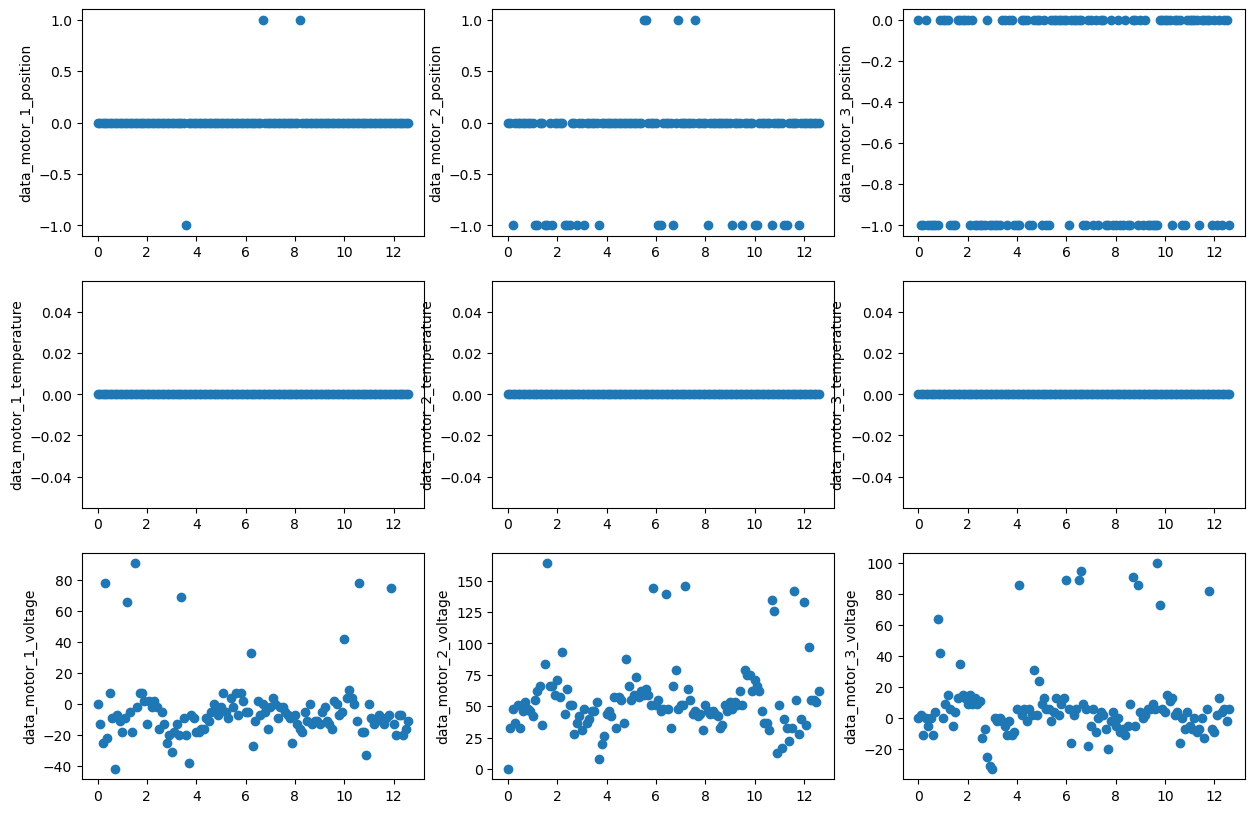

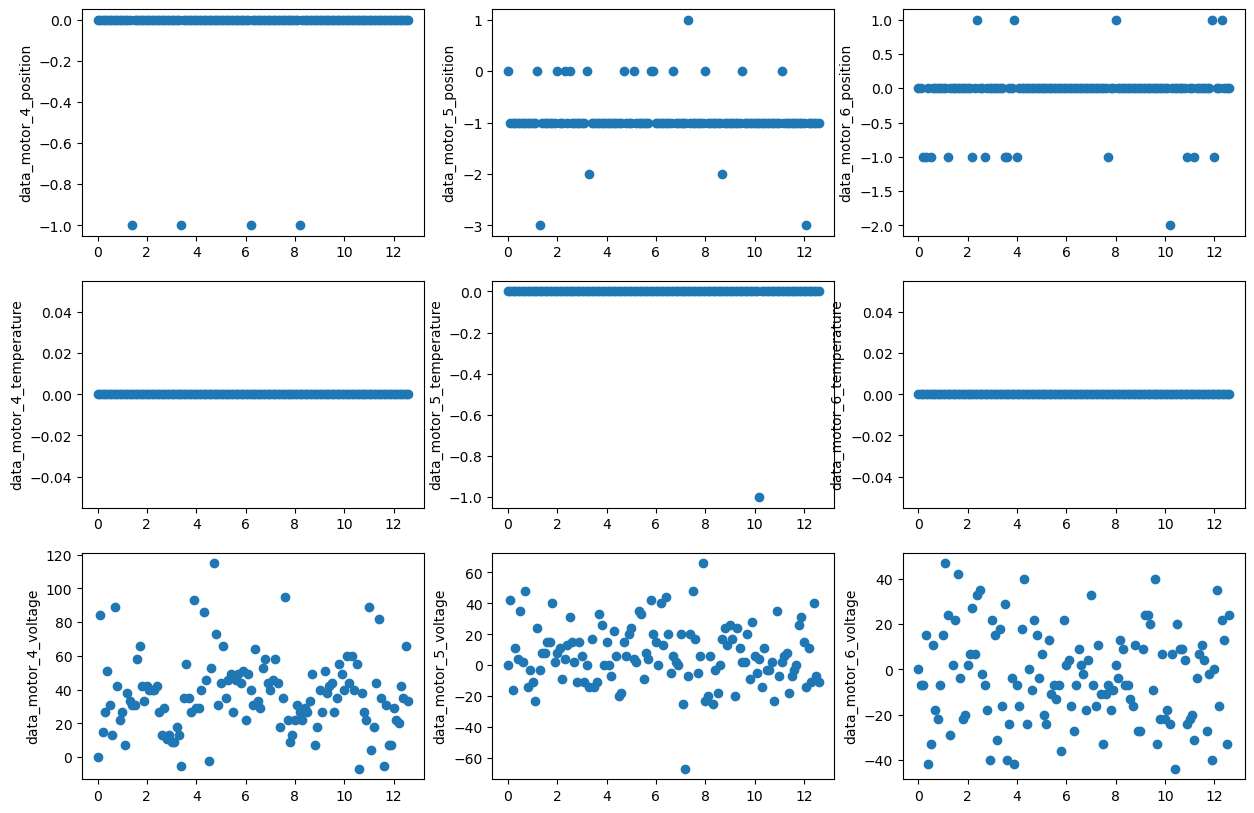

20240320_153841: 4    Move motor 6 -> motor 1 sequentially.
Name: Description, dtype: object



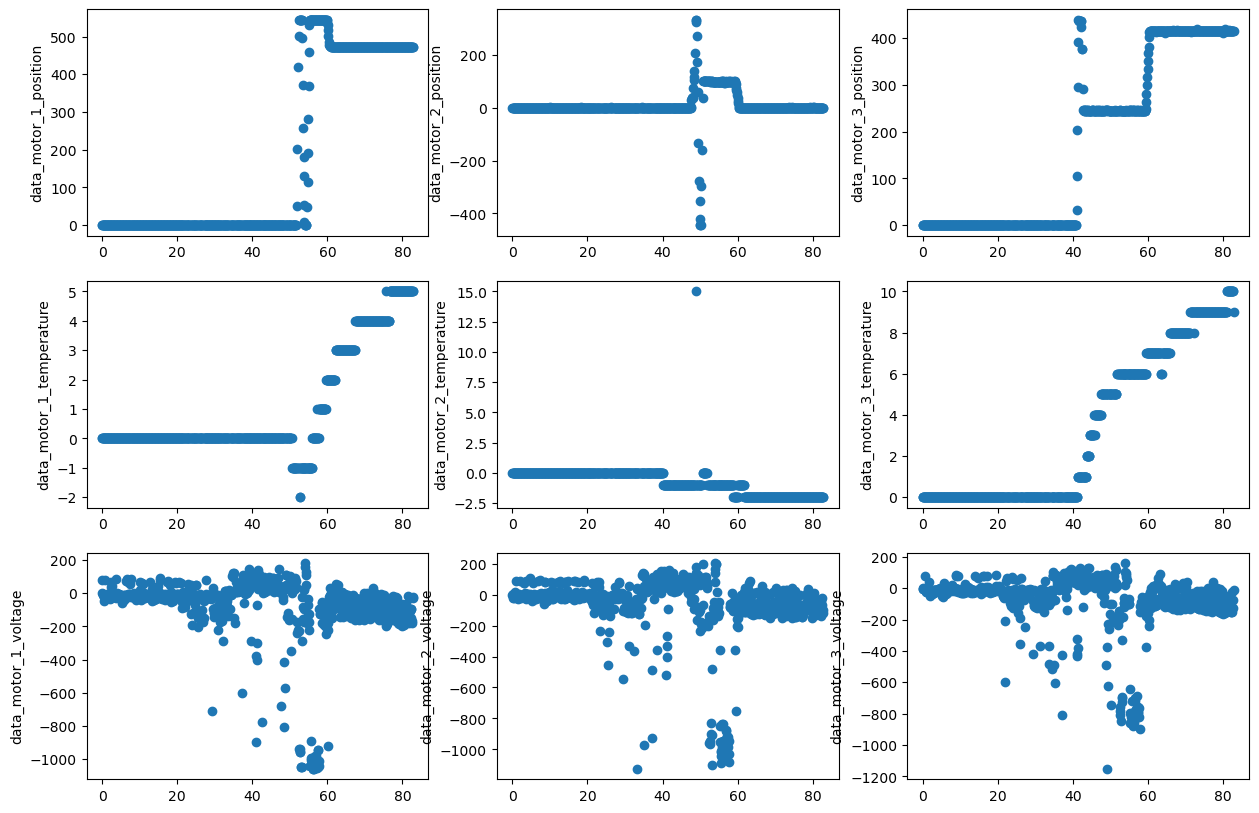

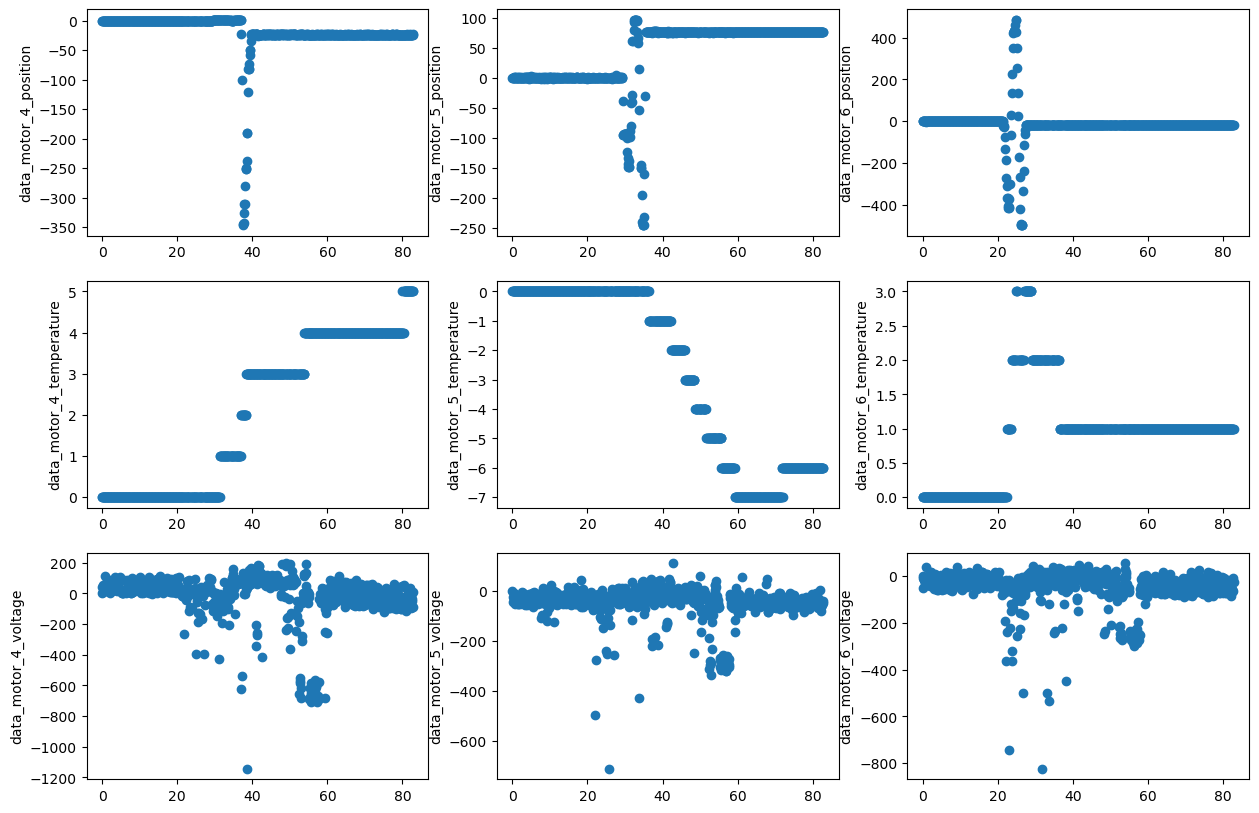

20240320_155664: 5    Not moving
Name: Description, dtype: object



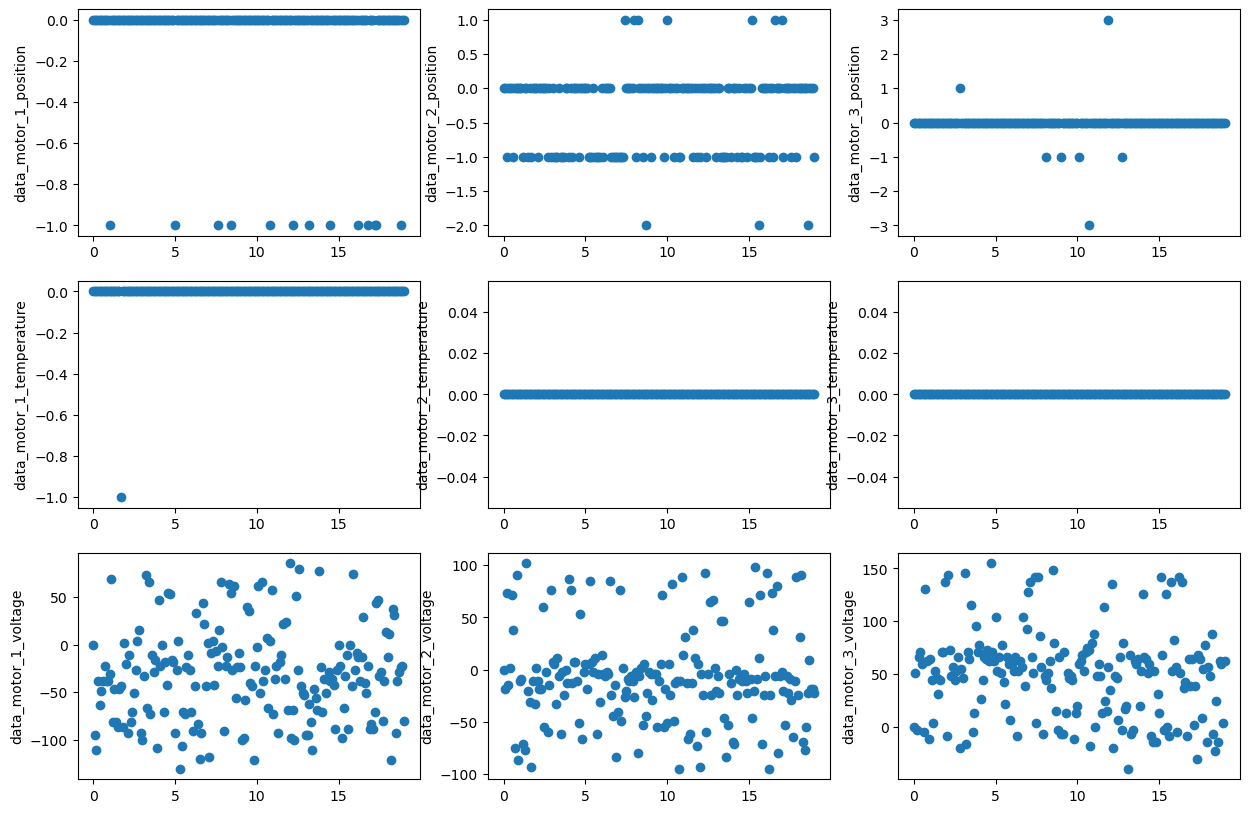

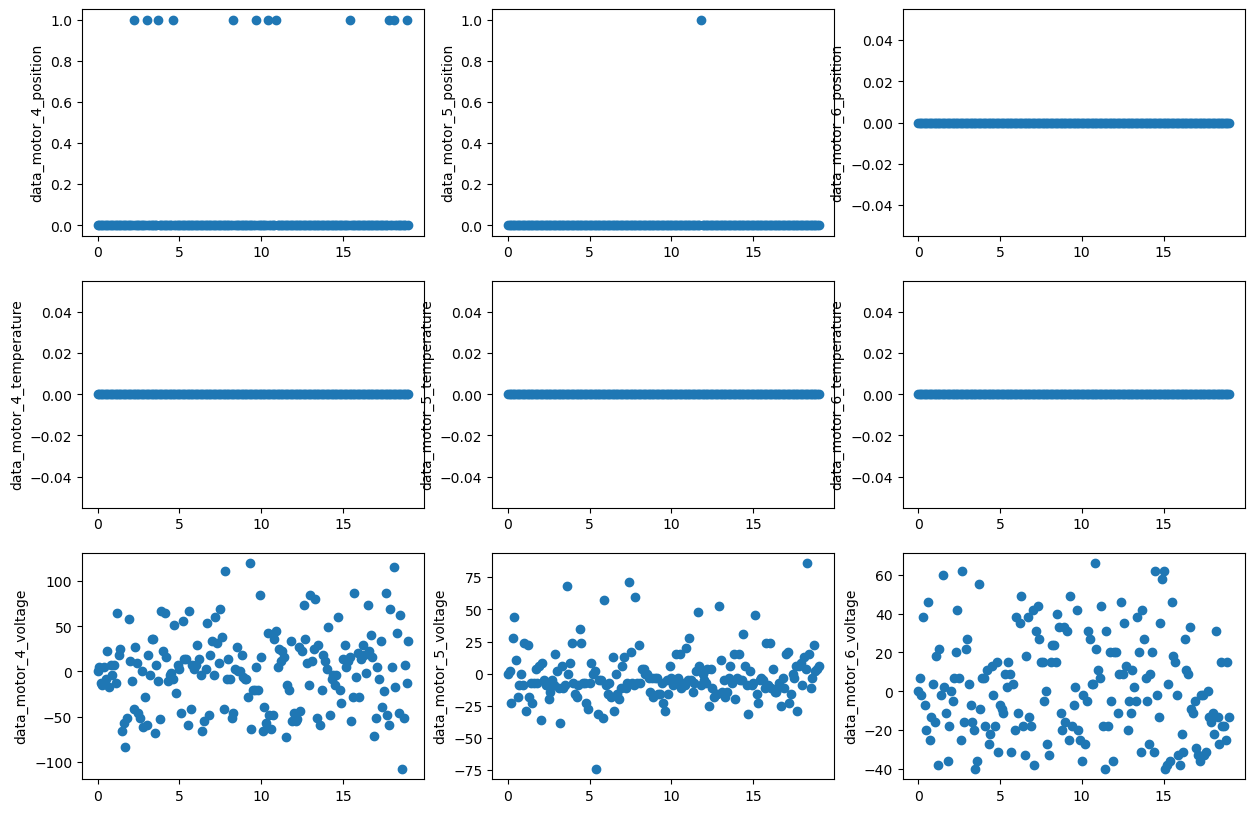

20240321_122650: 6    Pick up and place
Name: Description, dtype: object



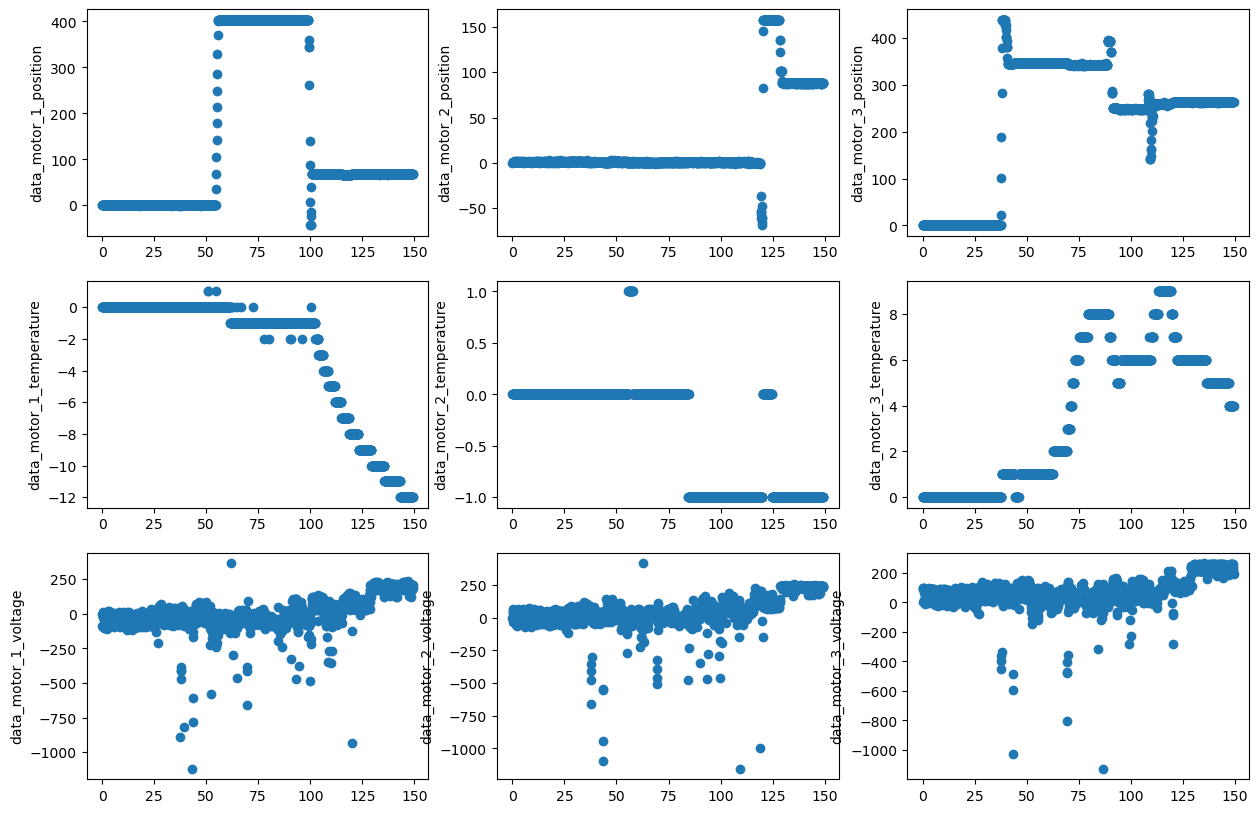

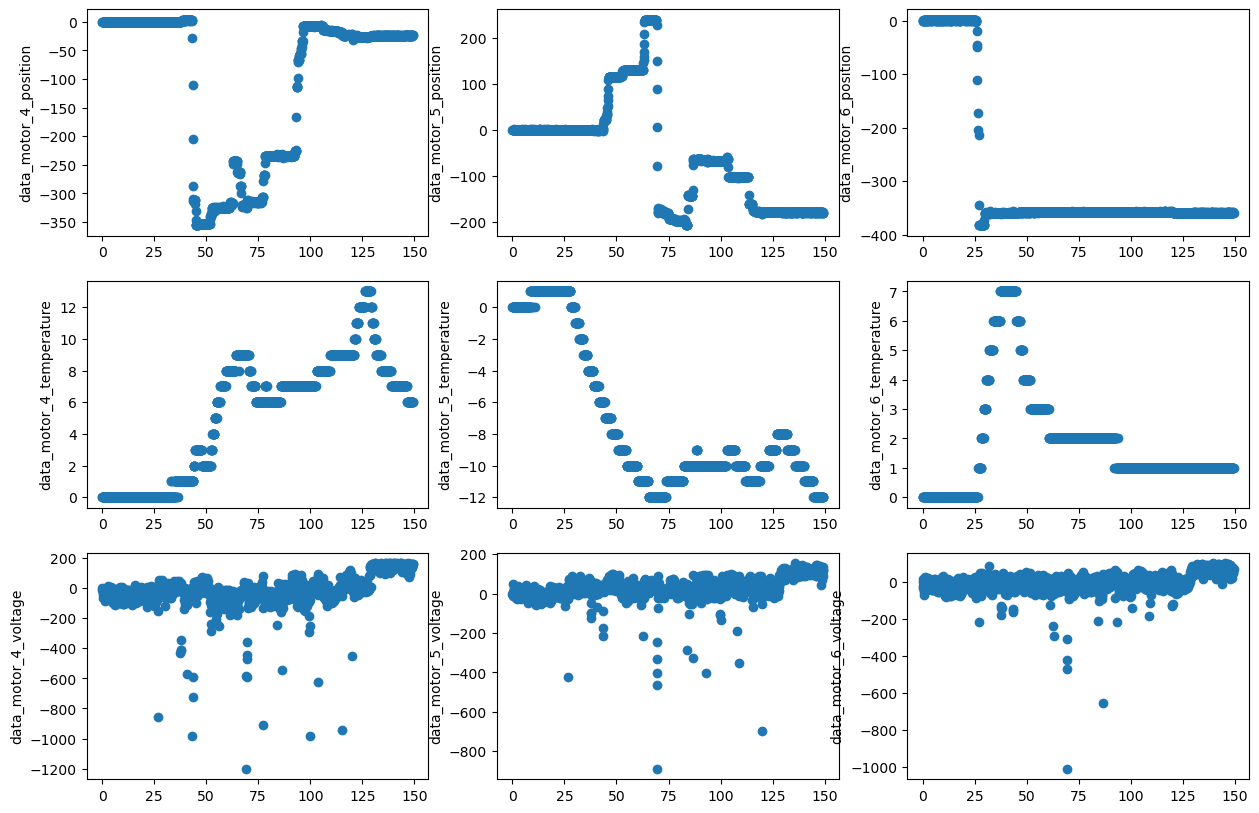

20240325_135213: 7    Not moving
Name: Description, dtype: object



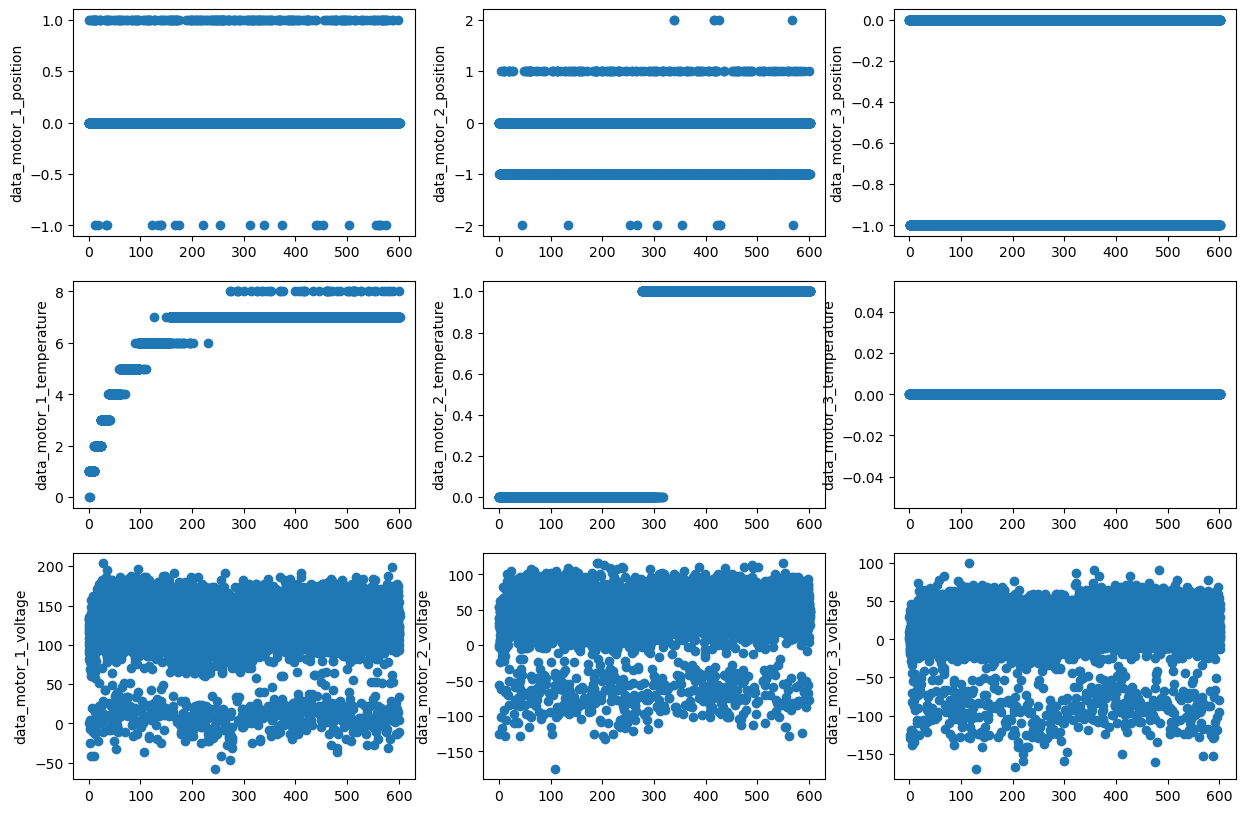

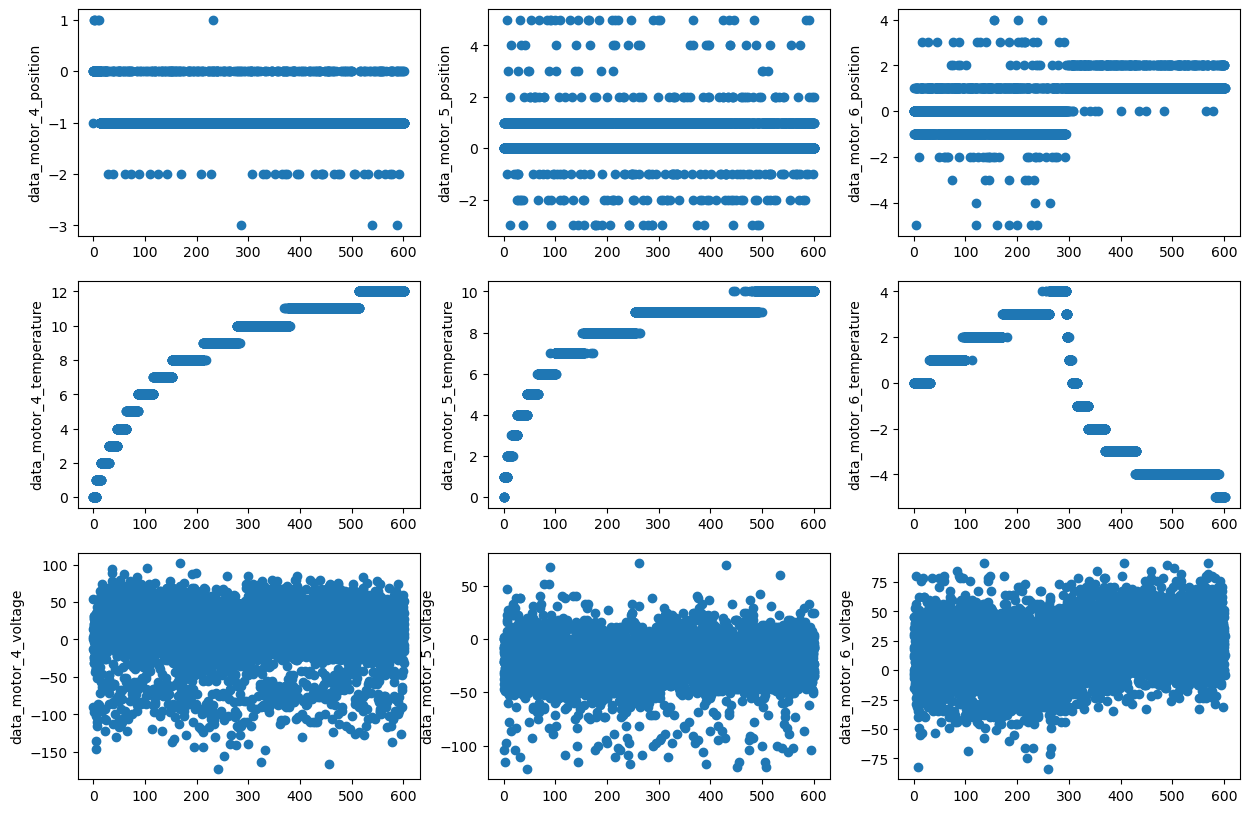

20240325_152902: 8    Pick up and place
Name: Description, dtype: object



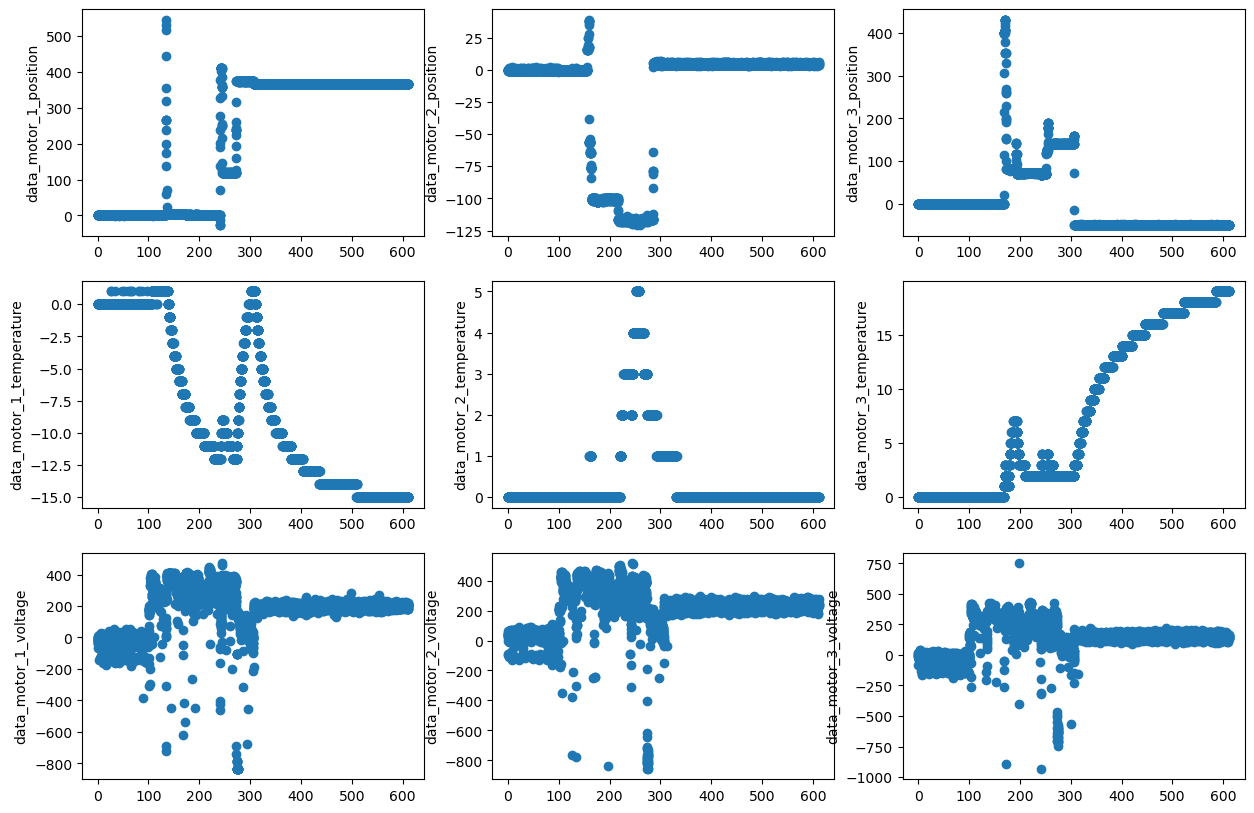

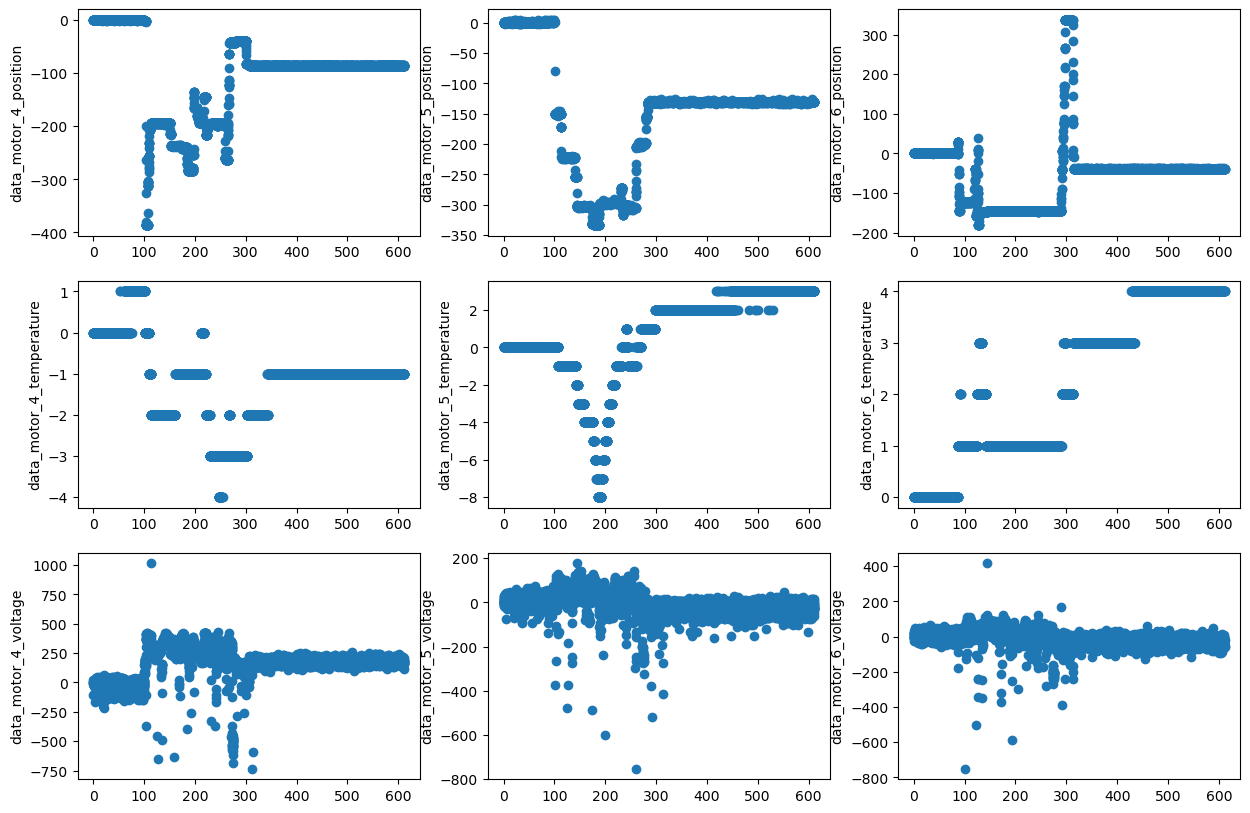

20240325_155003: 9    Pick up and place
Name: Description, dtype: object



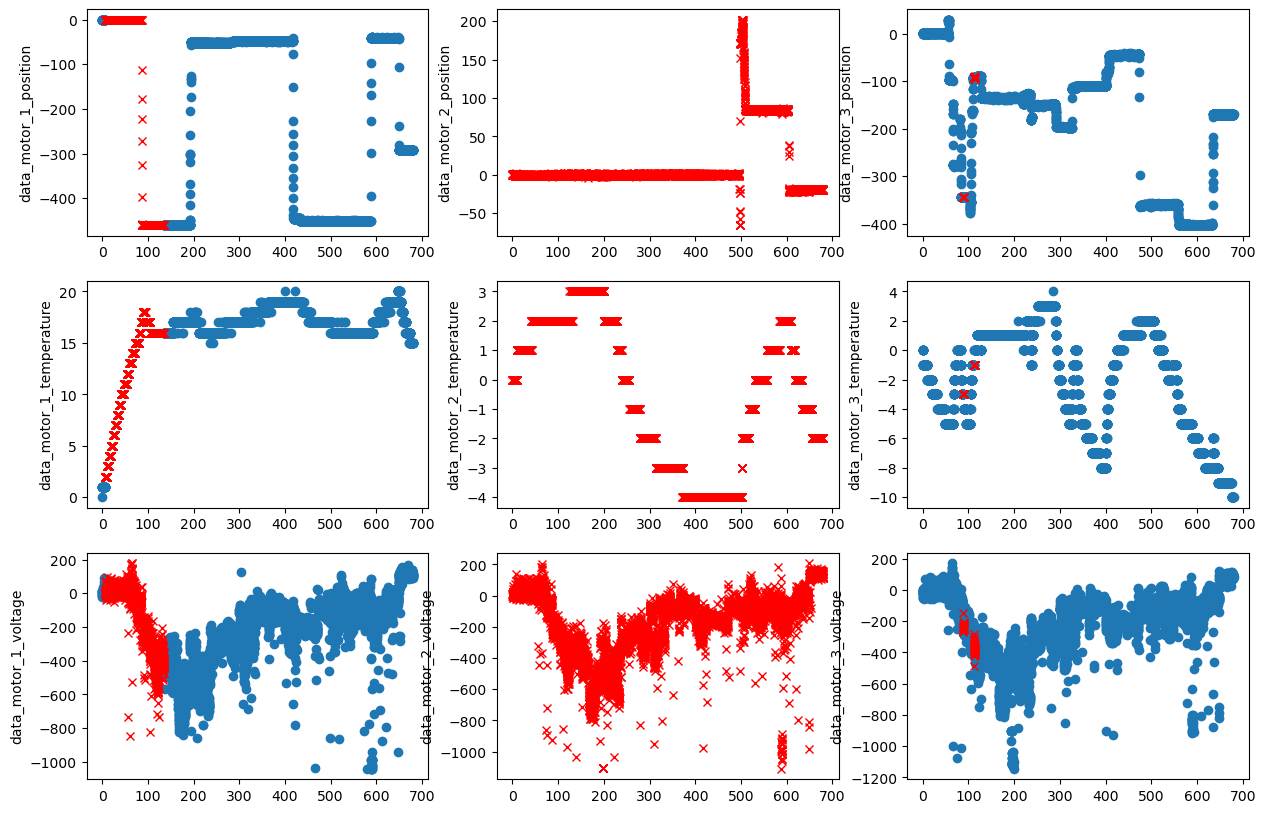

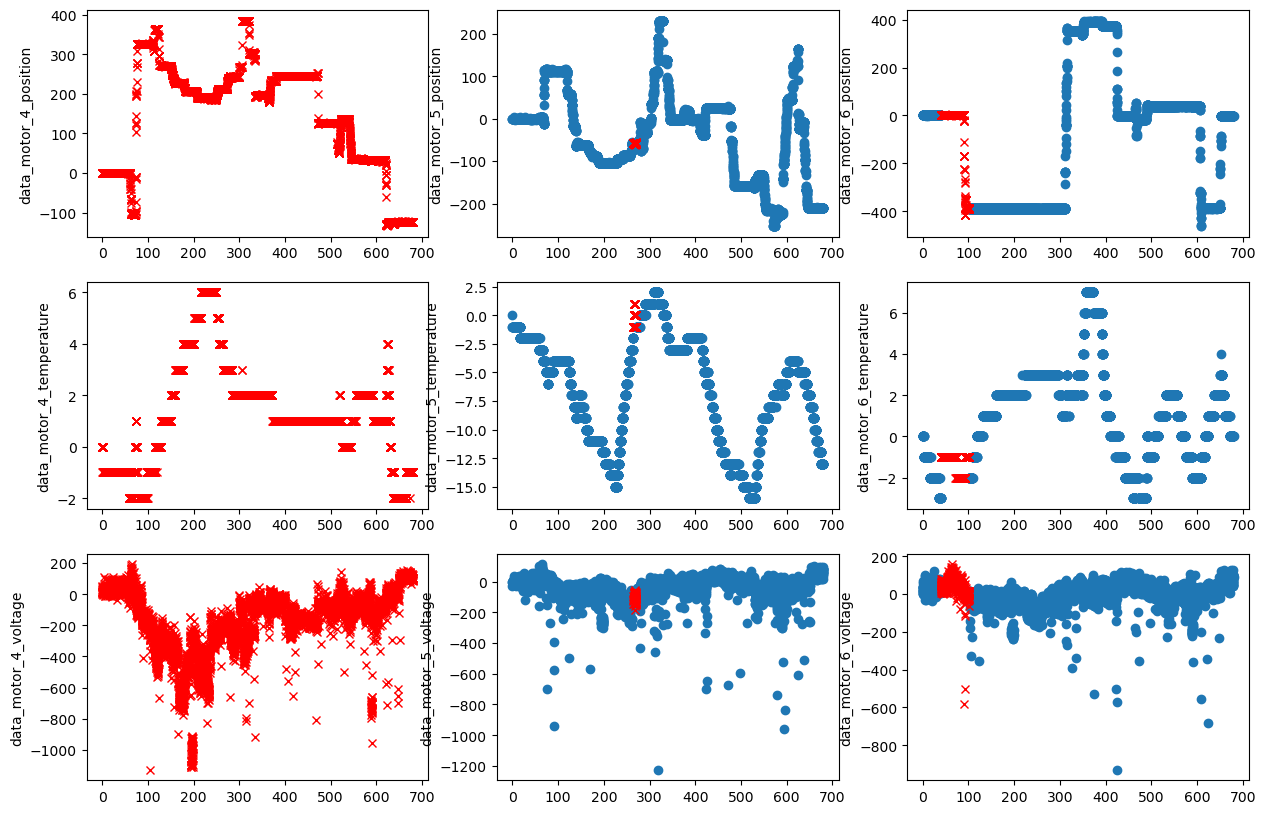

20240425_093699: 10    Not moving
Name: Description, dtype: object



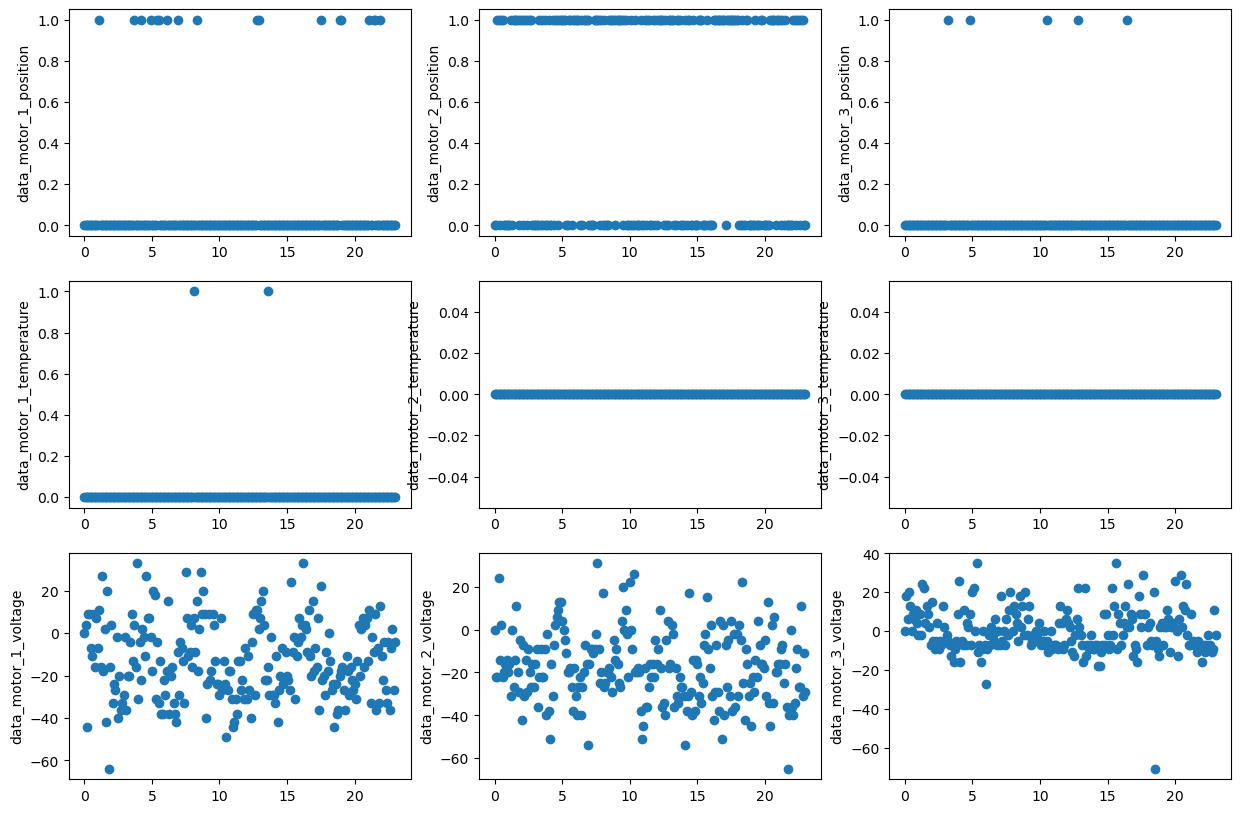

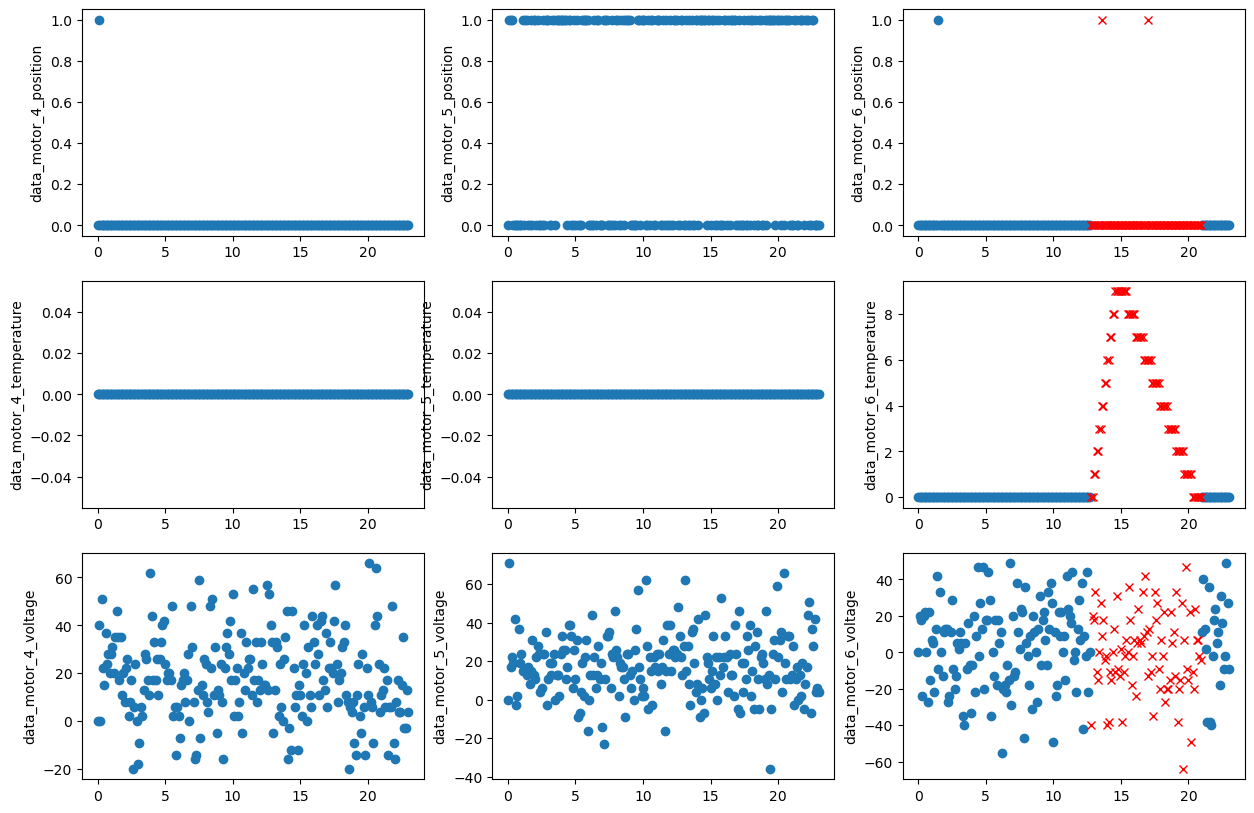

20240425_094425: 11    Not moving
Name: Description, dtype: object



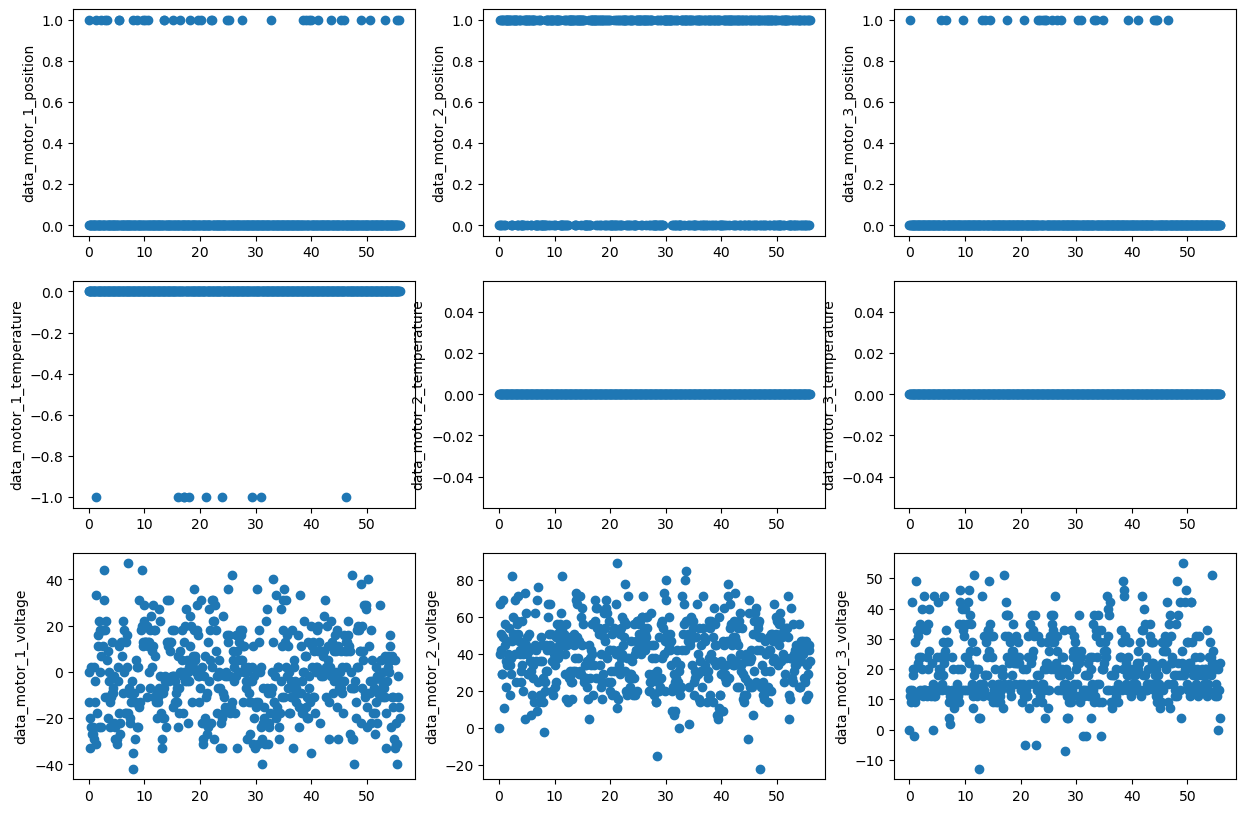

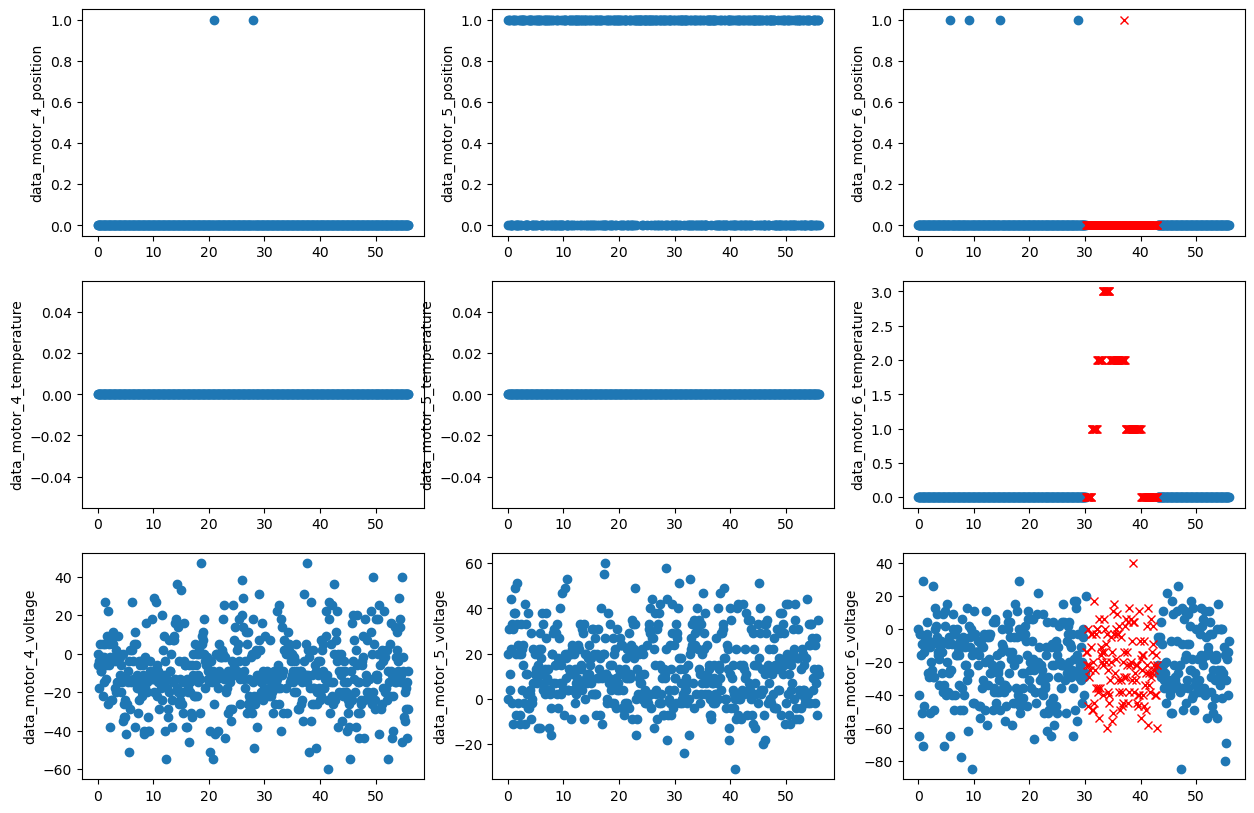

20240426_140055: 12    Not moving
Name: Description, dtype: object



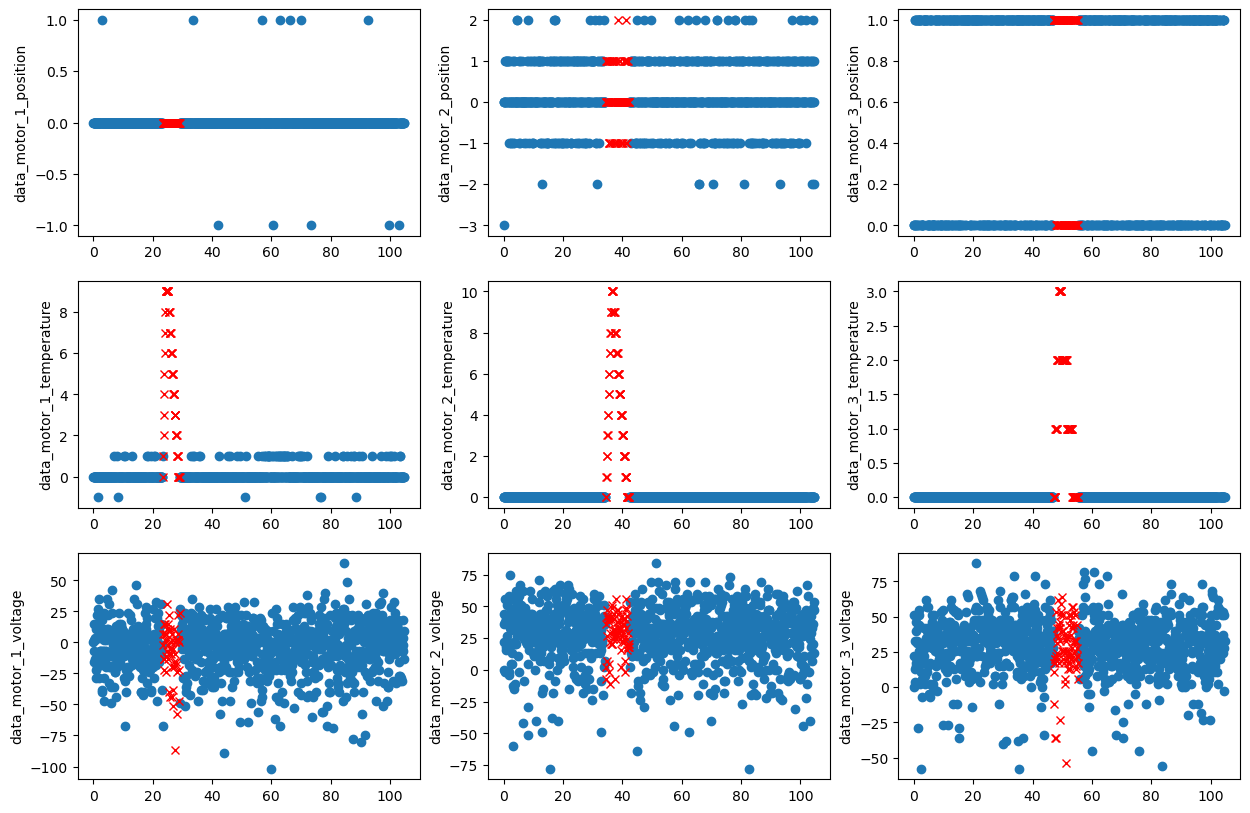

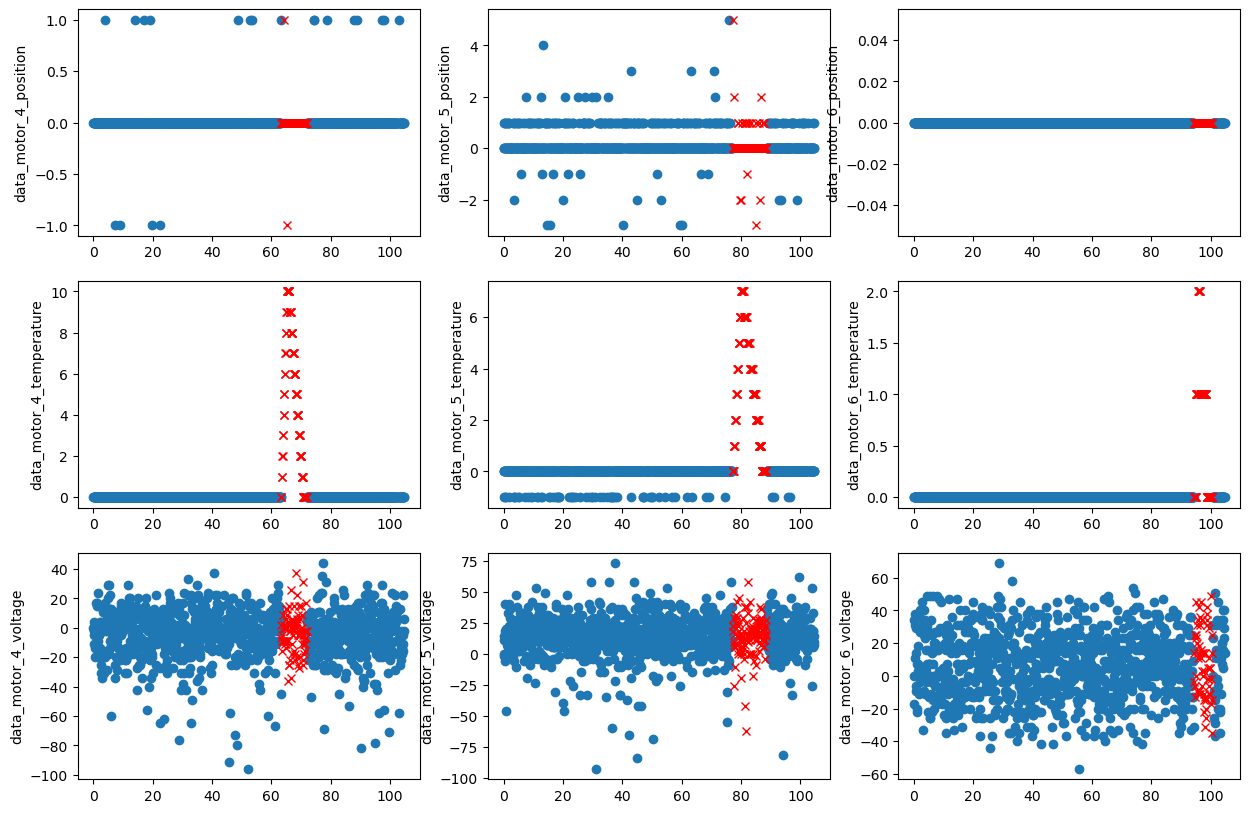

20240426_141190: 13    Pick up and place
Name: Description, dtype: object



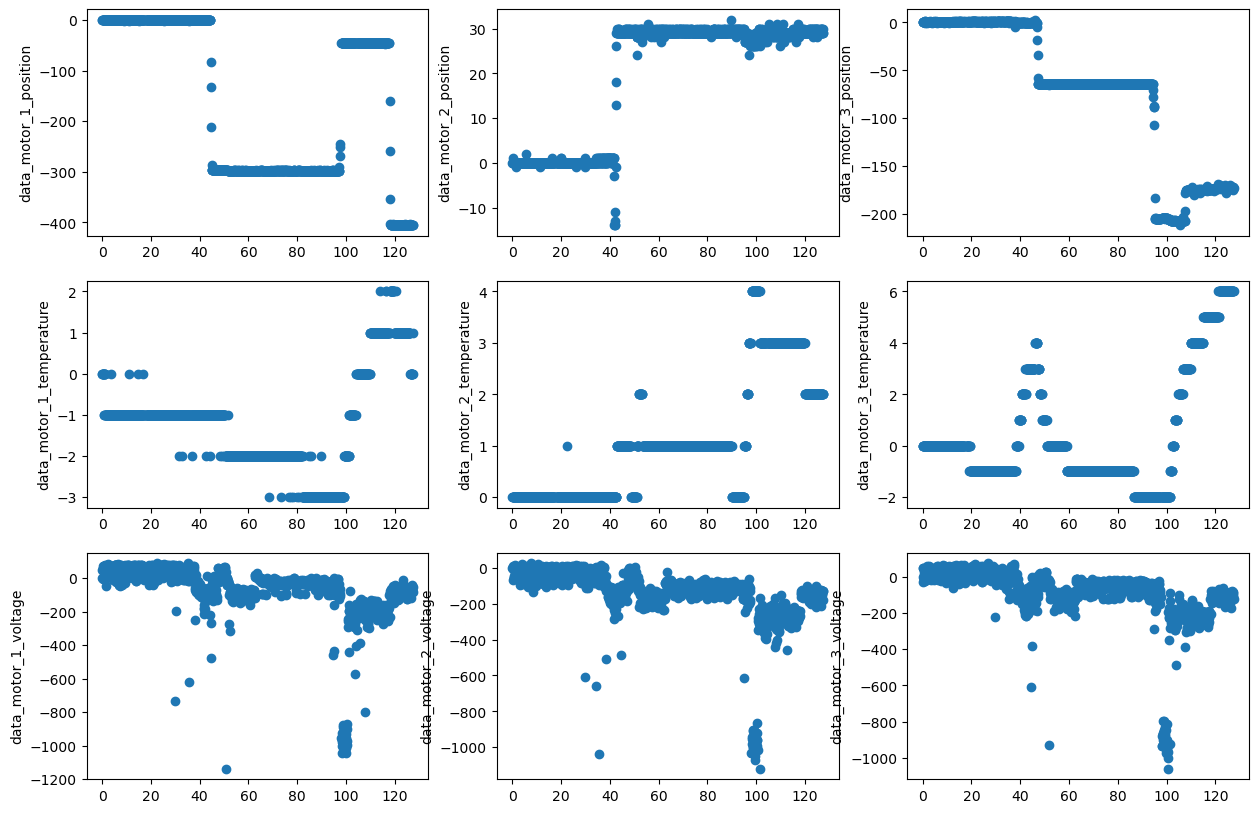

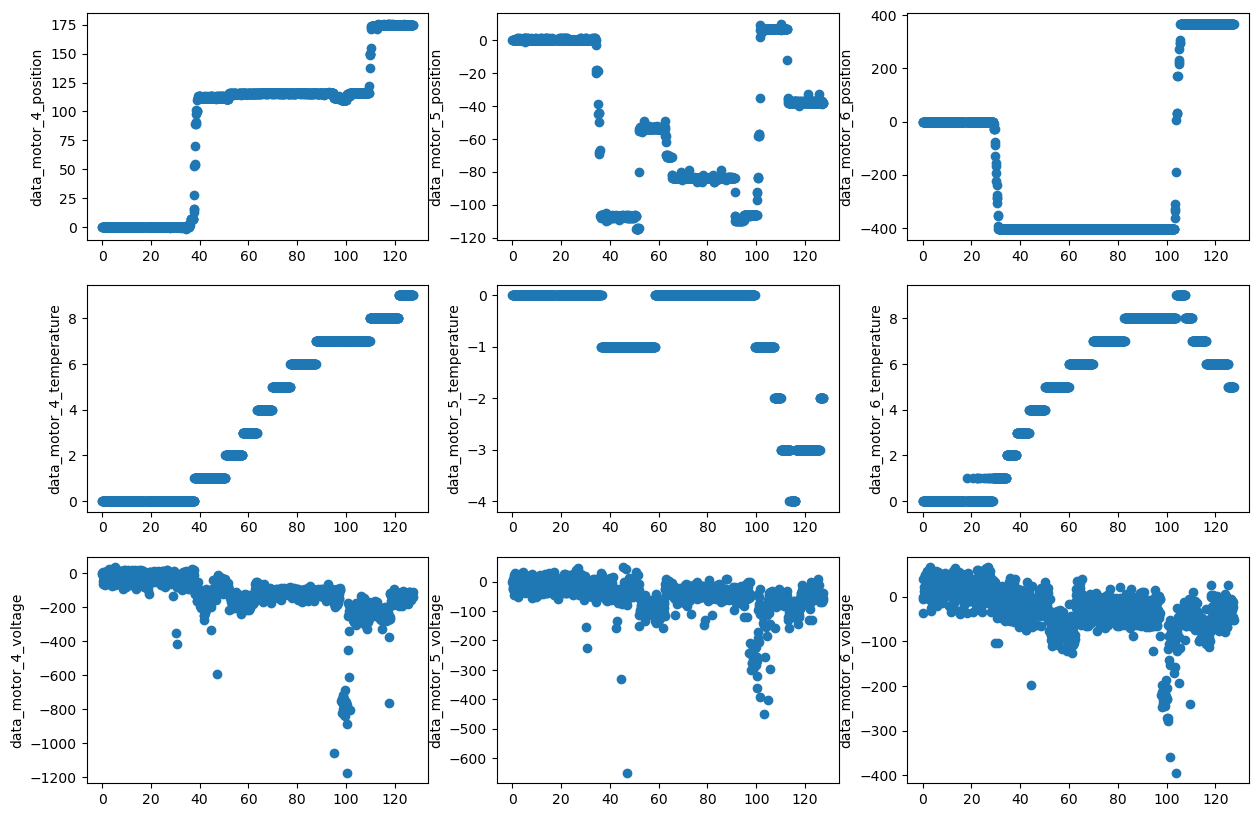

20240426_141532: 14    Moving one motor
Name: Description, dtype: object



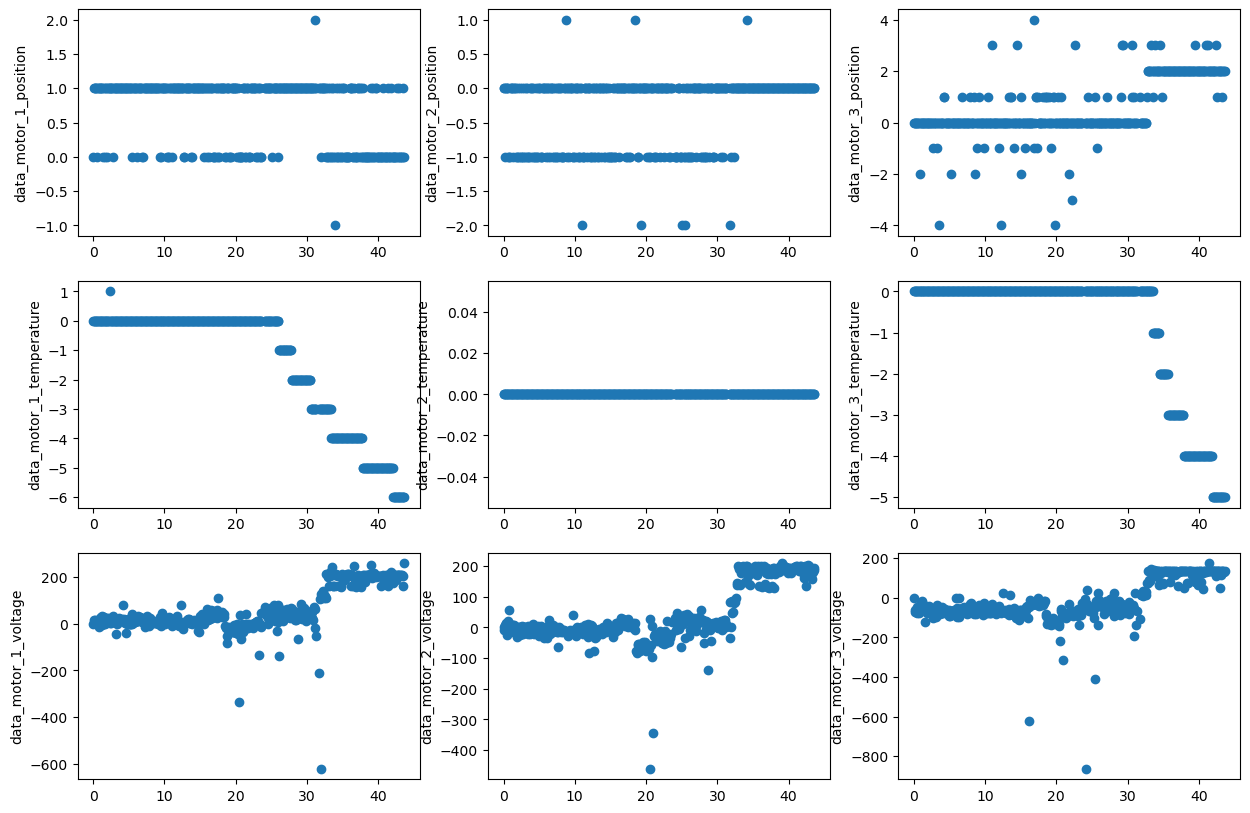

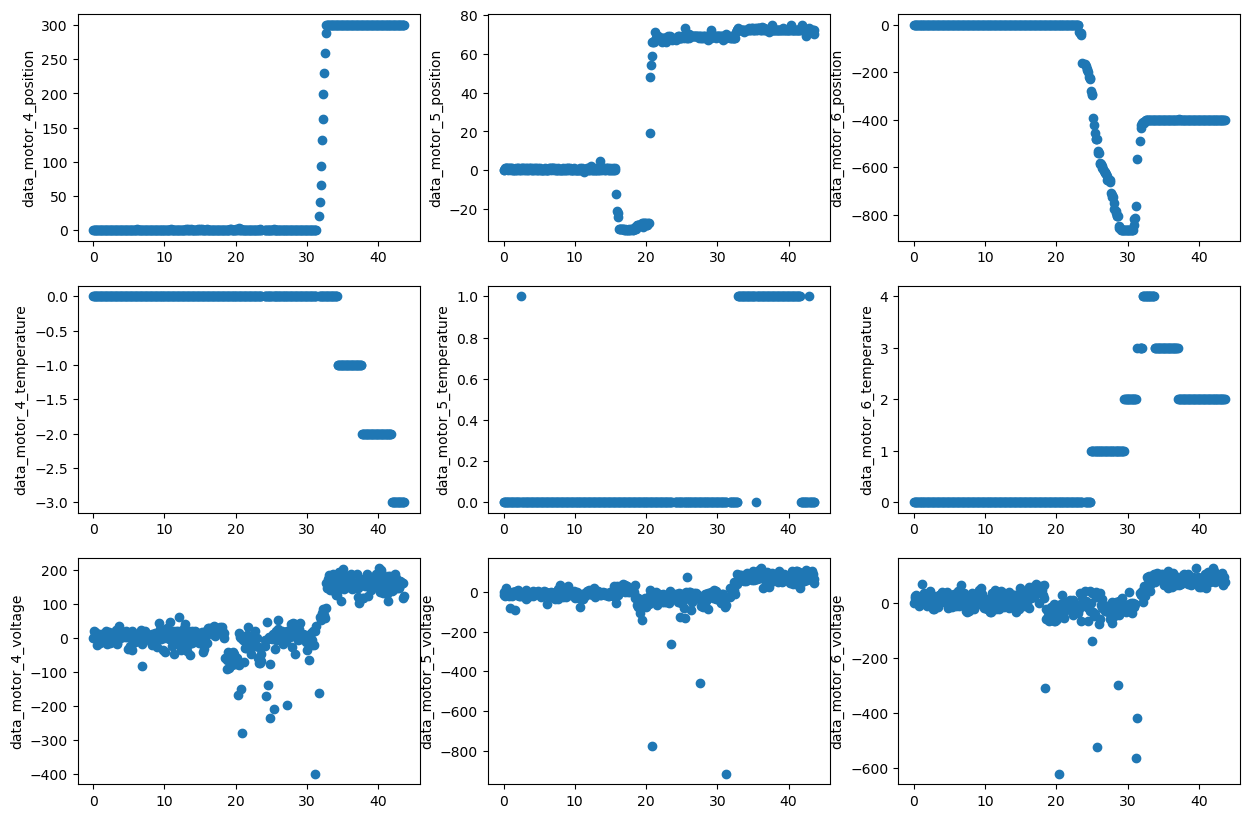

20240426_141602: 15    Moving one motor
Name: Description, dtype: object



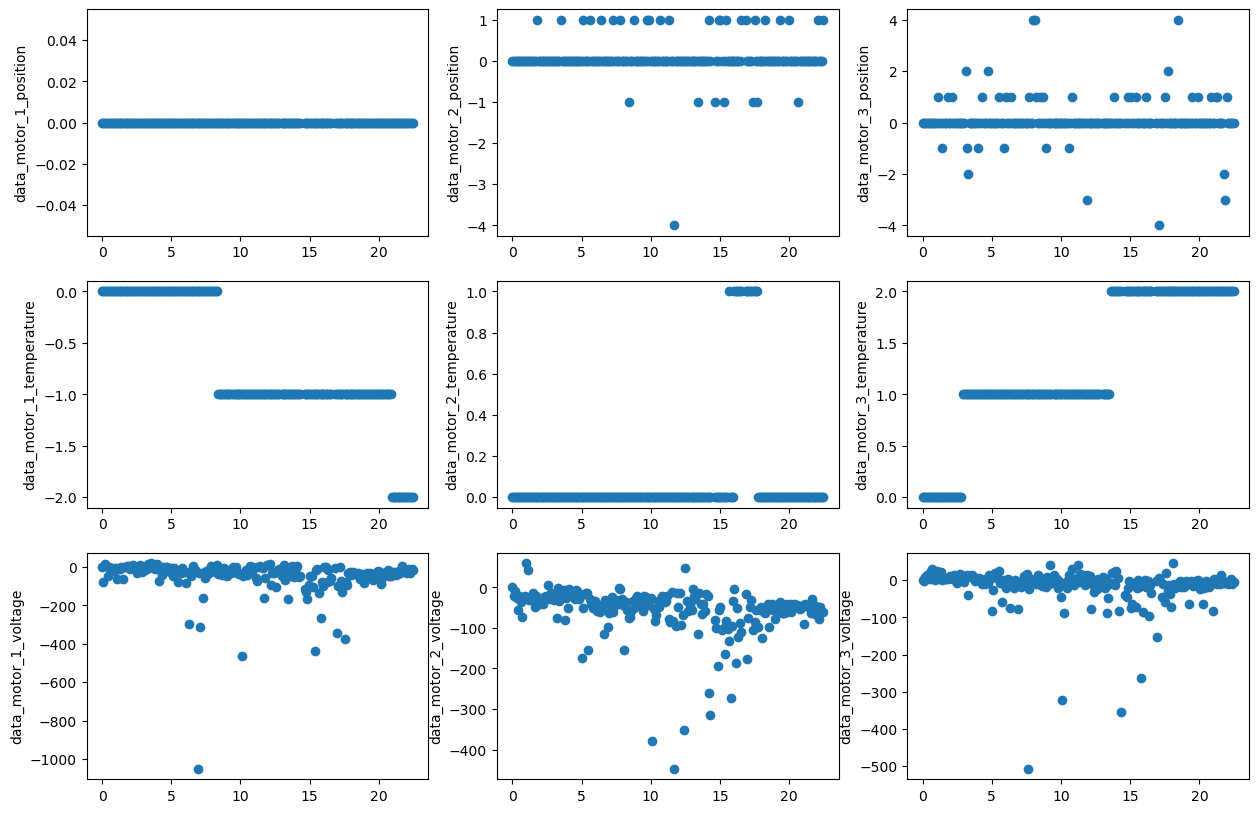

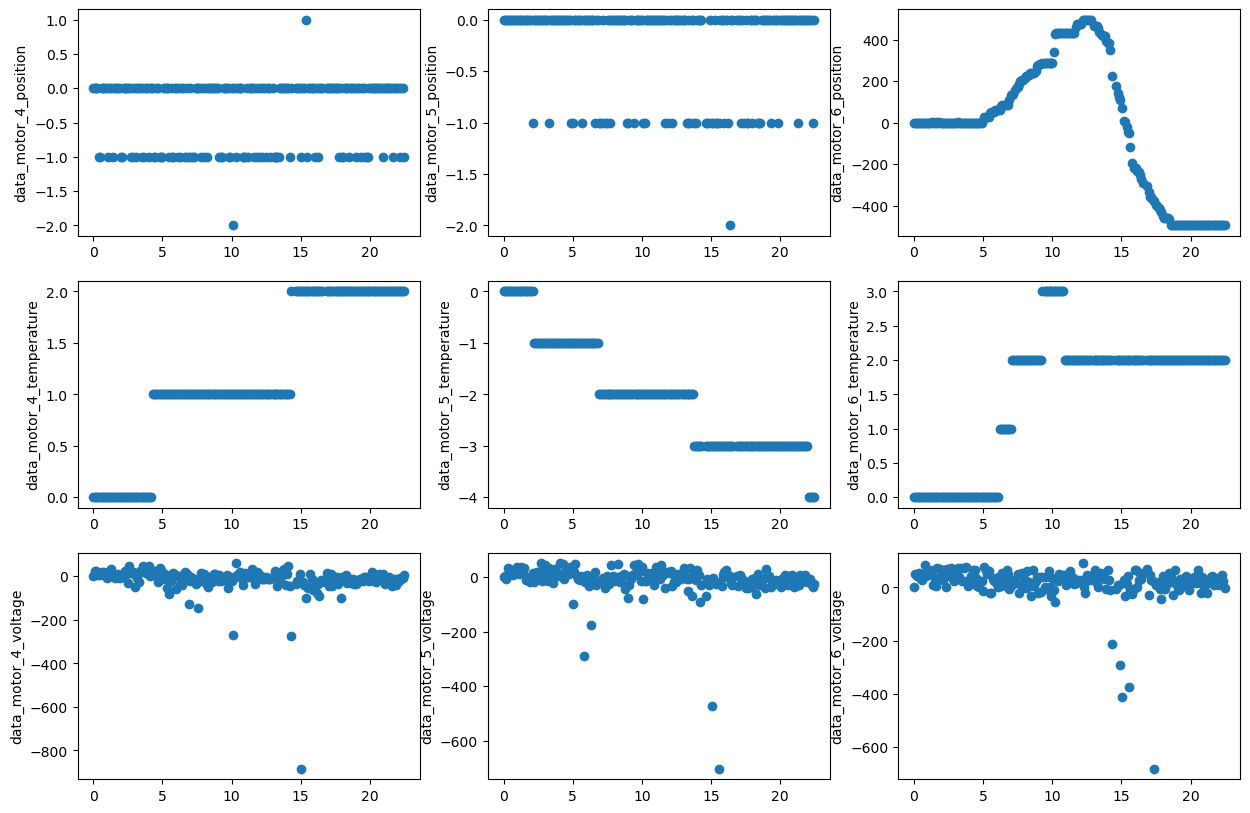

20240426_141726: 16    Moving one motor
Name: Description, dtype: object



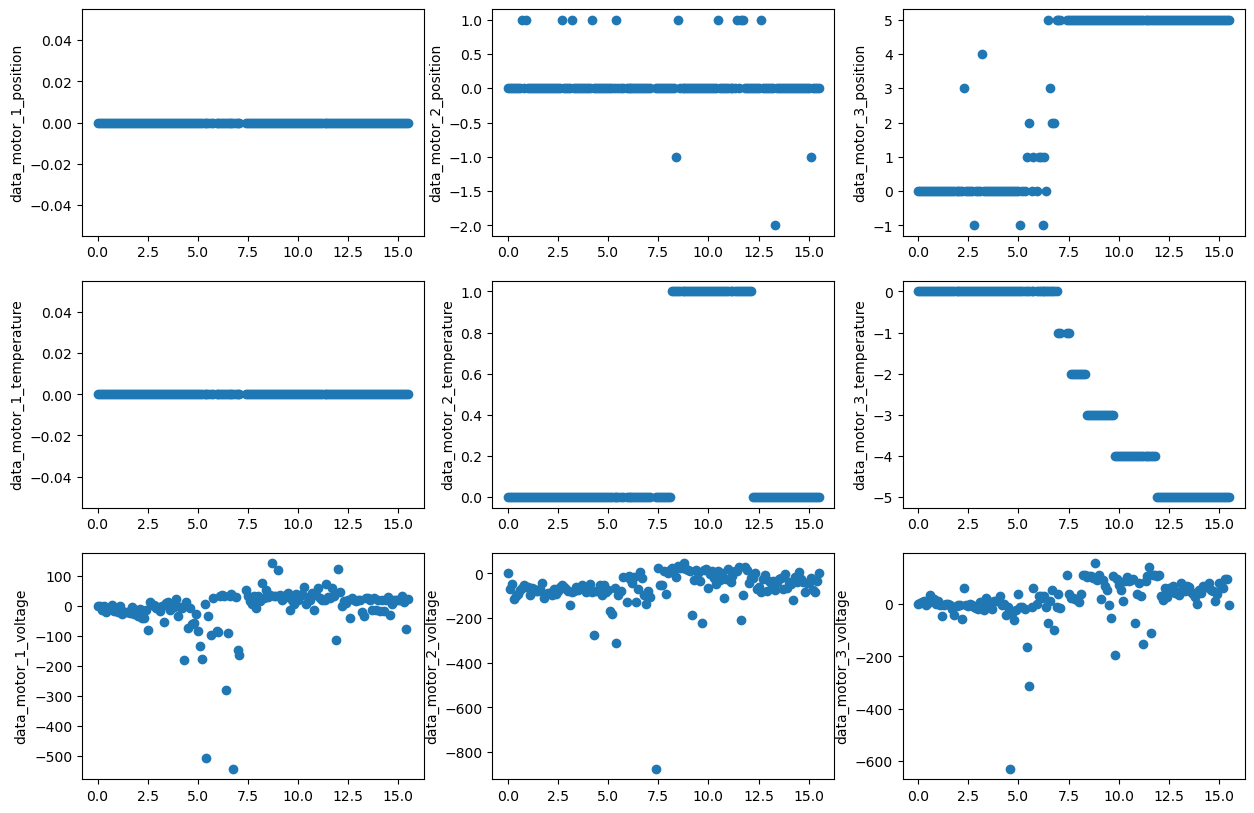

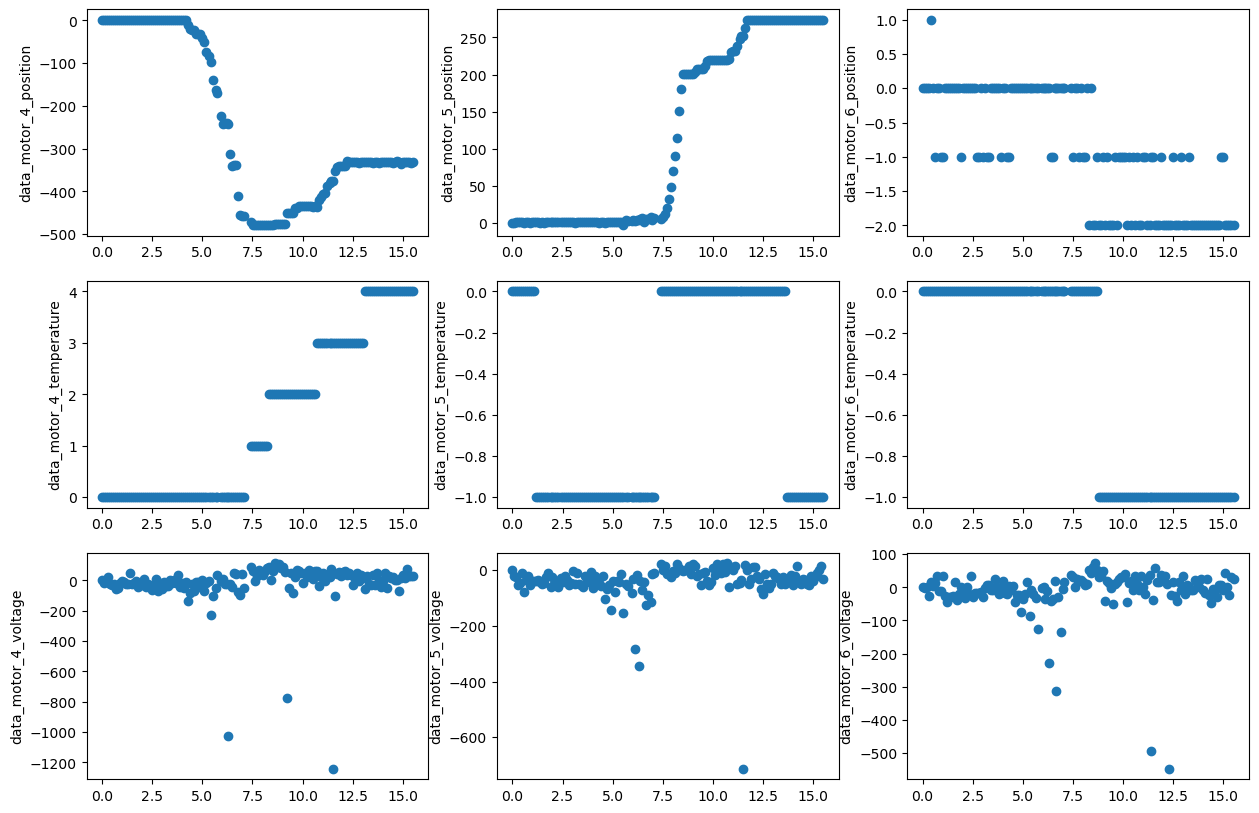

20240426_141938: 17    Moving one motor
Name: Description, dtype: object



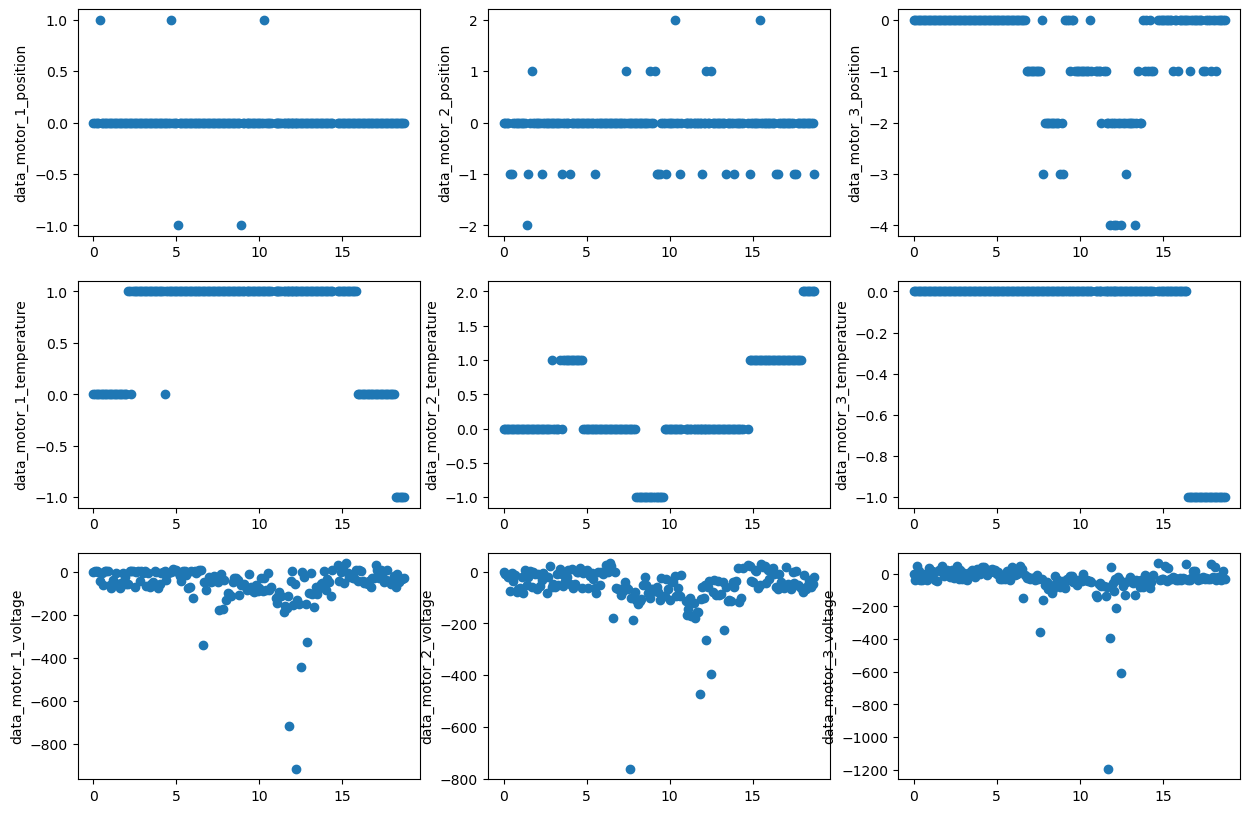

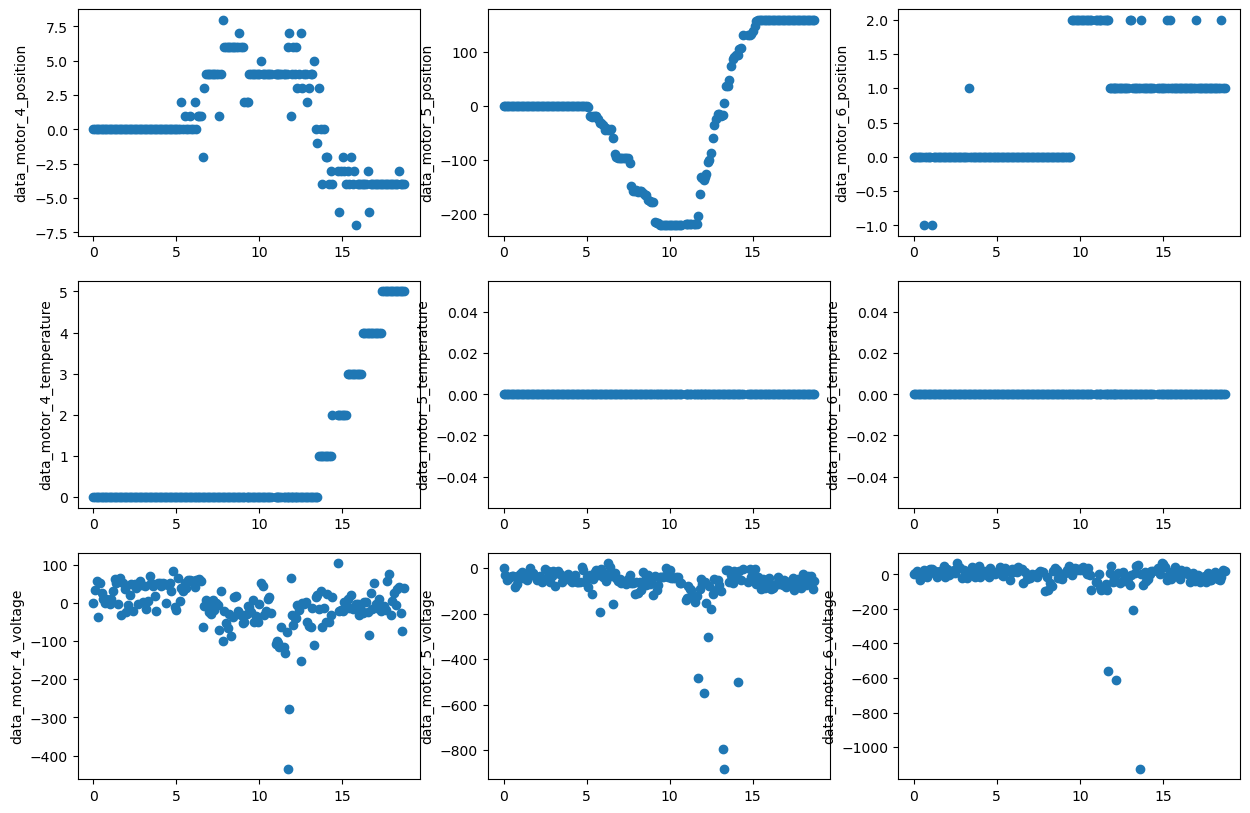

20240426_141980: 18    Moving one motor
Name: Description, dtype: object



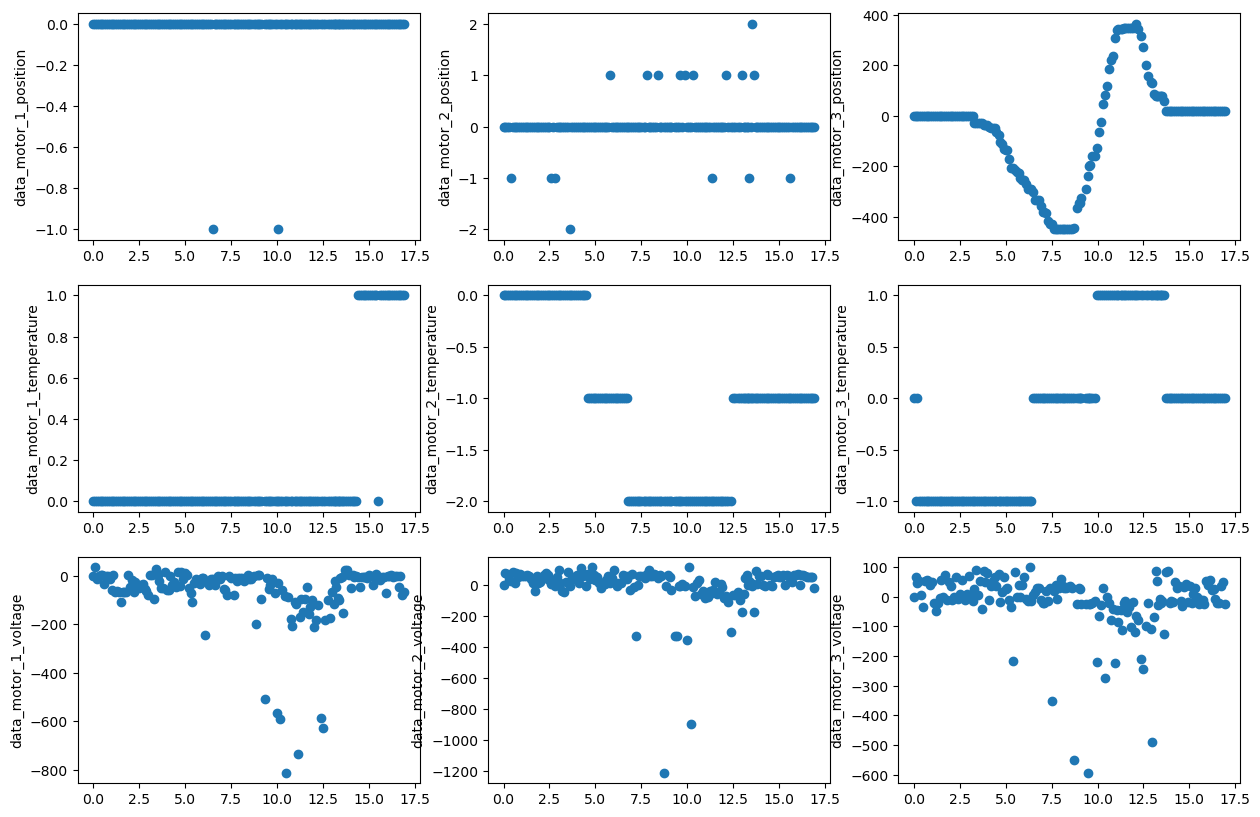

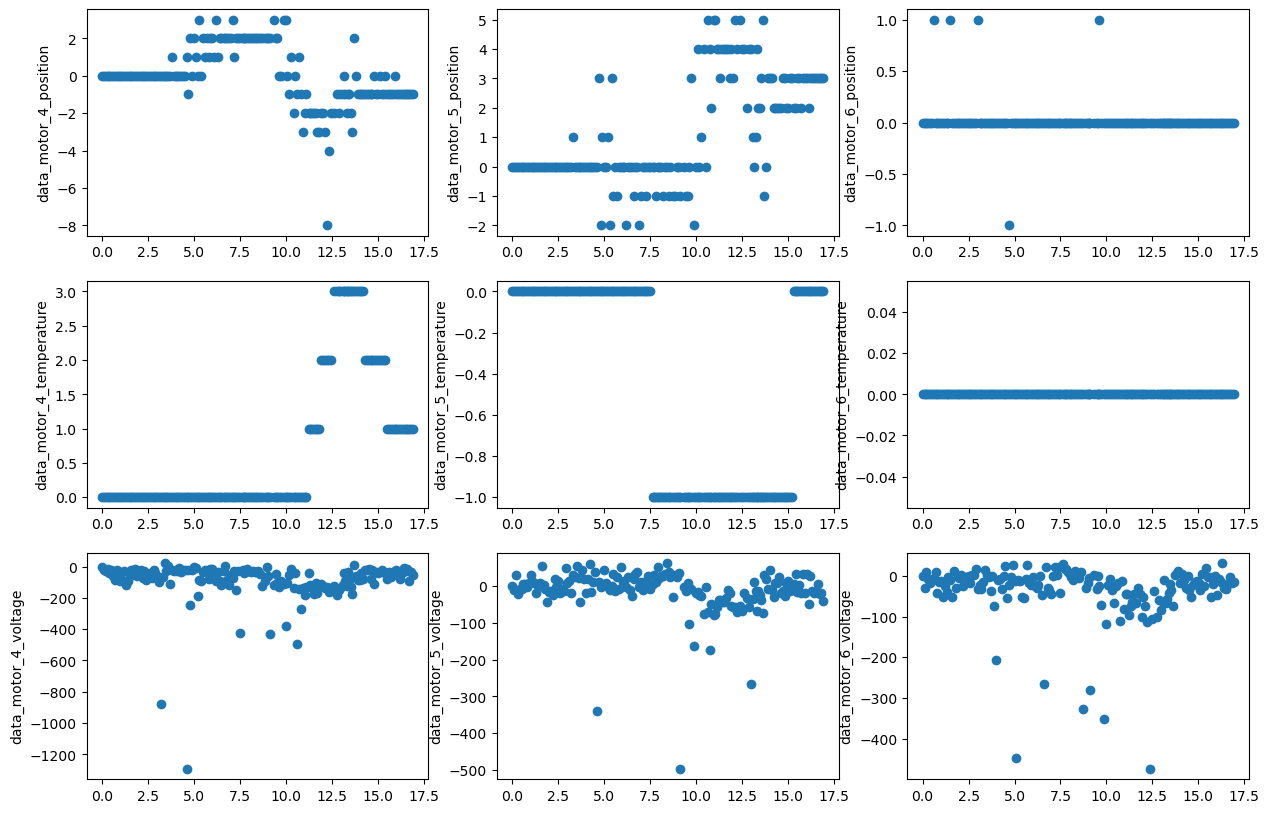

20240503_163963: 19    Pick up and place
Name: Description, dtype: object



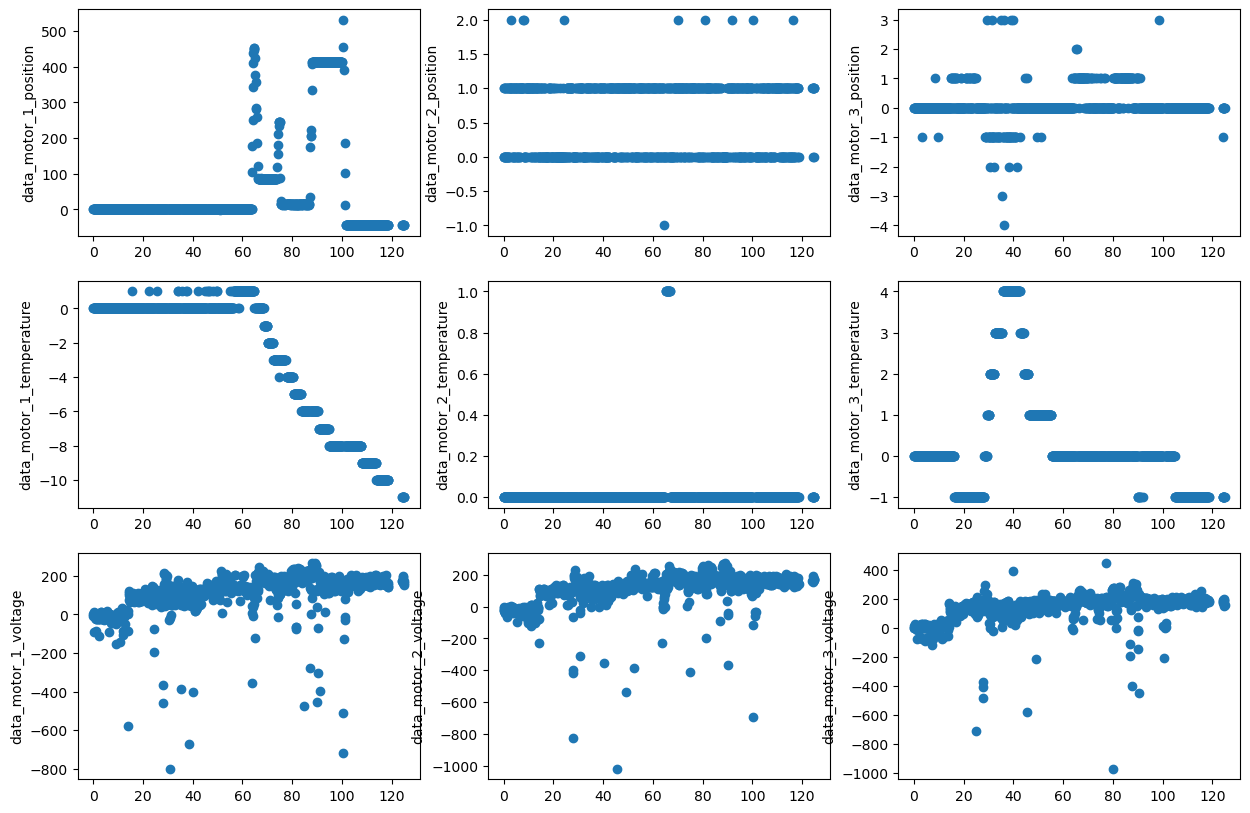

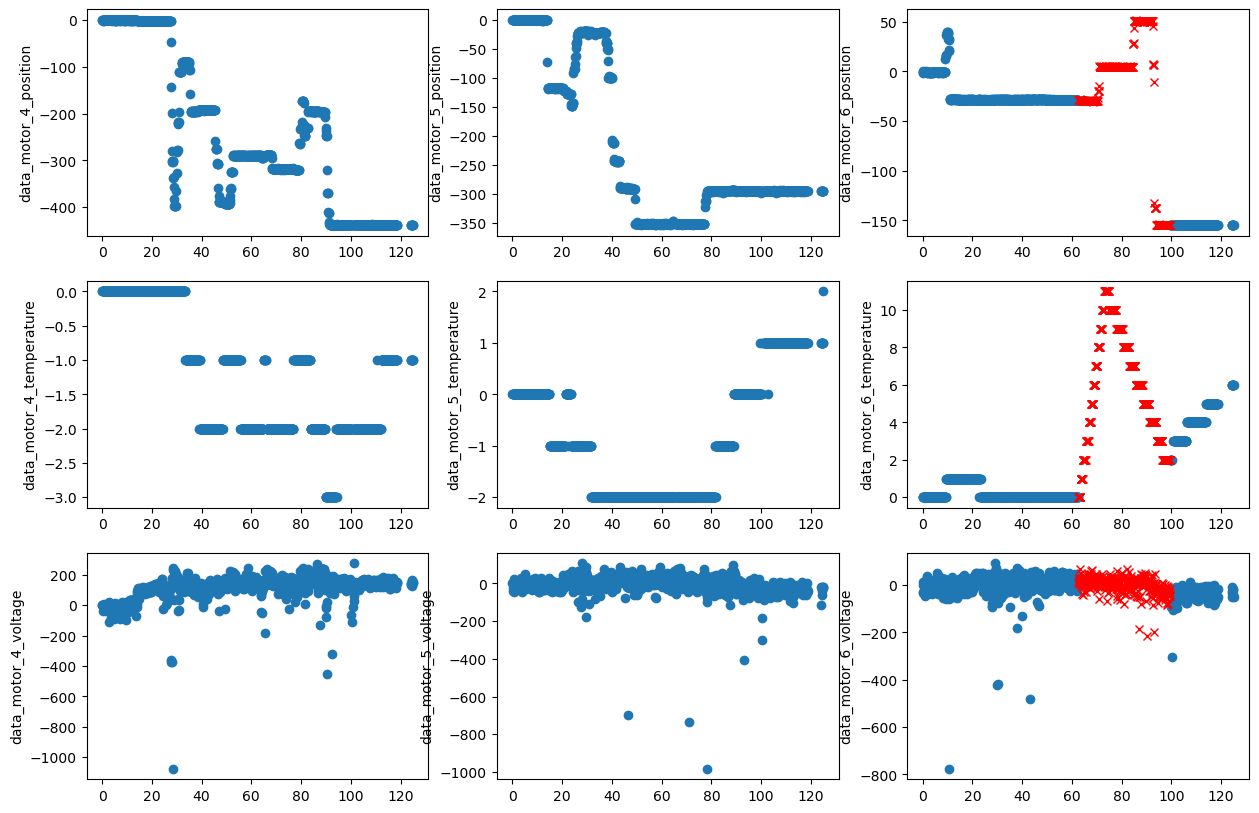

20240503_164435: 20    Turning motor 6
Name: Description, dtype: object



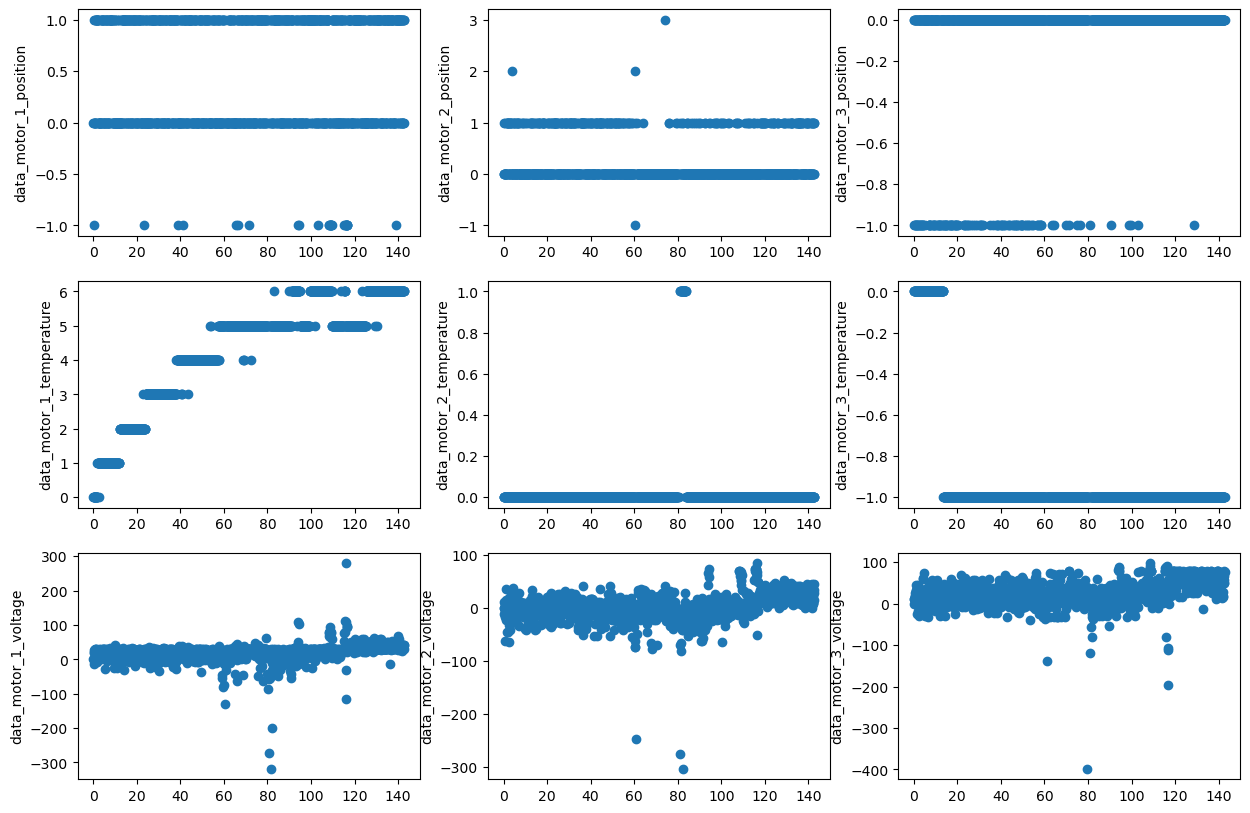

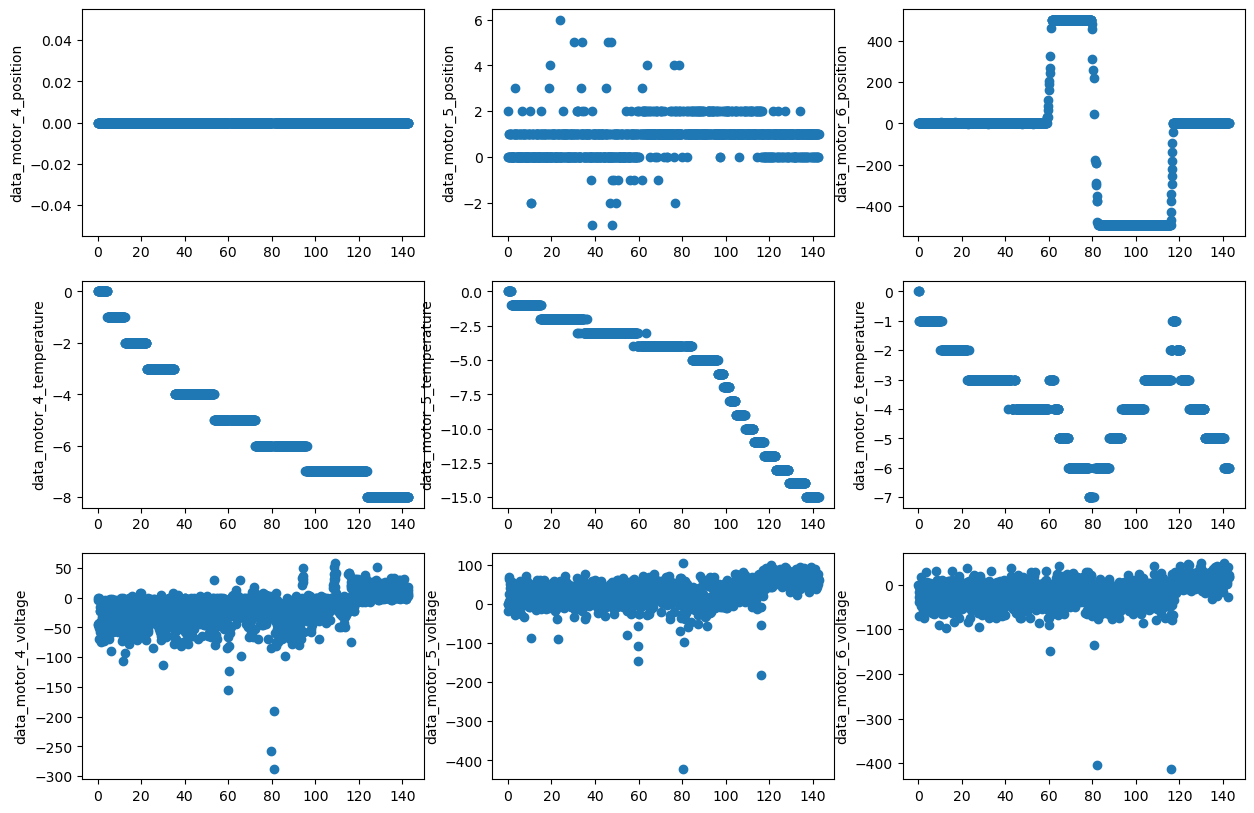

20240503_164675: 21    Turning motor 6
Name: Description, dtype: object



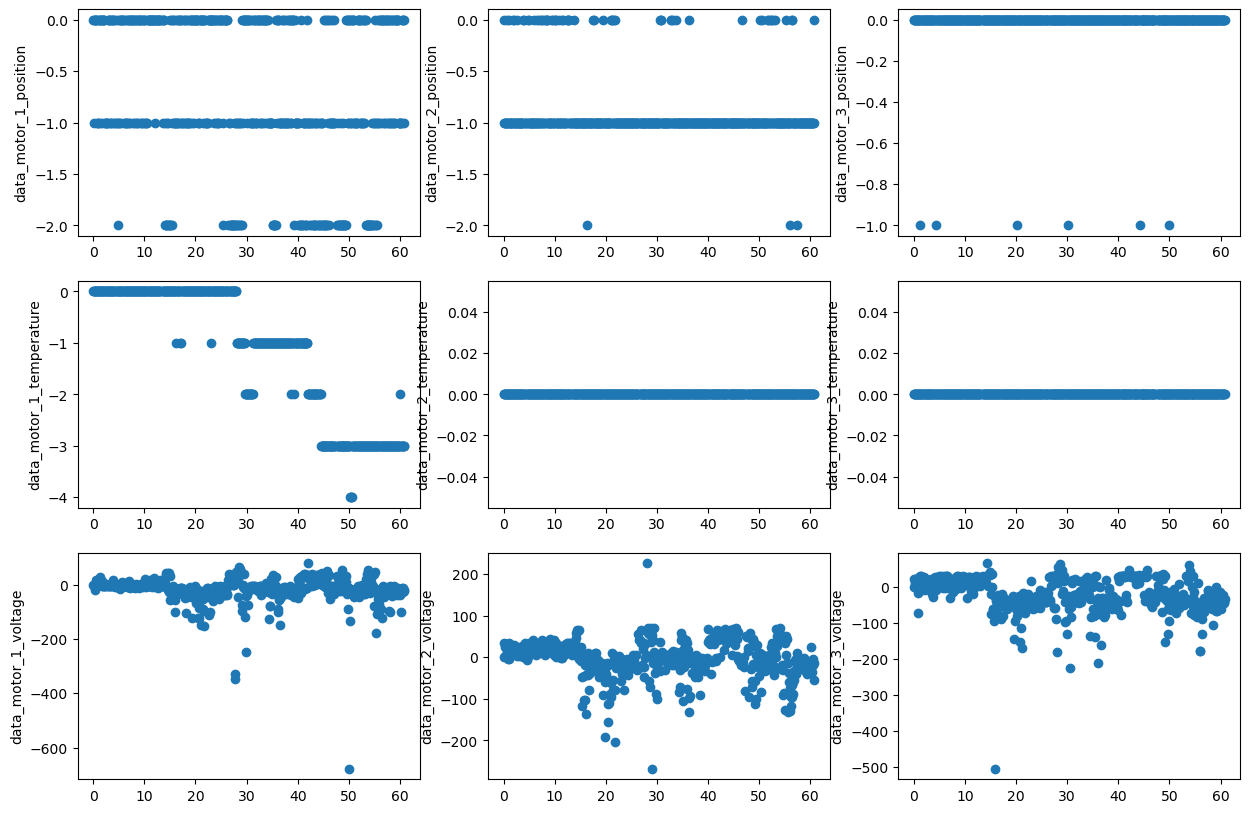

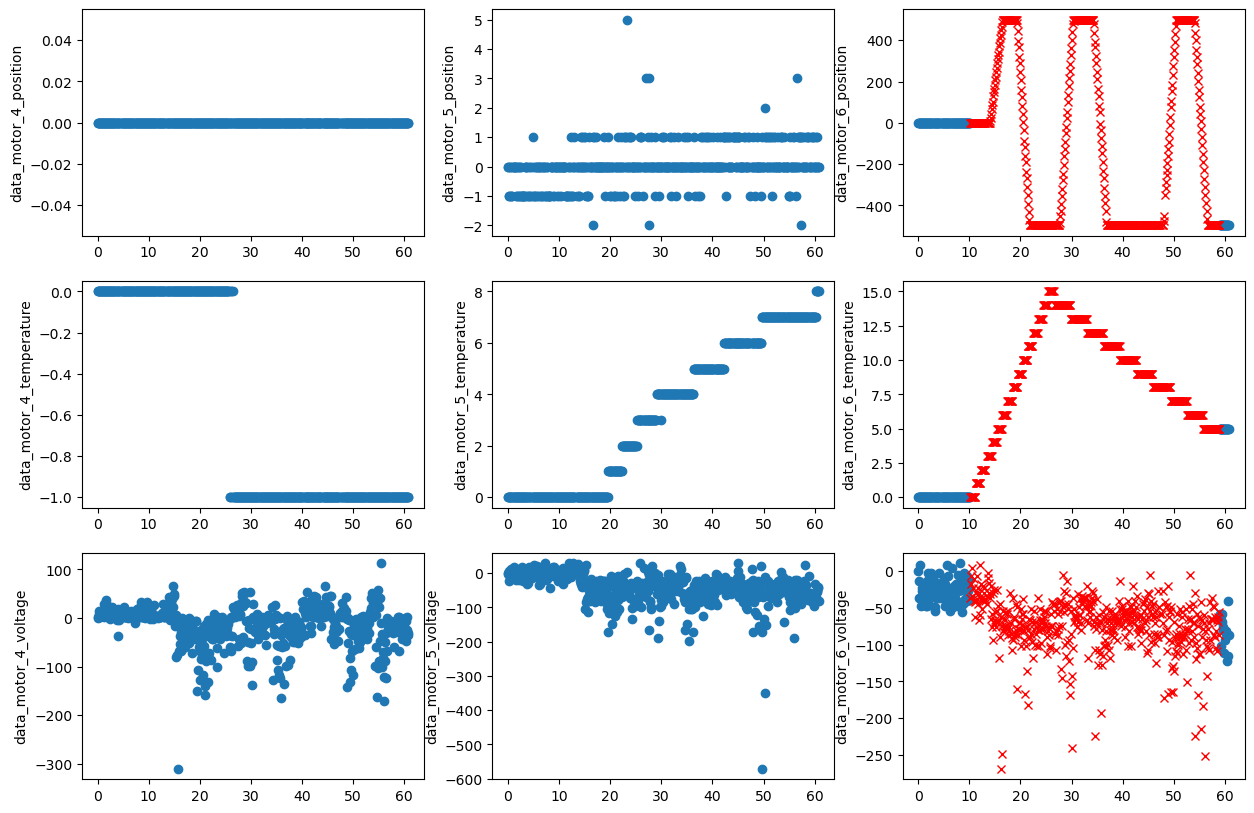

20240503_165189: 22    Turning motor 6
Name: Description, dtype: object



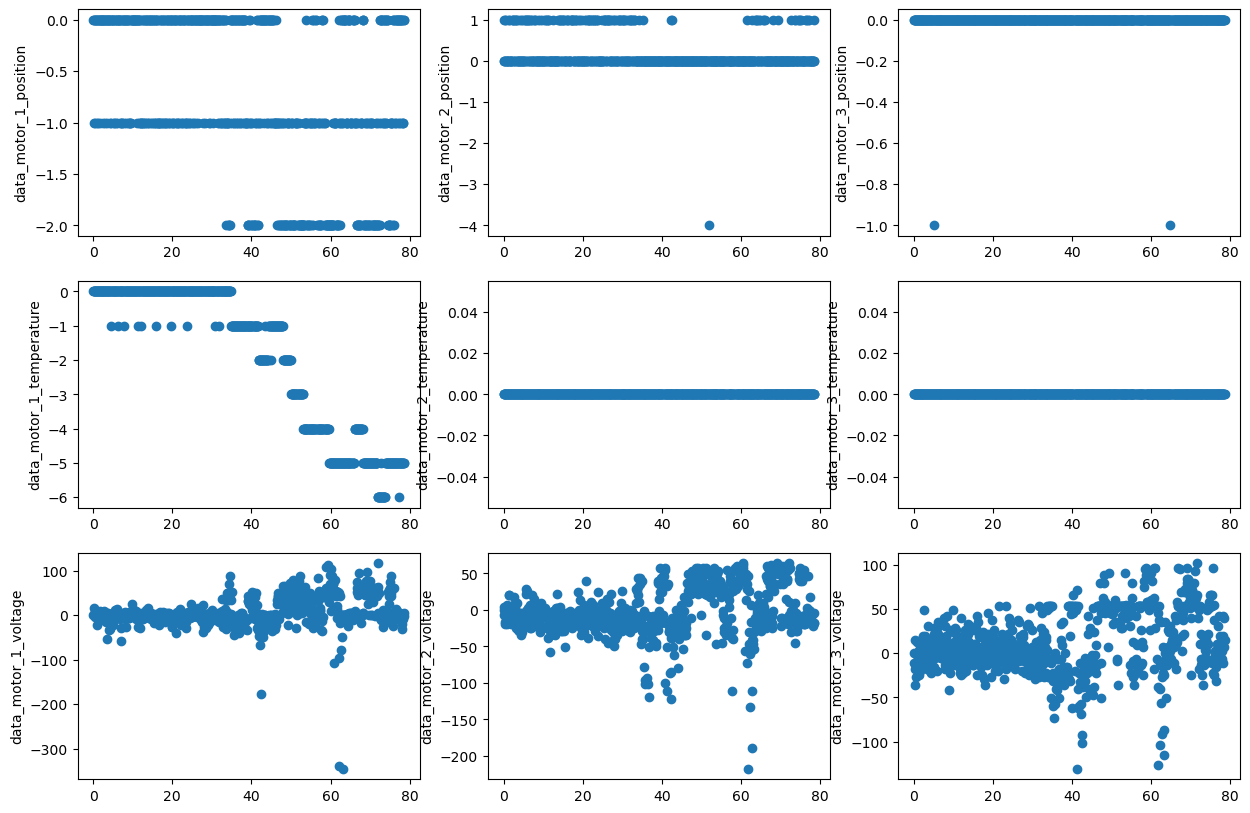

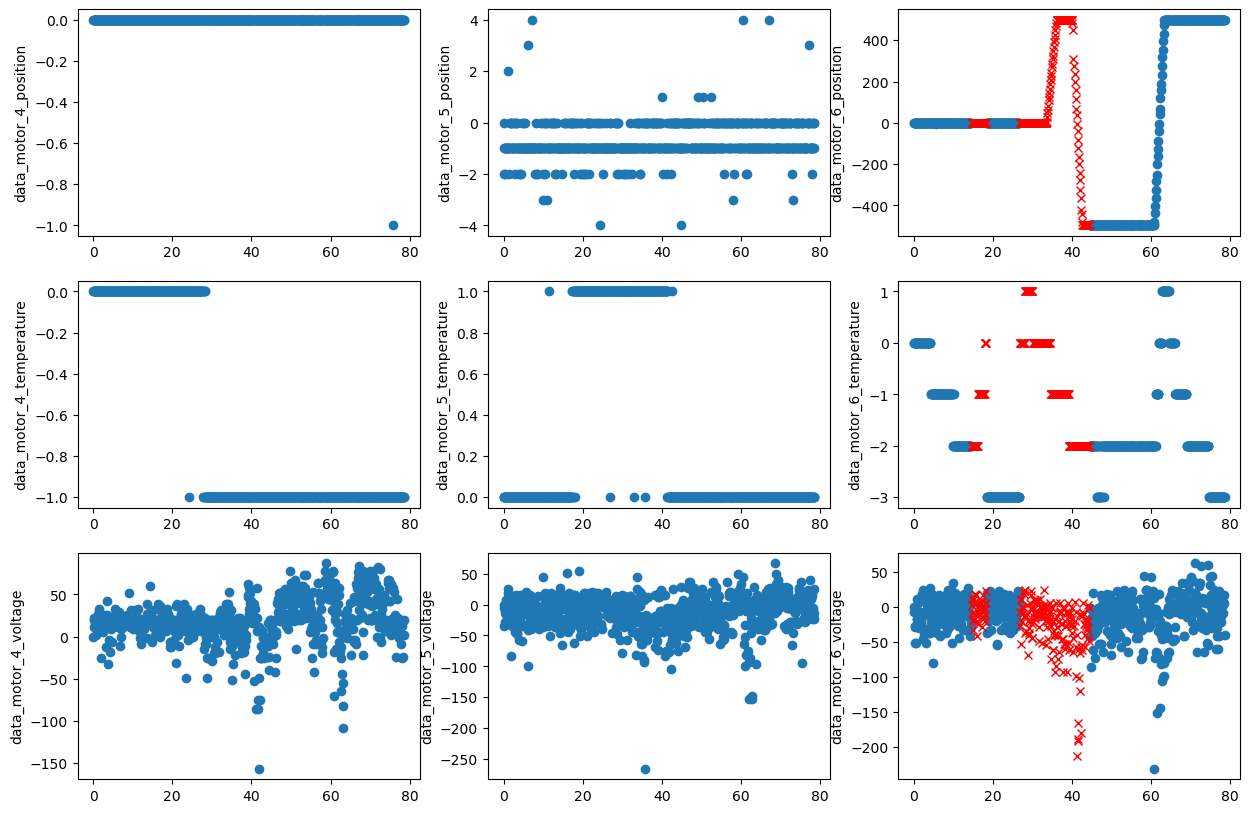

In [21]:
# Ignore warnings.
warnings.filterwarnings('ignore')

# Read all the dataset. Change to your dictionary if needed.
base_dictionary = '../../dataset/training_data/training_data/'
df_train = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=True)

### Testing data.

20240527_094865: 0    Transfer goods
Name: Description, dtype: object



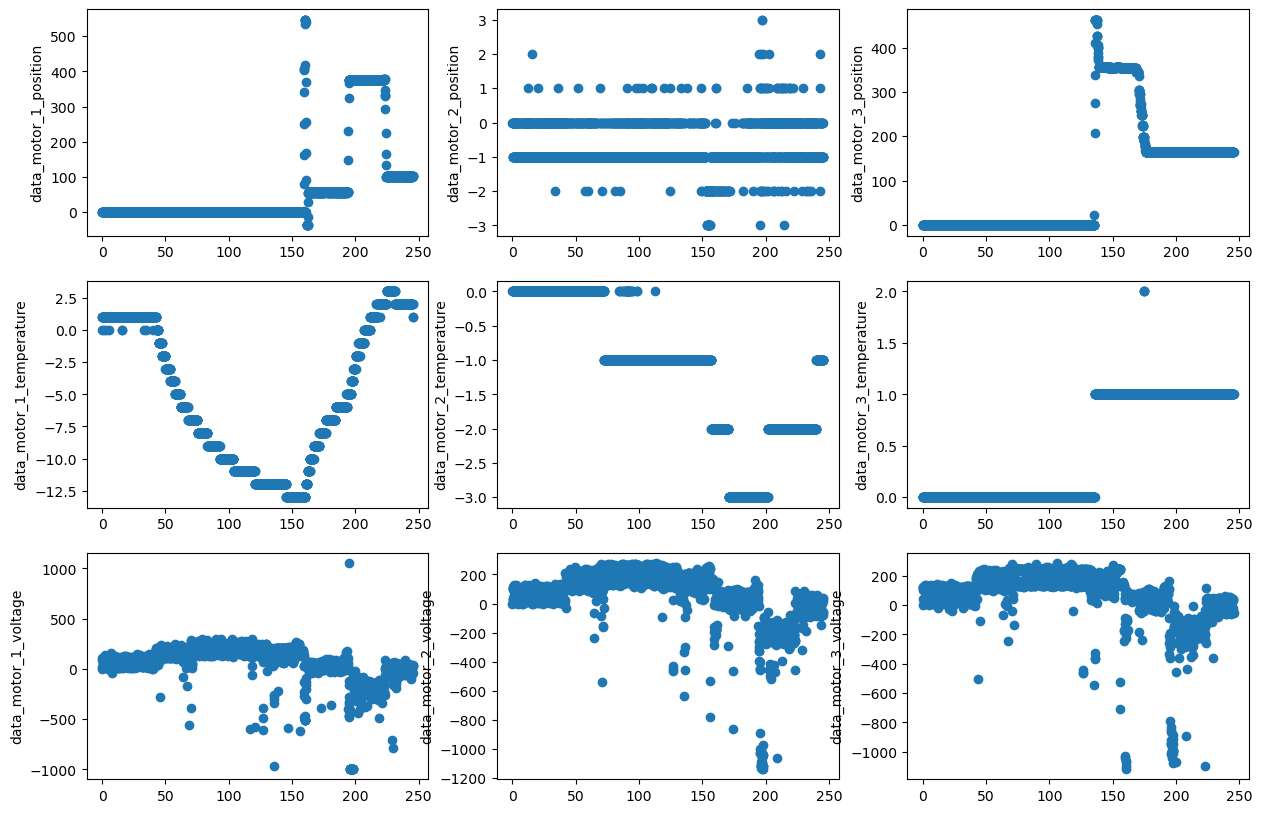

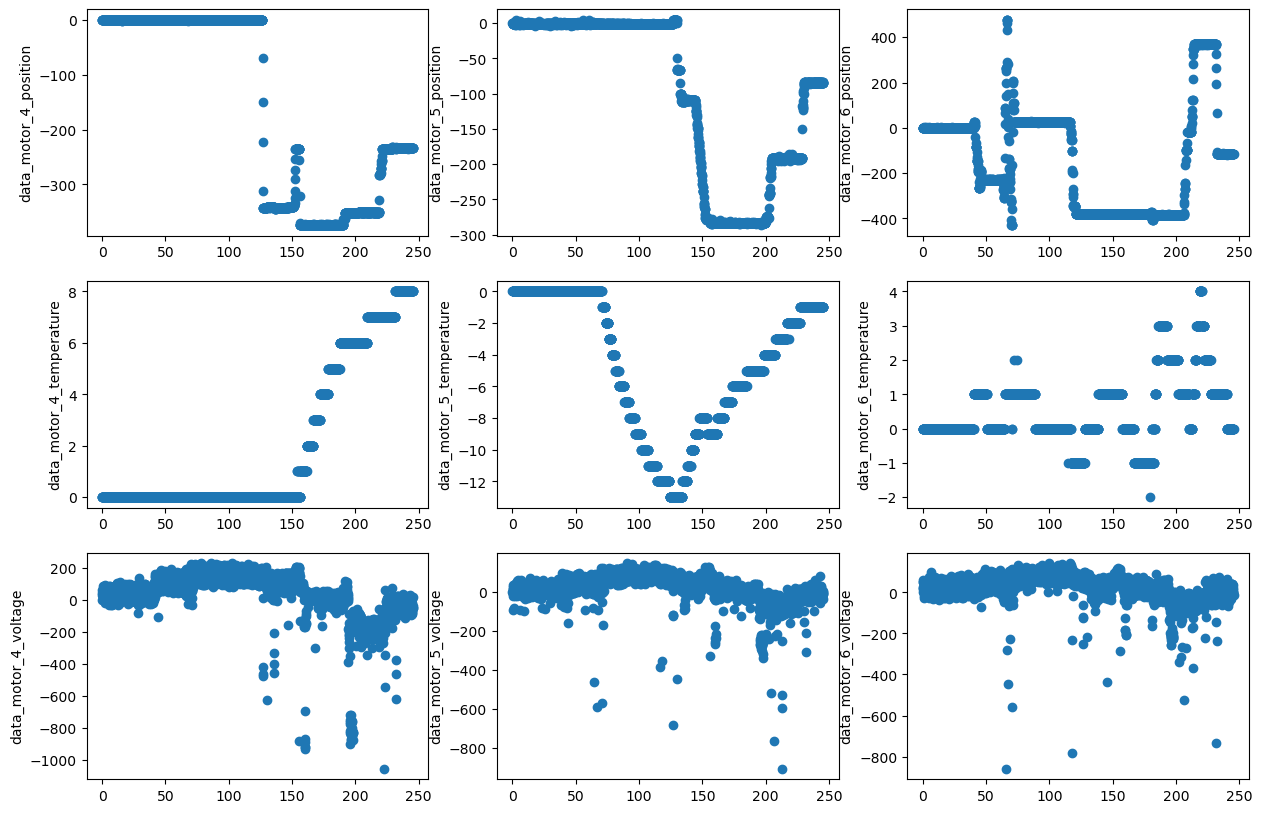

20240527_100759: 1    Transfer goods
Name: Description, dtype: object



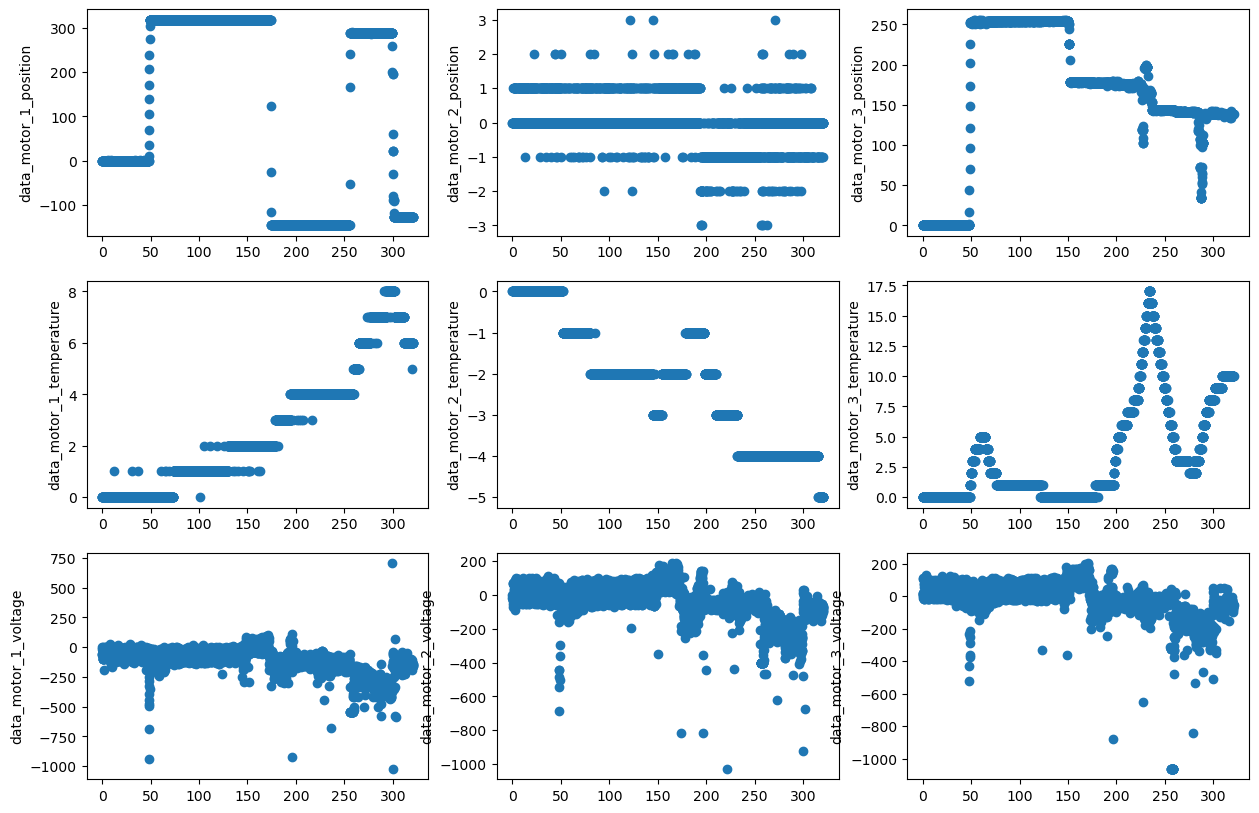

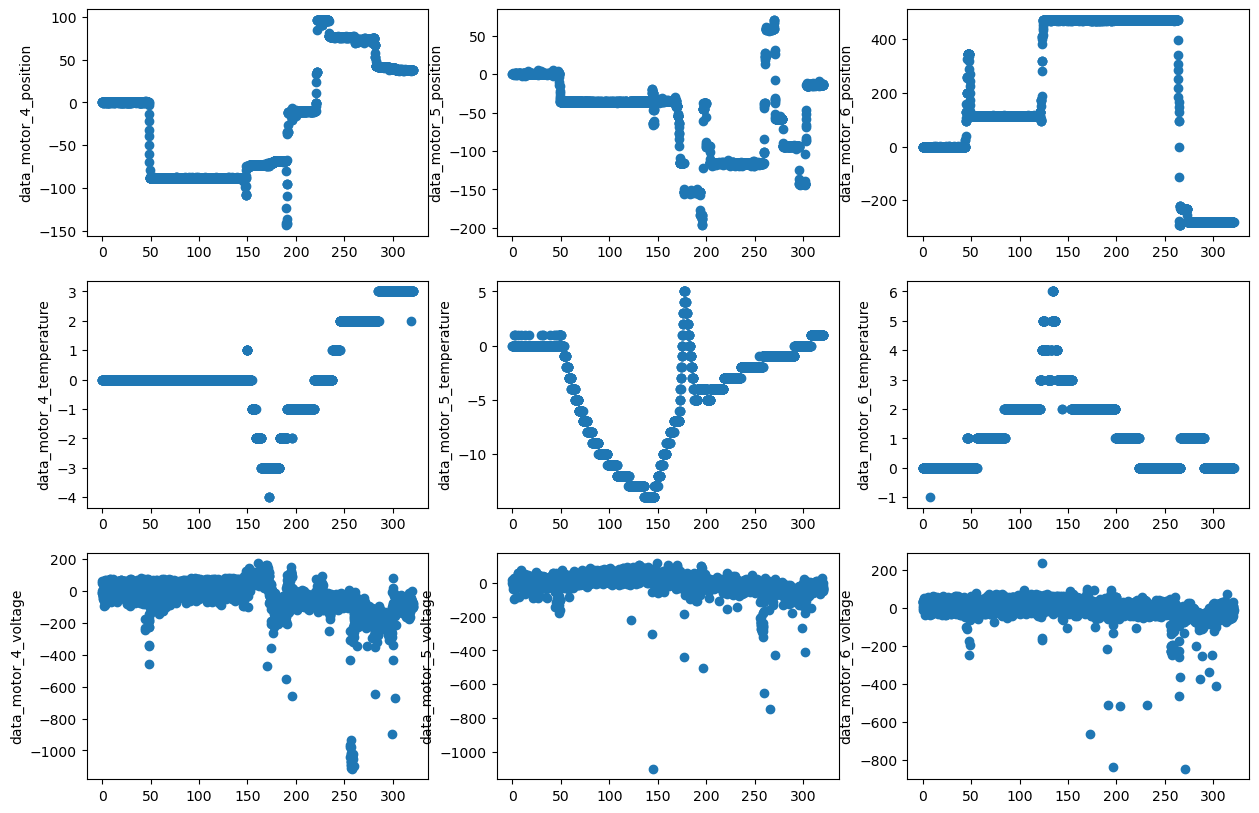

20240527_101627: 2    Transfer goods
Name: Description, dtype: object



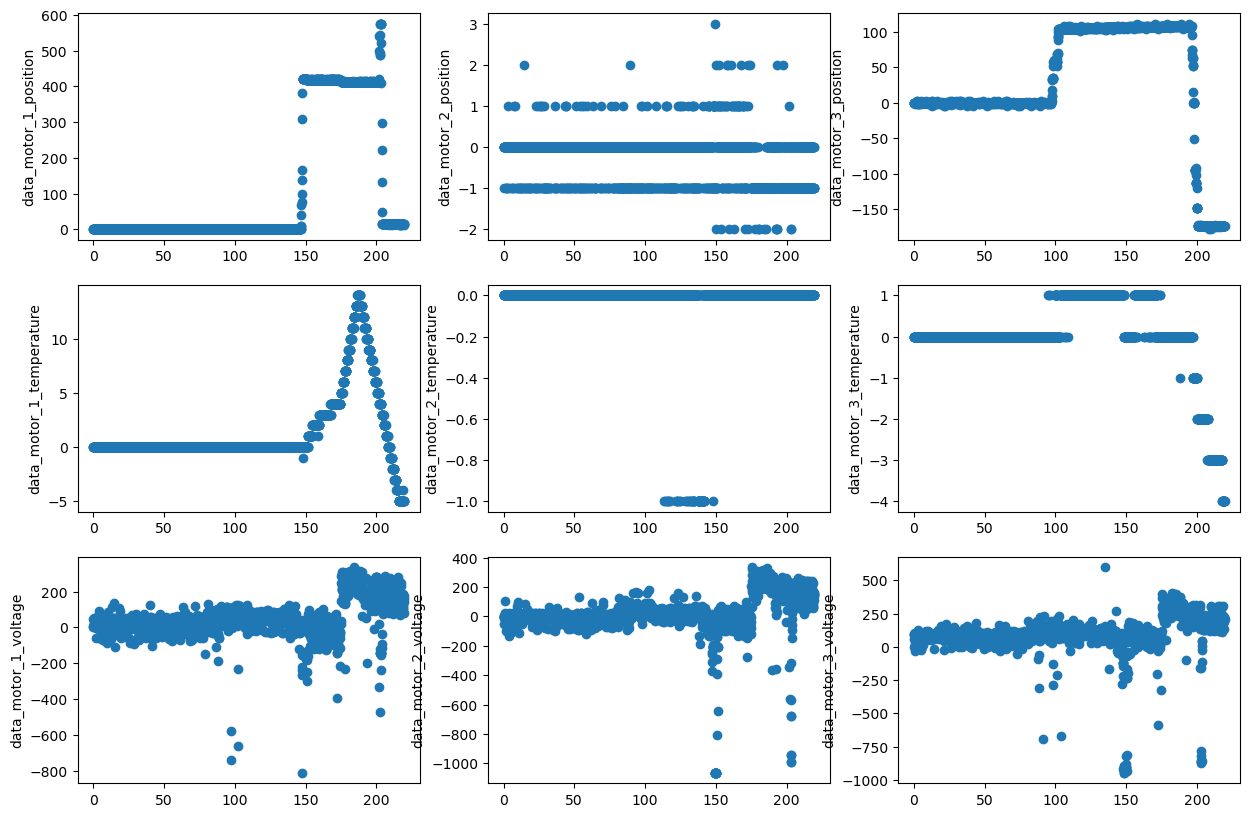

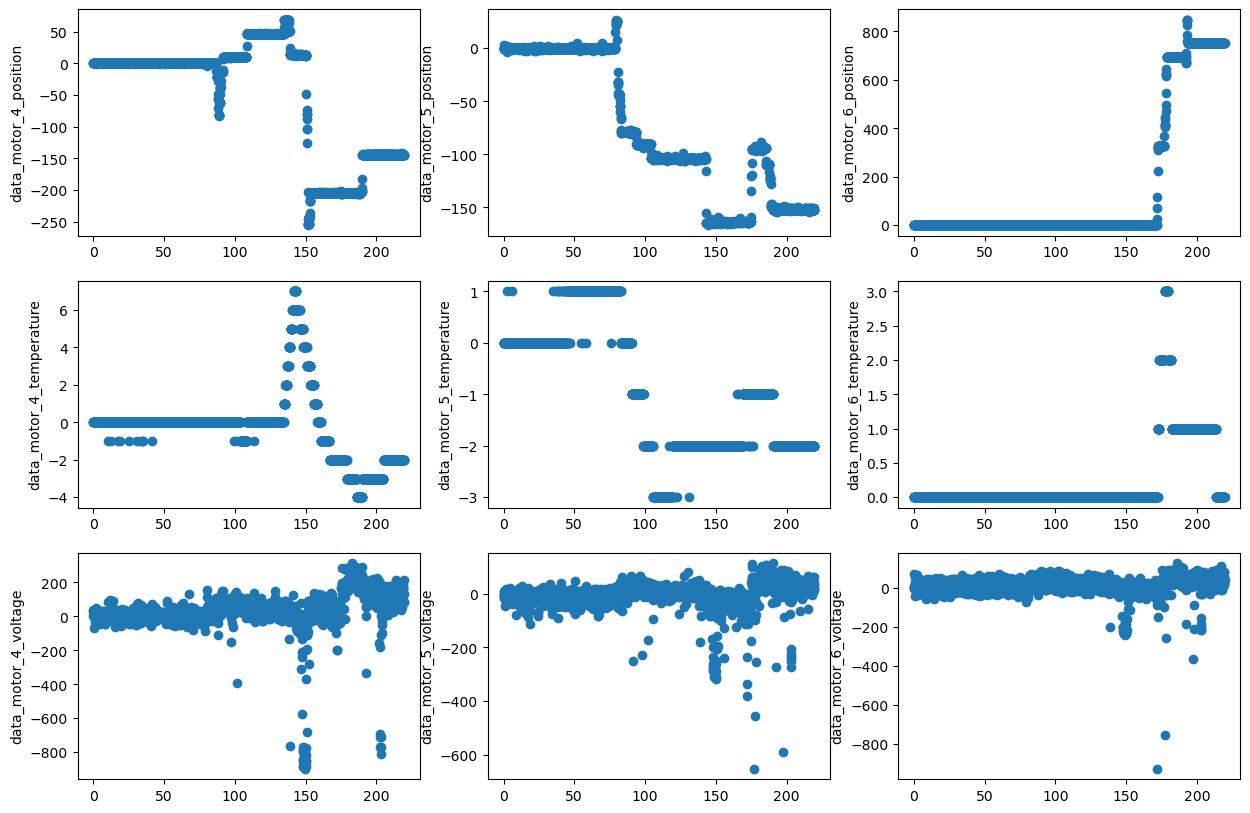

20240527_102436: 3    Not moving
Name: Description, dtype: object



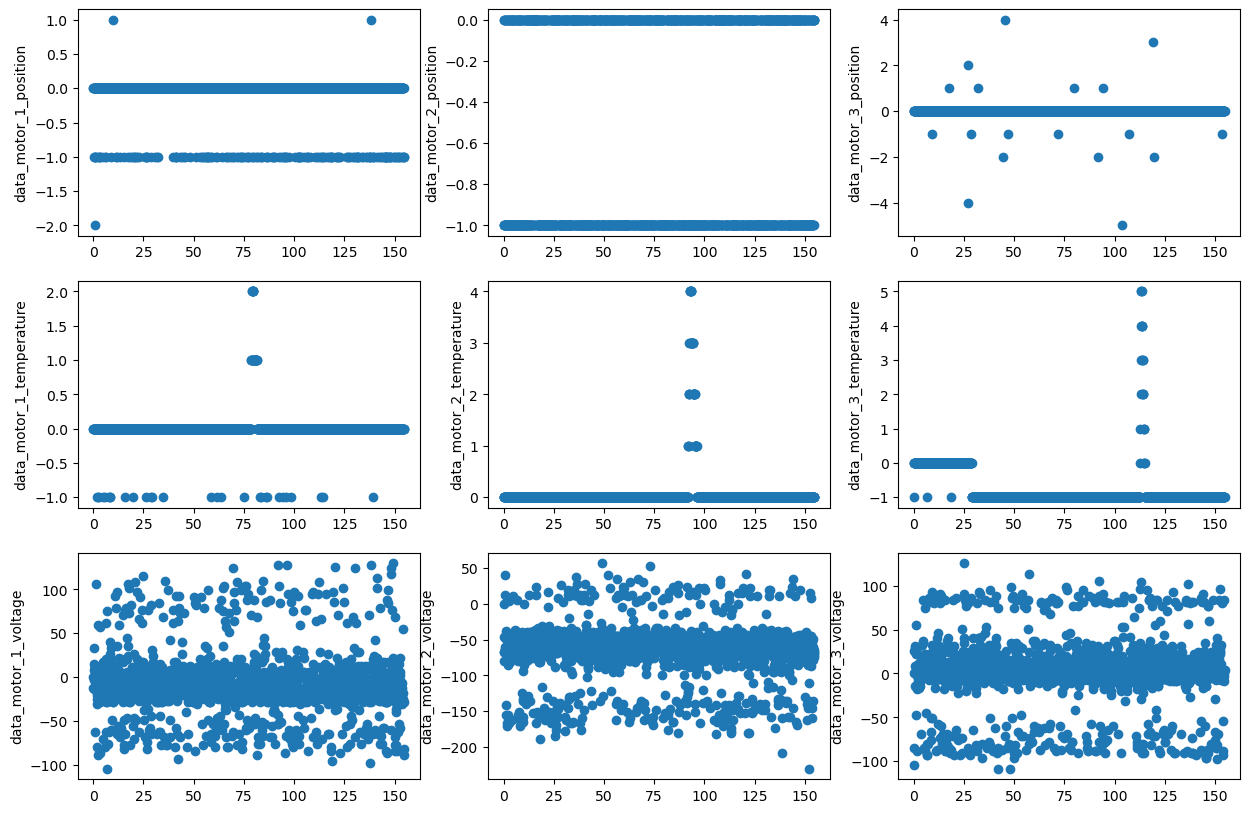

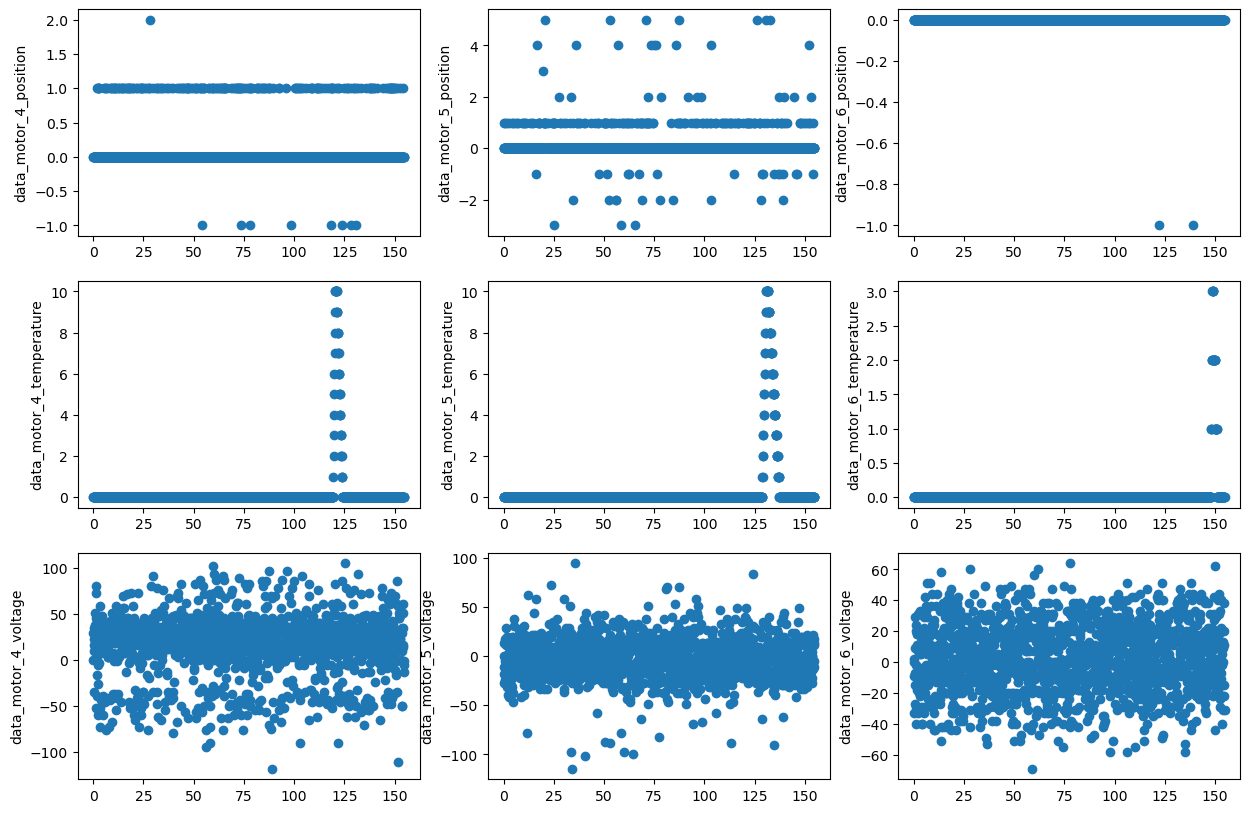

20240527_102919: 4    Not moving
Name: Description, dtype: object



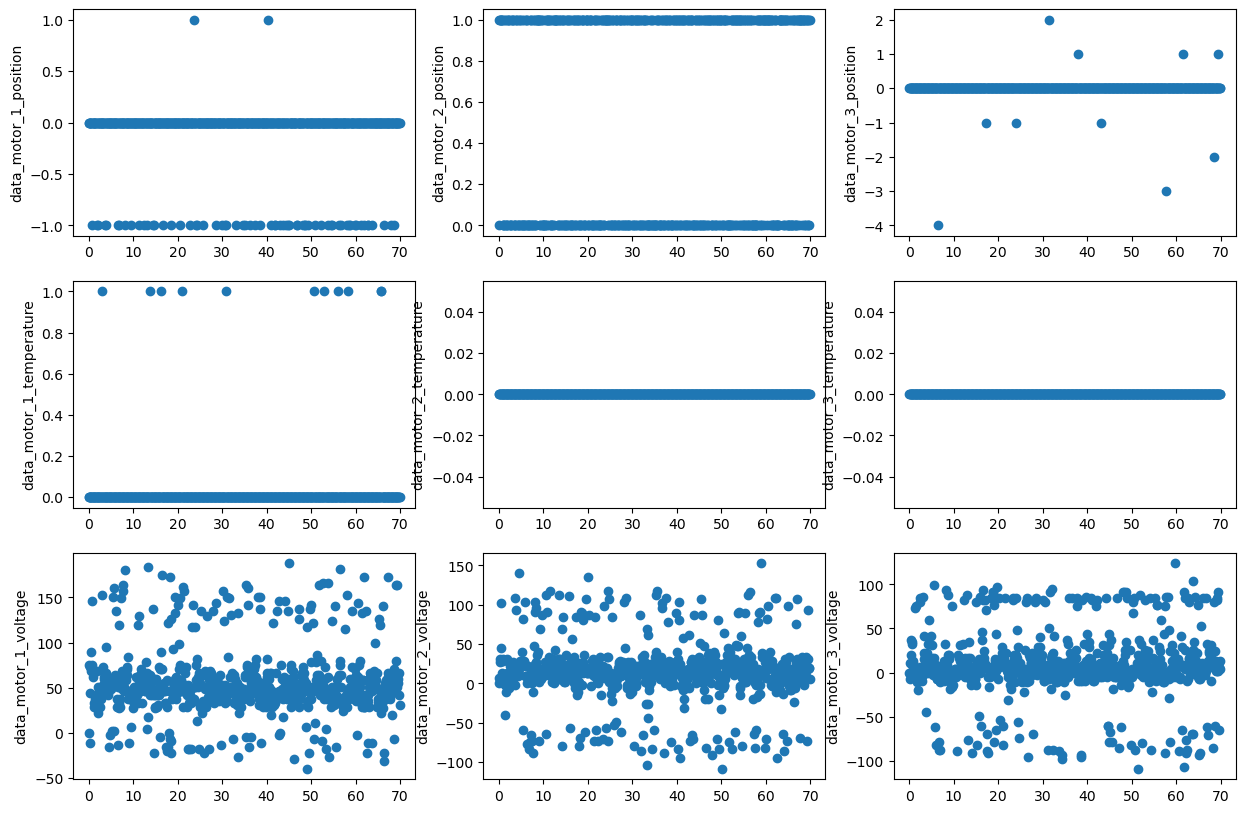

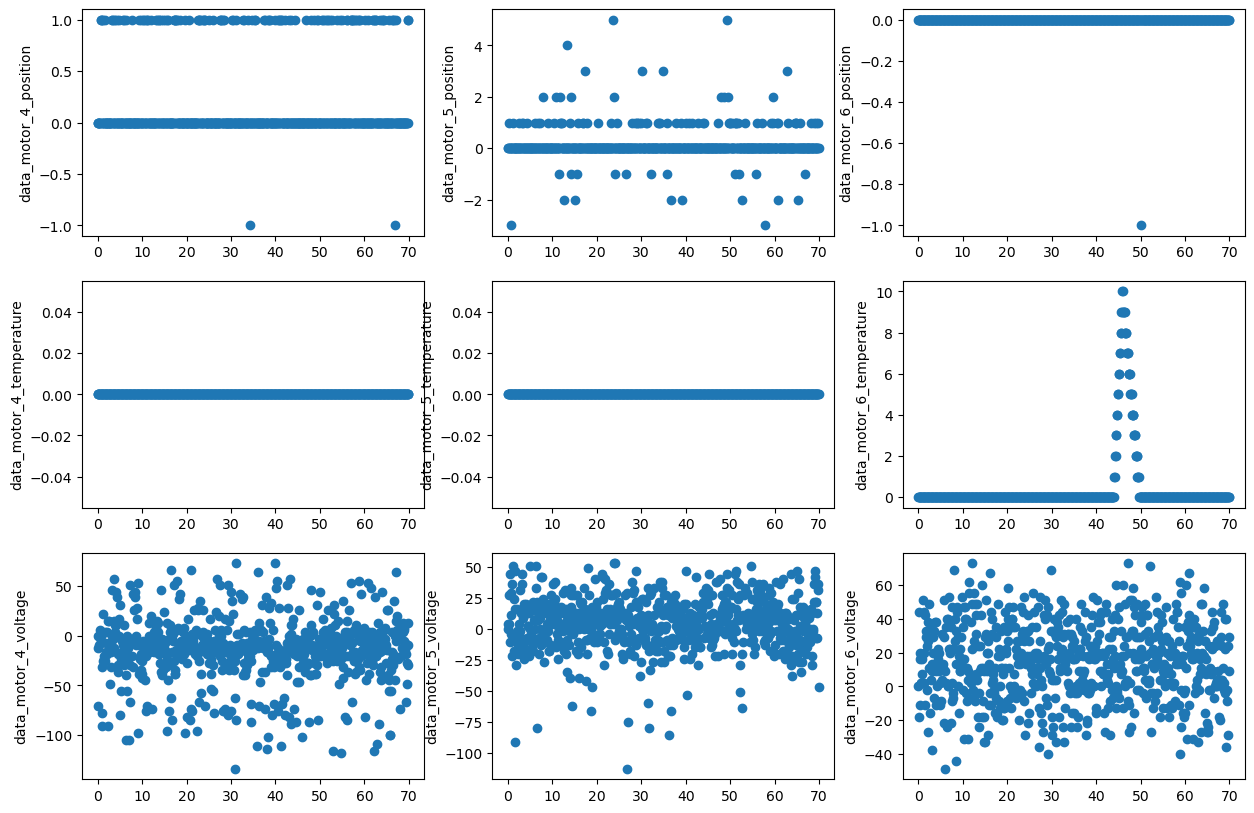

20240527_103311: 5    Not moving
Name: Description, dtype: object



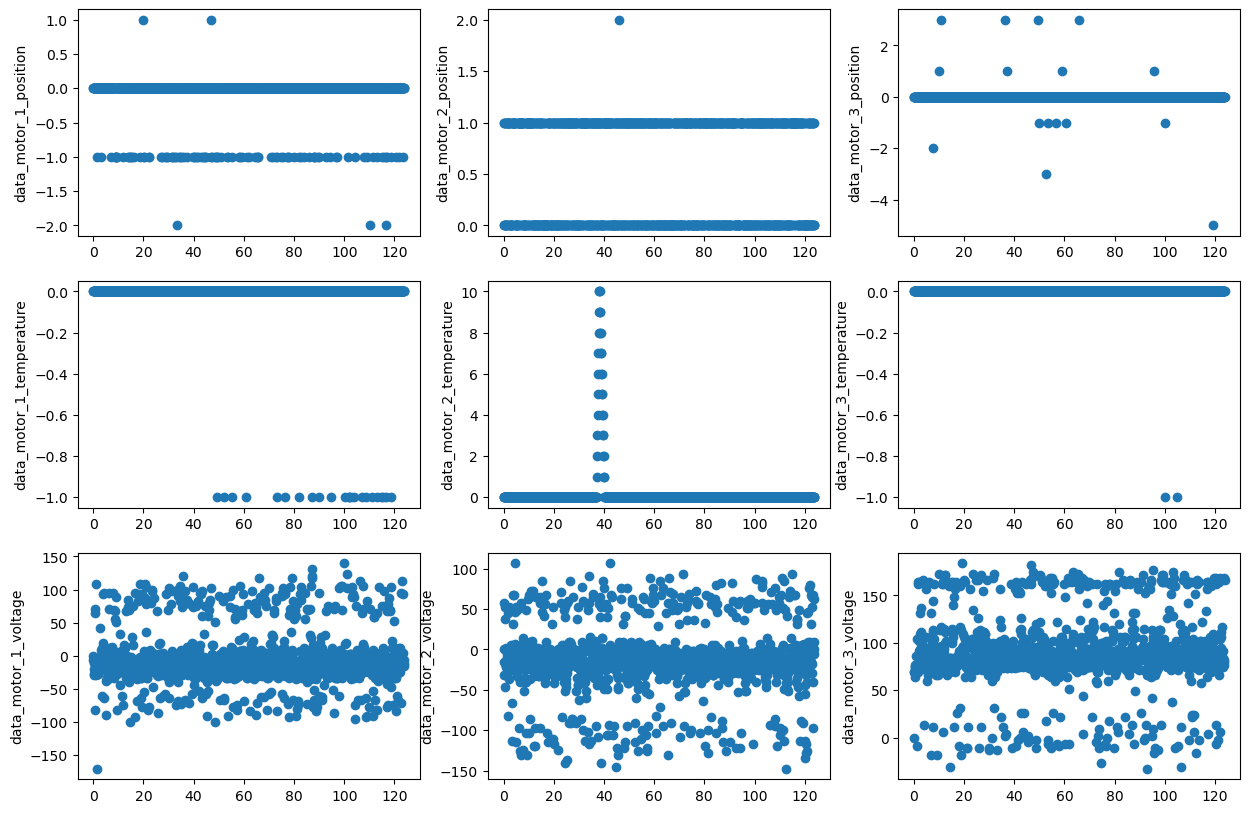

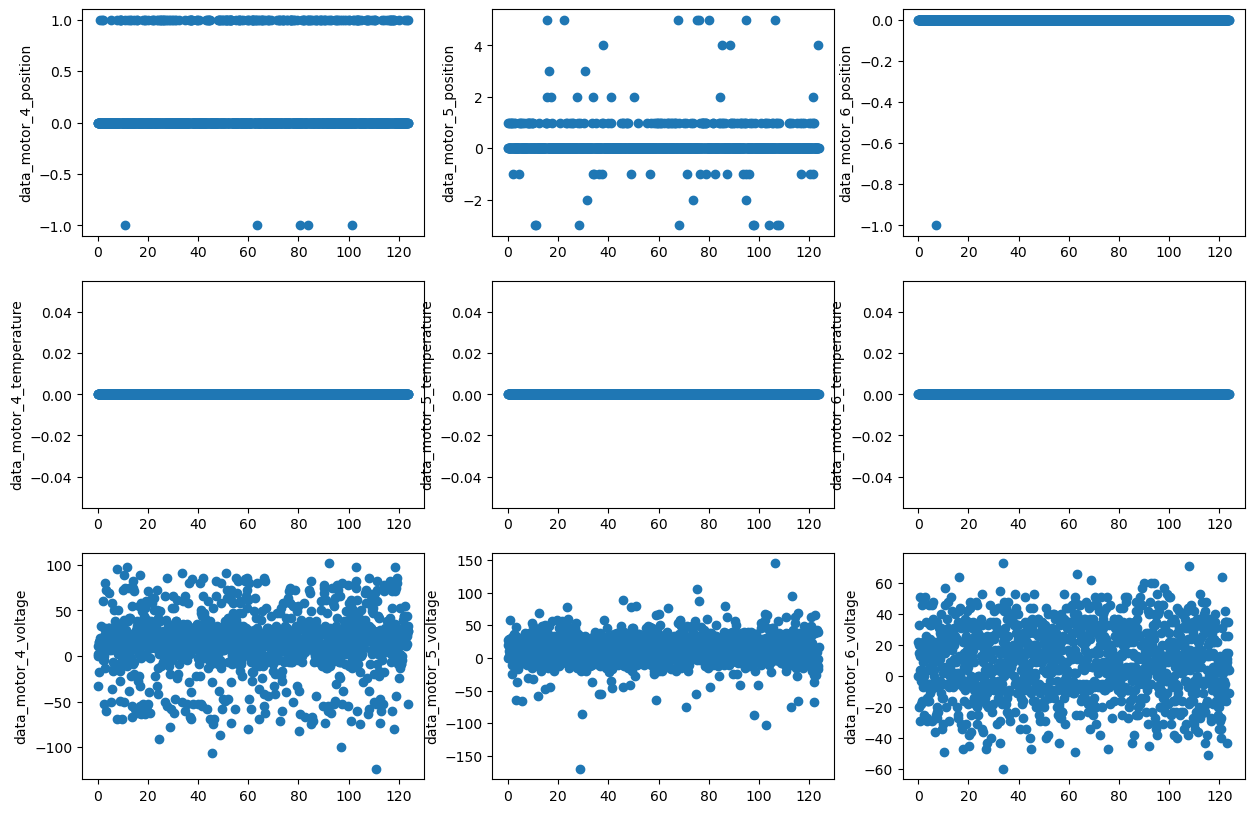

20240527_103690: 6    Moving one motor
Name: Description, dtype: object



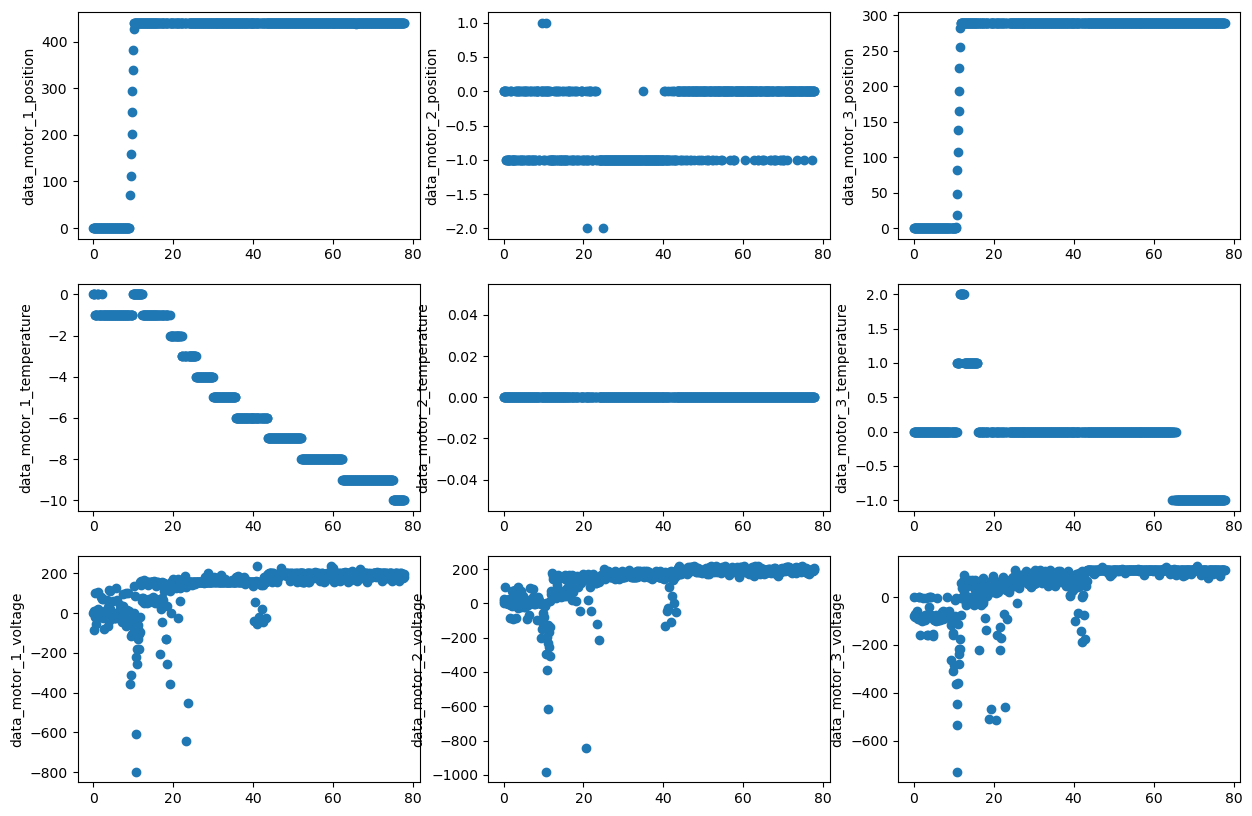

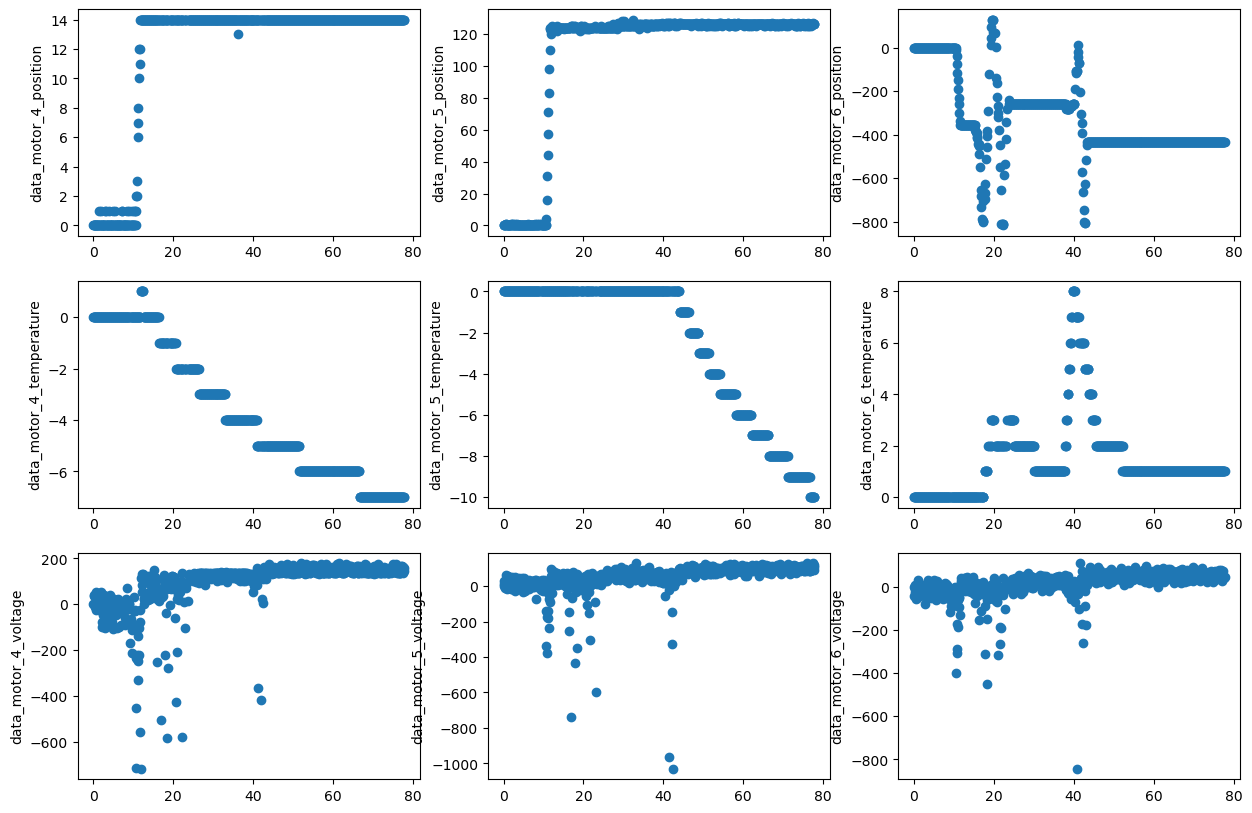

20240527_104247: 7    Moving one motor
Name: Description, dtype: object



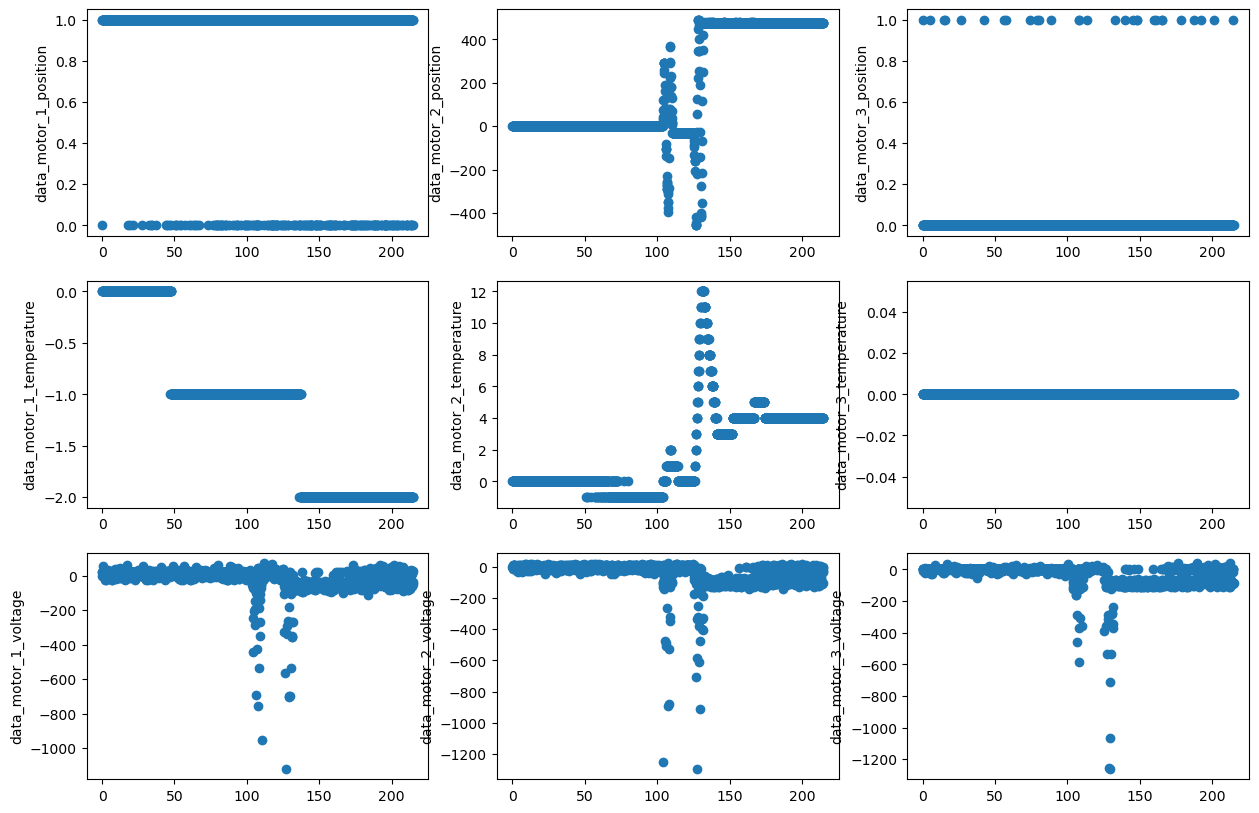

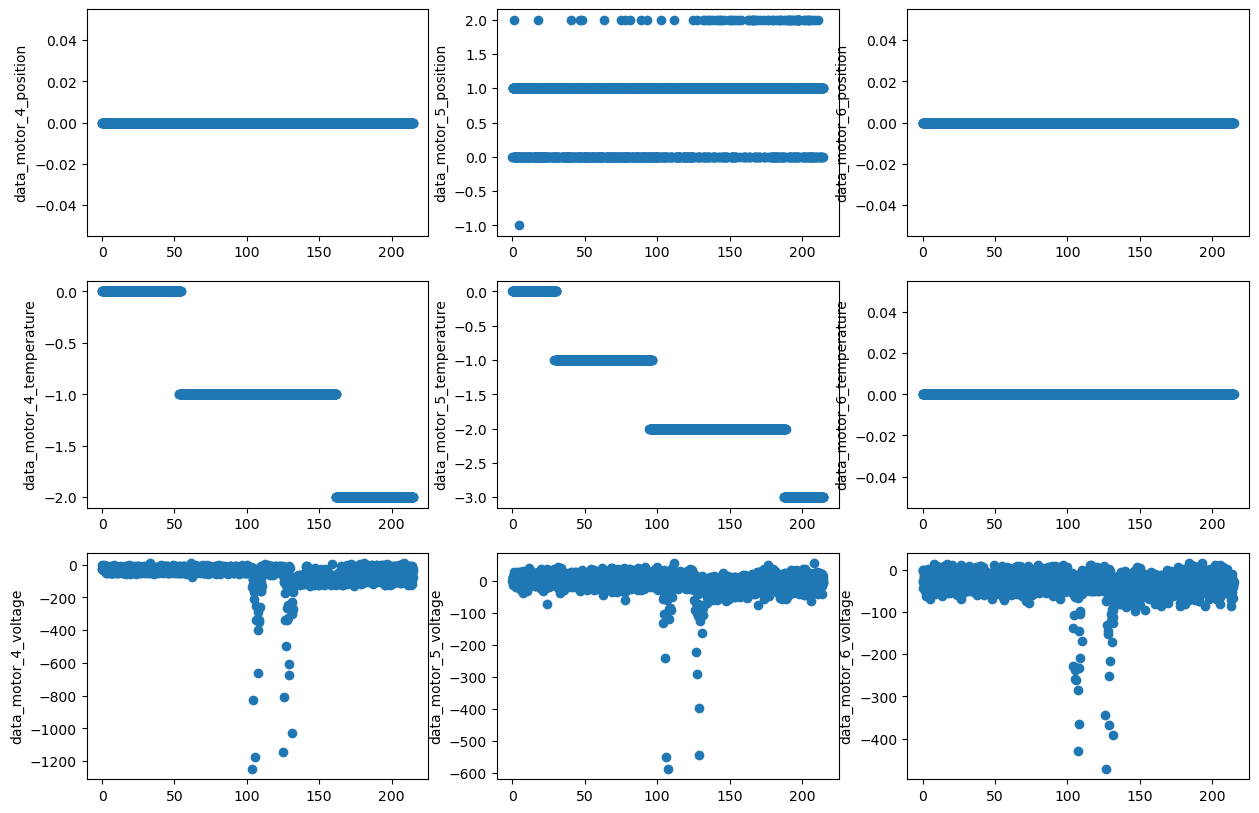

In [22]:
# Read all the dataset. Change to your dictionary if needed.
base_dictionary = '../../dataset/testing_data/testing_data/'
df_test = read_all_test_data_from_path(base_dictionary, pre_processing, is_plot=True)

## Demo: Apply a classification-based fault detection model.

In this section, we use motor $6$ as an example to demonstrate how to train a classification-based fault detection model and apply it to predict the labels on the testing dataset. The basic steps are the same as Workpackage 2. However, you need to pay attention if you use sliding windows to augument the feature space. In this case, the first window_size points in each sequence were scaped in the augumented feature space, as we do not have enough points in the history. In the data challenge, these scaped points need to be predicted manually, as the evaluation is done on all the points, including the scaped points.

In the current version of `prepare_sliding_window`, we addressed this issue by filling the missed history based on the closest available observations in the dataset. Therefore, you just need to make sure you use this version of `utility.py`, the scaped points will be filled automatically.

Below, you can find a demo how to train a logistic regression model to predict the labels for motor 6. For more details on the classification-bsaed fault detection models, you can have a look at the tutorials in [WP2](../../supporting_scripts/WP_2_20240516/demo_motor_6_lr.ipynb).

### Training

In [23]:
# ─── Motor 5 Classification Model Training ───

import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings

from utility import (
    read_all_test_data_from_path,
    extract_selected_feature,
    prepare_sliding_window
)

warnings.filterwarnings('ignore')

# 1) Motor index
motor_idx = 5

# 2) Base training DataFrame for Motor 5 (use all sequences so extract_selected_feature derives labels)
df_tr_5 = df_train.copy()

# ─── Step 1: QUICK FEATURE ENGINEERING for Motor 5 ───
df_tr_5['m5_temp_roll5'] = (
    df_tr_5
    .groupby('test_condition')['data_motor_5_temperature']
    .rolling(window=5)
    .mean()
    .reset_index(level=0, drop=True)
)
df_tr_5['m5_temp_roll5_std'] = (
    df_tr_5
    .groupby('test_condition')['data_motor_5_temperature']
    .rolling(window=5)
    .std()
    .reset_index(level=0, drop=True)
)
df_tr_5['m5_volt_roll5'] = (
    df_tr_5
    .groupby('test_condition')['data_motor_5_voltage']
    .rolling(window=5)
    .mean()
    .reset_index(level=0, drop=True)
)
df_tr_5['m5_volt_roll5_std'] = (
    df_tr_5
    .groupby('test_condition')['data_motor_5_voltage']
    .rolling(window=5)
    .std()
    .reset_index(level=0, drop=True)
)
df_tr_5['temp5_lag1'] = (
    df_tr_5
    .groupby('test_condition')['data_motor_5_temperature']
    .shift(1)
)

# Impute any NaNs (from the first few rows per sequence)
df_tr_5.fillna(method='ffill', inplace=True)
df_tr_5.fillna(0, inplace=True)

# 3) Define feature list: base + rolling/lag
feature_list_5 = [
    'time',
    'data_motor_1_position','data_motor_1_temperature','data_motor_1_voltage',
    'data_motor_2_position','data_motor_2_temperature','data_motor_2_voltage',
    'data_motor_3_position','data_motor_3_temperature','data_motor_3_voltage',
    'data_motor_4_position','data_motor_4_temperature','data_motor_4_voltage',
    'data_motor_5_position','data_motor_5_temperature','data_motor_5_voltage',
    'data_motor_6_position','data_motor_6_temperature','data_motor_6_voltage',
    # rolling & lag for Motor 5:
    'm5_temp_roll5','m5_temp_roll5_std',
    'm5_volt_roll5','m5_volt_roll5_std',
    'temp5_lag1'
]

# 4) Extract features (X) and binary labels (y) with mdl_type='clf'
df_x5, df_y5 = extract_selected_feature(
    df_data=df_tr_5,
    feature_list=feature_list_5,
    motor_idx=motor_idx,
    mdl_type='clf'
)

# 5) Create sliding windows (classification mode)
window_size = 50
sample_step = 10

X_train5, y_train5 = prepare_sliding_window(
    df_x=df_x5,
    y=df_y5,
    window_size=window_size,
    sample_step=sample_step,
    mdl_type='clf'
)

print(f"Motor 5 classification train shape: {X_train5.shape}, {y_train5.shape}")

# 6) Build a RandomForest classification pipeline
clf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# 7) (Optional) Hyperparameter grid search
param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [5, 10]
}

grid5 = GridSearchCV(
    estimator=clf_pipeline,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)

print("Training Motor 5 RandomForest classifier...")
best_clf5 = grid5.fit(X_train5, y_train5).best_estimator_
print("Best params:", grid5.best_params_)


Motor 5 classification train shape: (39309, 120), (39309,)
Training Motor 5 RandomForest classifier...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best params: {'clf__max_depth': 5, 'clf__n_estimators': 200}


### Make prediction on the testing dataset.

In [24]:
# ───  Motor 5 Test Feature Engineering + Prediction ───

# 1) Apply the same rolling & lag FE to df_test
df_test['m5_temp_roll5'] = (
    df_test
    .groupby('test_condition')['data_motor_5_temperature']
    .rolling(window=5)
    .mean()
    .reset_index(level=0, drop=True)
)
df_test['m5_temp_roll5_std'] = (
    df_test
    .groupby('test_condition')['data_motor_5_temperature']
    .rolling(window=5)
    .std()
    .reset_index(level=0, drop=True)
)
df_test['m5_volt_roll5'] = (
    df_test
    .groupby('test_condition')['data_motor_5_voltage']
    .rolling(window=5)
    .mean()
    .reset_index(level=0, drop=True)
)
df_test['m5_volt_roll5_std'] = (
    df_test
    .groupby('test_condition')['data_motor_5_voltage']
    .rolling(window=5)
    .std()
    .reset_index(level=0, drop=True)
)
df_test['temp5_lag1'] = (
    df_test
    .groupby('test_condition')['data_motor_5_temperature']
    .shift(1)
)

# Impute NaNs in df_test
df_test.fillna(method='ffill', inplace=True)
df_test.fillna(0, inplace=True)

# 2) Extract engineered features & dummy y for windowing
x5_test_org, y5_test_org = extract_selected_feature(
    df_data=df_test,
    feature_list=feature_list_5,  # same list from Cell 1
    motor_idx=motor_idx,
    mdl_type='clf'
)

# 3) Create sliding‐window test set
X_test5 = prepare_sliding_window(
    df_x=x5_test_org,
    window_size=window_size,
    sample_step=sample_step,
    mdl_type='clf'
)

# 4) Predict binary labels on each window
y_pred5_clf = best_clf5.predict(X_test5)

## Demo: Apply a regression-based fault detection model.

In this section, we will apply a regression-based fault detection model to the data. We choose the motor $5$ as an example. For details on regression-based fault detection, please refer to the tutorials in [WP3](../../supporting_scripts/WP_3_20240521/demo_FaultDetectReg.ipynb).

### Training the regression model.

In [25]:
# Train several regressors on Motor 5, pick the best, and find a fault threshold

import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, f1_score
import xgboost as xgb
import warnings

from utility import extract_selected_feature, prepare_sliding_window

warnings.filterwarnings('ignore')

motor_idx = 5

# Smooth the Motor 5 temperature, compute residuals and derivative
df_tr_5['m5_temp_smooth'] = savgol_filter(
    df_tr_5['data_motor_5_temperature'], window_length=11, polyorder=2, mode='interp'
)
df_tr_5['m5_temp_resid'] = df_tr_5['data_motor_5_temperature'] - df_tr_5['m5_temp_smooth']
df_tr_5['m5_temp_deriv'] = df_tr_5.groupby('test_condition')['data_motor_5_temperature'].diff().fillna(0)

# Create rolling-5 mean and std for temperature and voltage of Motor 5
df_tr_5['m5_temp_roll5'] = (
    df_tr_5.groupby('test_condition')['data_motor_5_temperature']
         .rolling(window=5).mean().reset_index(level=0, drop=True)
)
df_tr_5['m5_temp_roll5_std'] = (
    df_tr_5.groupby('test_condition')['data_motor_5_temperature']
         .rolling(window=5).std().reset_index(level=0, drop=True)
)
df_tr_5['m5_volt_roll5'] = (
    df_tr_5.groupby('test_condition')['data_motor_5_voltage']
         .rolling(window=5).mean().reset_index(level=0, drop=True)
)
df_tr_5['m5_volt_roll5_std'] = (
    df_tr_5.groupby('test_condition')['data_motor_5_voltage']
         .rolling(window=5).std().reset_index(level=0, drop=True)
)

# One-step lag of Motor 5 temperature
df_tr_5['m5_temp_lag1'] = (
    df_tr_5.groupby('test_condition')['data_motor_5_temperature']
         .shift(1)
)

# Fill NaNs from the smoothing, derivative, rolling, and lag operations
df_tr_5.fillna(method='ffill', inplace=True)
df_tr_5.fillna(0, inplace=True)

# List all features: the original sensor columns plus our new ones for Motor 5
feature_list_5 = [
    'time',
    'data_motor_1_position','data_motor_1_temperature','data_motor_1_voltage',
    'data_motor_2_position','data_motor_2_temperature','data_motor_2_voltage',
    'data_motor_3_position','data_motor_3_temperature','data_motor_3_voltage',
    'data_motor_4_position','data_motor_4_temperature','data_motor_4_voltage',
    'data_motor_5_position','data_motor_5_temperature','data_motor_5_voltage',
    'data_motor_6_position','data_motor_6_temperature','data_motor_6_voltage',
    'm5_temp_smooth','m5_temp_resid','m5_temp_deriv',
    'm5_temp_roll5','m5_temp_roll5_std',
    'm5_volt_roll5','m5_volt_roll5_std',
    'm5_temp_lag1'
]

# Extract per-row features and the continuous temperature target
x5_org, y5_org = extract_selected_feature(
    df_data=df_tr_5,
    feature_list=feature_list_5,
    motor_idx=motor_idx,
    mdl_type='reg'
)

# Turn per-row data into sliding windows of length 20
window_size = 20
sample_step = 1
prediction_lead_time = 1

X_train5, y_train5 = prepare_sliding_window(
    df_x=x5_org,
    y=y5_org,
    window_size=window_size,
    sample_step=sample_step,
    prediction_lead_time=prediction_lead_time,
    mdl_type='reg'
)

print("Train shape:", X_train5.shape, y_train5.shape)

# Define four candidate regressors wrapped in a scaling pipeline
candidates = {
    'LinReg': Pipeline([
        ('scaler', StandardScaler()),
        ('reg', LinearRegression())
    ]),
    'RF': Pipeline([
        ('scaler', StandardScaler()),
        ('reg', RandomForestRegressor(
            n_estimators=200, max_depth=12, random_state=42, n_jobs=-1
        ))
    ]),
    'GB': Pipeline([
        ('scaler', StandardScaler()),
        ('reg', GradientBoostingRegressor(
            n_estimators=200, max_depth=8, learning_rate=0.05, subsample=0.8,
            random_state=42
        ))
    ]),
    'XGB': Pipeline([
        ('scaler', StandardScaler()),
        ('reg', xgb.XGBRegressor(
            n_estimators=200, max_depth=6, learning_rate=0.05, subsample=0.8,
            colsample_bytree=0.8, random_state=42, verbosity=0
        ))
    ])
}

# Use 2-fold time-series CV to pick the model with lowest RMSE
tscv = TimeSeriesSplit(n_splits=2)
cv_scores = {}
for name, model in candidates.items():
    neg_mse = cross_val_score(
        model, X_train5, y_train5,
        cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1
    )
    rmse = np.sqrt(-neg_mse).mean()
    cv_scores[name] = rmse
    print(f"{name} CV RMSE:", round(rmse, 4))

best_name = min(cv_scores, key=cv_scores.get)
best_rmse = cv_scores[best_name]
best_model5 = candidates[best_name]
print(f"Chosen model: {best_name} (RMSE={best_rmse:.4f})")

# Retrain that chosen model on all of the windowed training data
best_model5.fit(X_train5, y_train5)

# Reserve the last 20% of windows (no shuffle) to find the best fault threshold
X5_sub, X5_val, Y5_sub, Y5_val = train_test_split(
    X_train5, y_train5, test_size=0.2, shuffle=False
)
best_sub = Pipeline(best_model5.steps)
best_sub.set_params(**best_model5.named_steps)
best_sub.fit(X5_sub, Y5_sub)
Y5_val_pred = best_sub.predict(X5_val)

ths = np.linspace(0.1, 0.9, 17)
threshold_scores = [
    (th, f1_score((Y5_val > 0).astype(int), (Y5_val_pred > th).astype(int)))
    for th in ths
]
best_th5, best_f15 = max(threshold_scores, key=lambda x: x[1])
print(f"Best threshold = {round(best_th5,2)}, F1 = {round(best_f15,3)}")


Train shape: (39309, 539) (39309,)
LinReg CV RMSE: 0.0043
RF CV RMSE: 1.2721
GB CV RMSE: 1.2271
XGB CV RMSE: 1.2725
Chosen model: LinReg (RMSE=0.0043)
Best threshold = 0.1, F1 = 1.0


### Making prediction.

In [26]:
# Apply the chosen model and threshold on test set (no CSV writing)

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.signal import savgol_filter

# Smooth and derive Motor 5 features
df_test['m5_temp_smooth'] = savgol_filter(
    df_test['data_motor_5_temperature'], window_length=11, polyorder=2, mode='interp'
)
df_test['m5_temp_resid'] = df_test['data_motor_5_temperature'] - df_test['m5_temp_smooth']
df_test['m5_temp_deriv'] = df_test.groupby('test_condition')['data_motor_5_temperature'].diff().fillna(0)

# Add rolling and lag features for Motor 5
df_test['m5_temp_roll5'] = (
    df_test.groupby('test_condition')['data_motor_5_temperature']
           .rolling(window=5).mean().reset_index(level=0, drop=True)
)
df_test['m5_temp_roll5_std'] = (
    df_test.groupby('test_condition')['data_motor_5_temperature']
           .rolling(window=5).std().reset_index(level=0, drop=True)
)
df_test['m5_volt_roll5'] = (
    df_test.groupby('test_condition')['data_motor_5_voltage']
           .rolling(window=5).mean().reset_index(level=0, drop=True)
)
df_test['m5_volt_roll5_std'] = (
    df_test.groupby('test_condition')['data_motor_5_voltage']
           .rolling(window=5).std().reset_index(level=0, drop=True)
)
df_test['m5_temp_lag1'] = (
    df_test.groupby('test_condition')['data_motor_5_temperature']
           .shift(1)
)

df_test.fillna(method='ffill', inplace=True)
df_test.fillna(0, inplace=True)

# Extract features and labels
x5_test_org, y5_test_org = extract_selected_feature(
    df_data=df_test,
    feature_list=feature_list_5,
    motor_idx=motor_idx,
    mdl_type='reg'
)

# Prepare windowed test features
X5_test, Y5_test_windows = prepare_sliding_window(
    df_x=x5_test_org,
    y=y5_test_org,
    window_size=window_size,
    sample_step=sample_step,
    mdl_type='reg'
)

print("Test data shape:", X5_test.shape)

# Get predicted temperatures from model
Y5_pred_test = best_model5.predict(X5_test)

# Convert predictions to fault labels using the threshold
y5_fault_pred = (Y5_pred_test > best_th5).astype(int)
print("Predicted faults:", np.sum(y5_fault_pred), "Rate:", round(np.mean(y5_fault_pred), 4))


Test data shape: (14157, 539)
Predicted faults: 697 Rate: 0.0492


## Prepare the results as a submission file for the data challenge.

In this section, we demo how to prepare the results as a submission file for the data challenge. First, we need to download the submission template `sample_submission.csv` from [kaggle](https://www.kaggle.com/competitions/robot-predictive-maintenance/data). As shown below, in this csv files, we just need to give our prediction on the six motors in the corresponding columns. You can find a demo below.

In [27]:
import pandas as pd

# Read the template.
path = '../kaggle_data_challenge/sample_submission.csv' # Change to your path.
df_submission = pd.read_csv(path)

# Initial all values with -1.
df_submission.loc[:, ['data_motor_5_label', 'data_motor_6_label']] = -1
df_submission.head()

idx  data_motor_1_label  data_motor_2_label  data_motor_3_label  \
0    0                  -1                  -1                  -1   
1    1                  -1                  -1                  -1   
2    2                  -1                  -1                  -1   
3    3                  -1                  -1                  -1   
4    4                  -1                  -1                  -1   

   data_motor_4_label  data_motor_5_label  data_motor_6_label   test_condition  
0                  -1                  -1                  -1  20240527_094865  
1                  -1                  -1                  -1  20240527_094865  
2                  -1                  -1                  -1  20240527_094865  
3                  -1                  -1                  -1  20240527_094865  
4                  -1                  -1                  -1  20240527_094865

In [28]:
# Replace each column with your prediction.
df_submission['data_motor_5_label'] = y5_fault_pred
#df_submission['data_motor_5_label'] = y_pred5_clf
# For the other motors, we just fill with 0.
#df_submission.loc[:, ['data_motor_6_label']] = 0
df_submission.head()

idx  data_motor_1_label  data_motor_2_label  data_motor_3_label  \
0    0                  -1                  -1                  -1   
1    1                  -1                  -1                  -1   
2    2                  -1                  -1                  -1   
3    3                  -1                  -1                  -1   
4    4                  -1                  -1                  -1   

   data_motor_4_label  data_motor_5_label  data_motor_6_label   test_condition  
0                  -1                   0                  -1  20240527_094865  
1                  -1                   0                  -1  20240527_094865  
2                  -1                   0                  -1  20240527_094865  
3                  -1                   0                  -1  20240527_094865  
4                  -1                   0                  -1  20240527_094865

In [29]:
# Output the submission csv.
df_submission.to_csv('../ws_prepare_data_challenge/submission.csv')